# Analytics - Product Quality

#### Date: 2023/12

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2023/02
##### Professor: Hilmer Neri

##### Members:

- Ana Carolina Rodrigues Leite
- Ariel Vieira Lima Serafim
- Caio César Oliveira
- Ian Pereira de Sousa Rocha
- João Victor Max Bisinotti de Oliveira
- Lameque Fernandes Azevedo
- Levi Lunique Izidio da Silva
- Luana de Lima Medeiros
- Lucas Freire Lopes
- Lucas Gomes Lopes
- Murilo Schiler Lopes Santana
- Renata Quadros Kurzawa
- Vinicius Angelo de Brito Vieira
- Vitor Eduardo Kühl Rodrigues


### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [4]:
# Set your repo major name here
# Example: fga-eps-mds-2022-2-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-2-MeasureSoftGram-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'Service': 'py',
    'CLI': 'py',
    'Front': 'ts',
    'Core': 'py',
    'Action': 'ts',
    'Parser': 'py'
}

### SonarCloud
##### Path to the folder with all your jsons

In [5]:
# Maybe you should change this path to your own path
import os
import re

sonar_files = glob('./analytics-raw-data/*.json')
#sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

for file in sonar_files:
    wrong_date = re.findall(r"[a-z]-(\d+-\d+-\d+-\d+-\d+)-[a-z]", file)
    if len(wrong_date) > 0:
        print(re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))
        os.rename(file, re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))

sonar_files = glob('./analytics-raw-data/*.json')
#sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

## Create DataFrame

#### Unmarshall json

In [6]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [8]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [9]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [10]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [11]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)
        
    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [12]:
file_component_df = create_component_df(sonar_files)
file_component_df = file_component_df[~file_component_df.path.str.contains("__init__") & ~file_component_df.path.str.contains("staticfiles")]
file_component_df.repository.unique()

array(['fga-eps-mds-2023-2-MeasureSoftGram-Action',
       'fga-eps-mds-2023-2-MeasureSoftGram-CLI',
       'fga-eps-mds-2023-2-MeasureSoftGram-Core',
       'fga-eps-mds-2023-2-MeasureSoftGram-Front',
       'fga-eps-mds-2023-2-MeasureSoftGram-Parser',
       'fga-eps-mds-2023-2-MeasureSoftGram-Service'], dtype=object)

### Create dataframe per repository

In [13]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [14]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [15]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [16]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [17]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [18]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [19]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [20]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [21]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [22]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

## Data visualization

In this area you will need to plot the metrics of each repository.

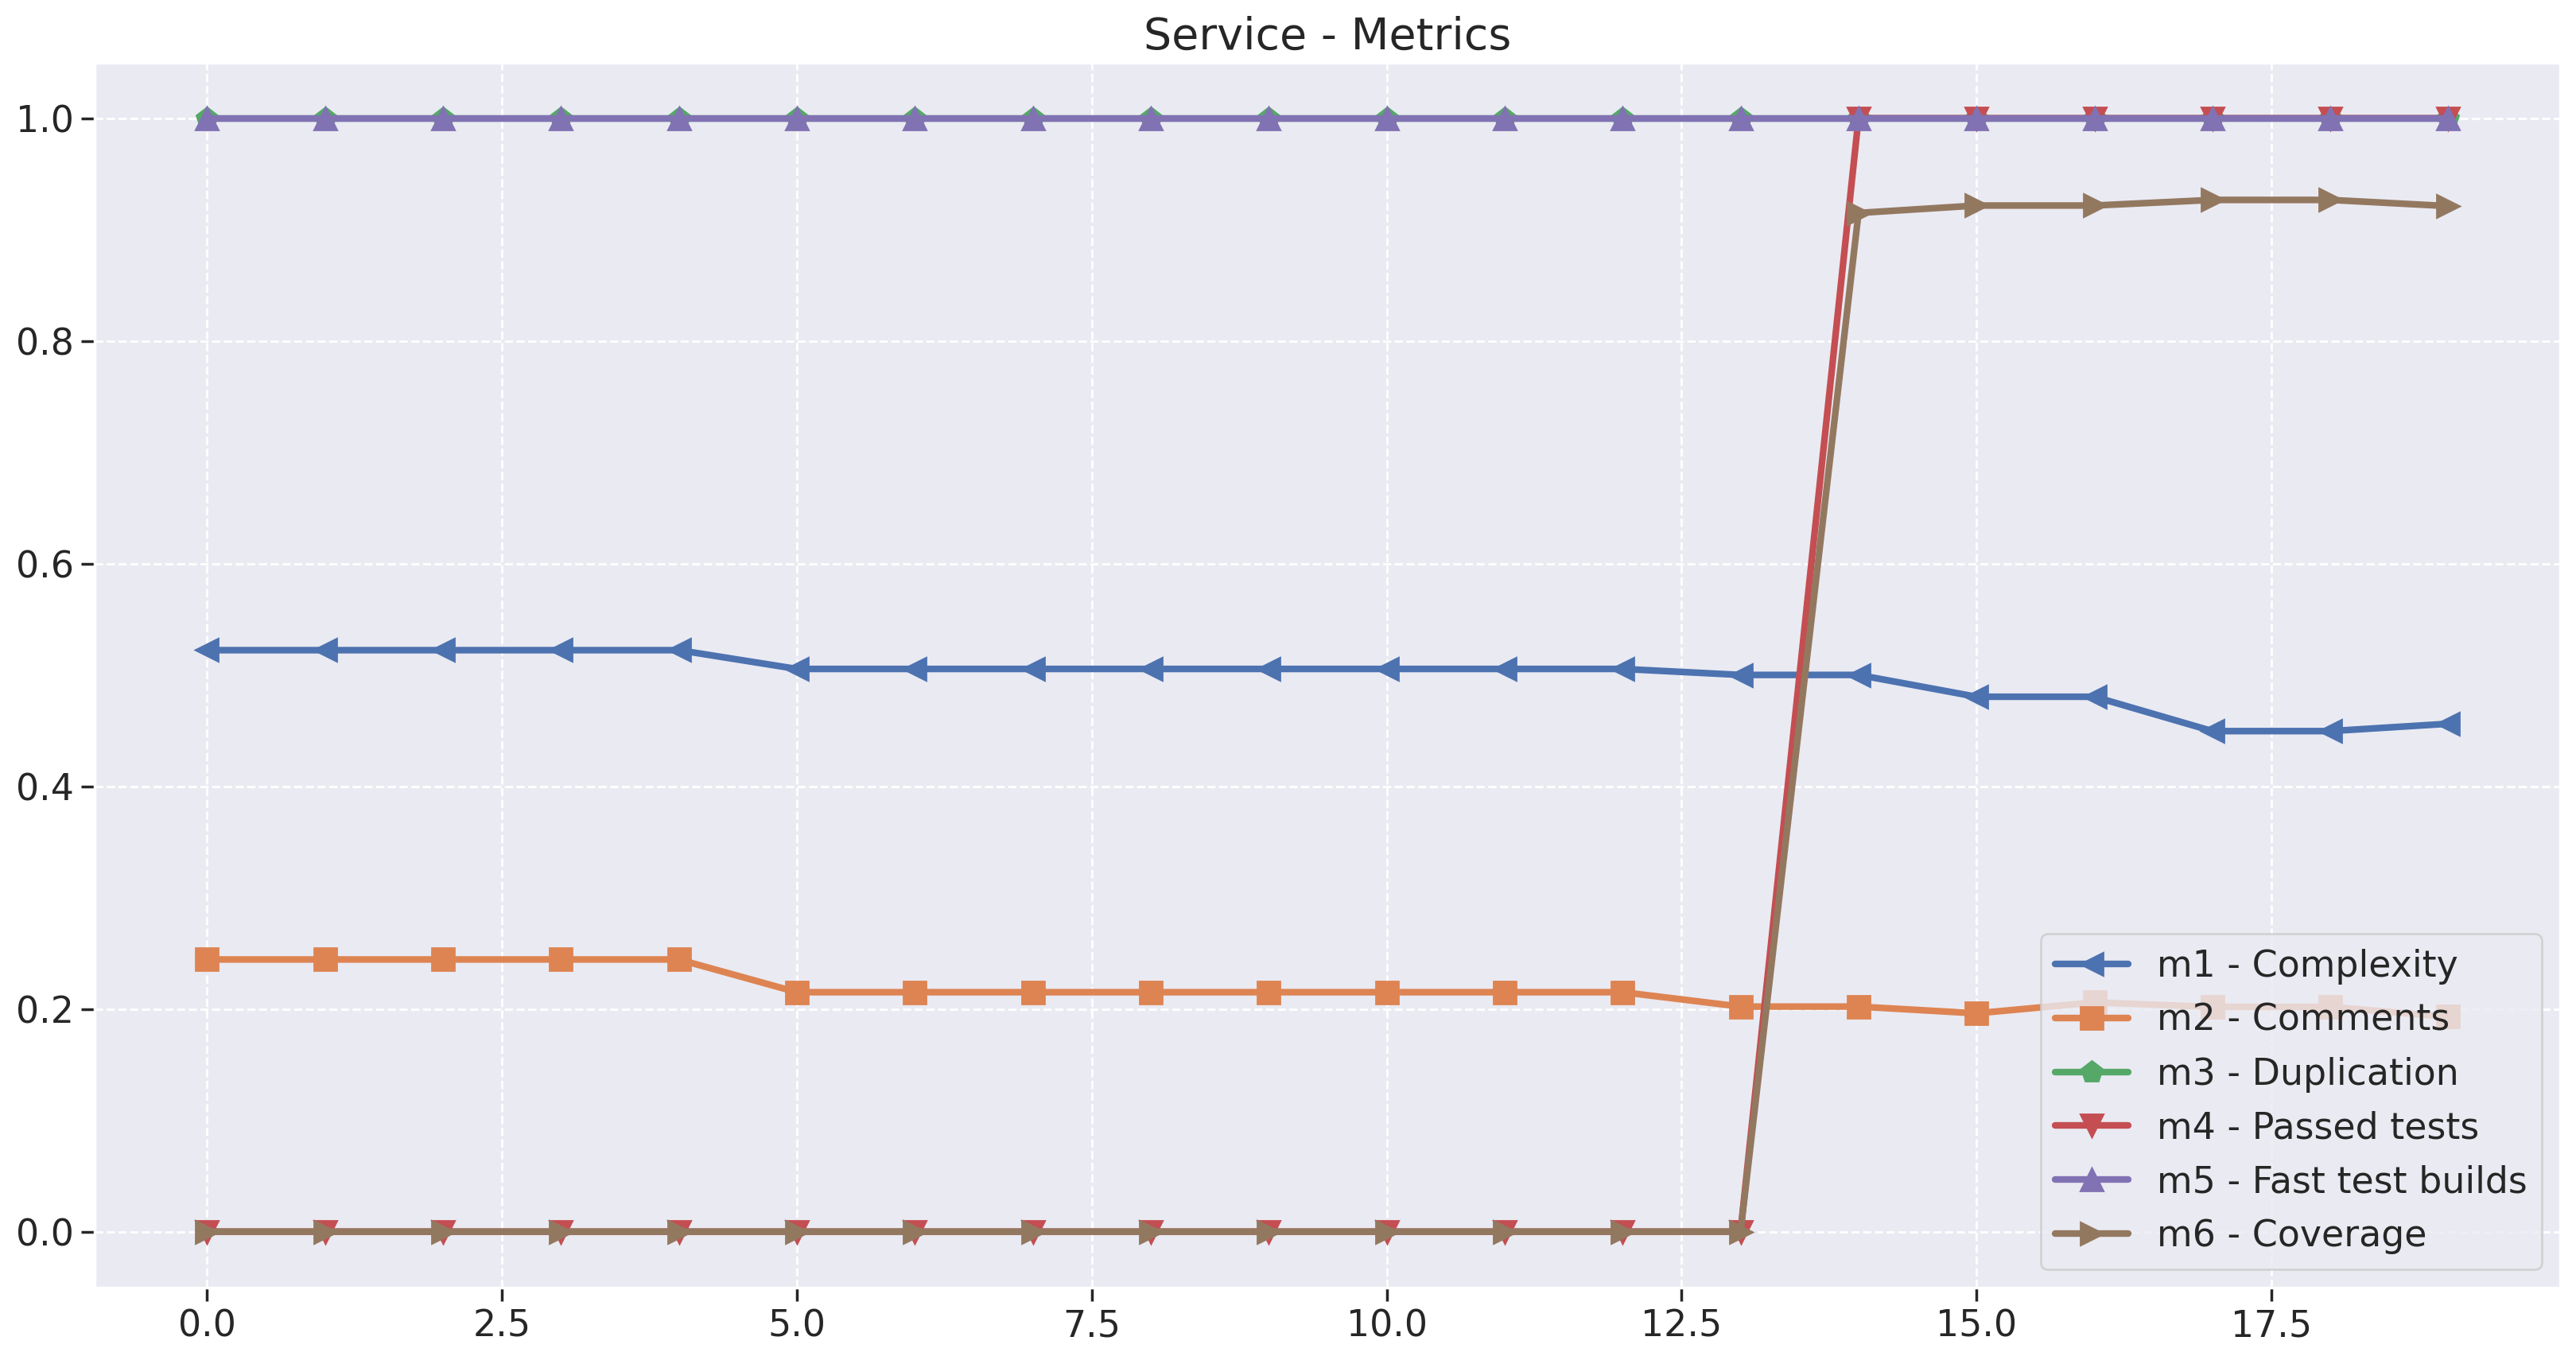

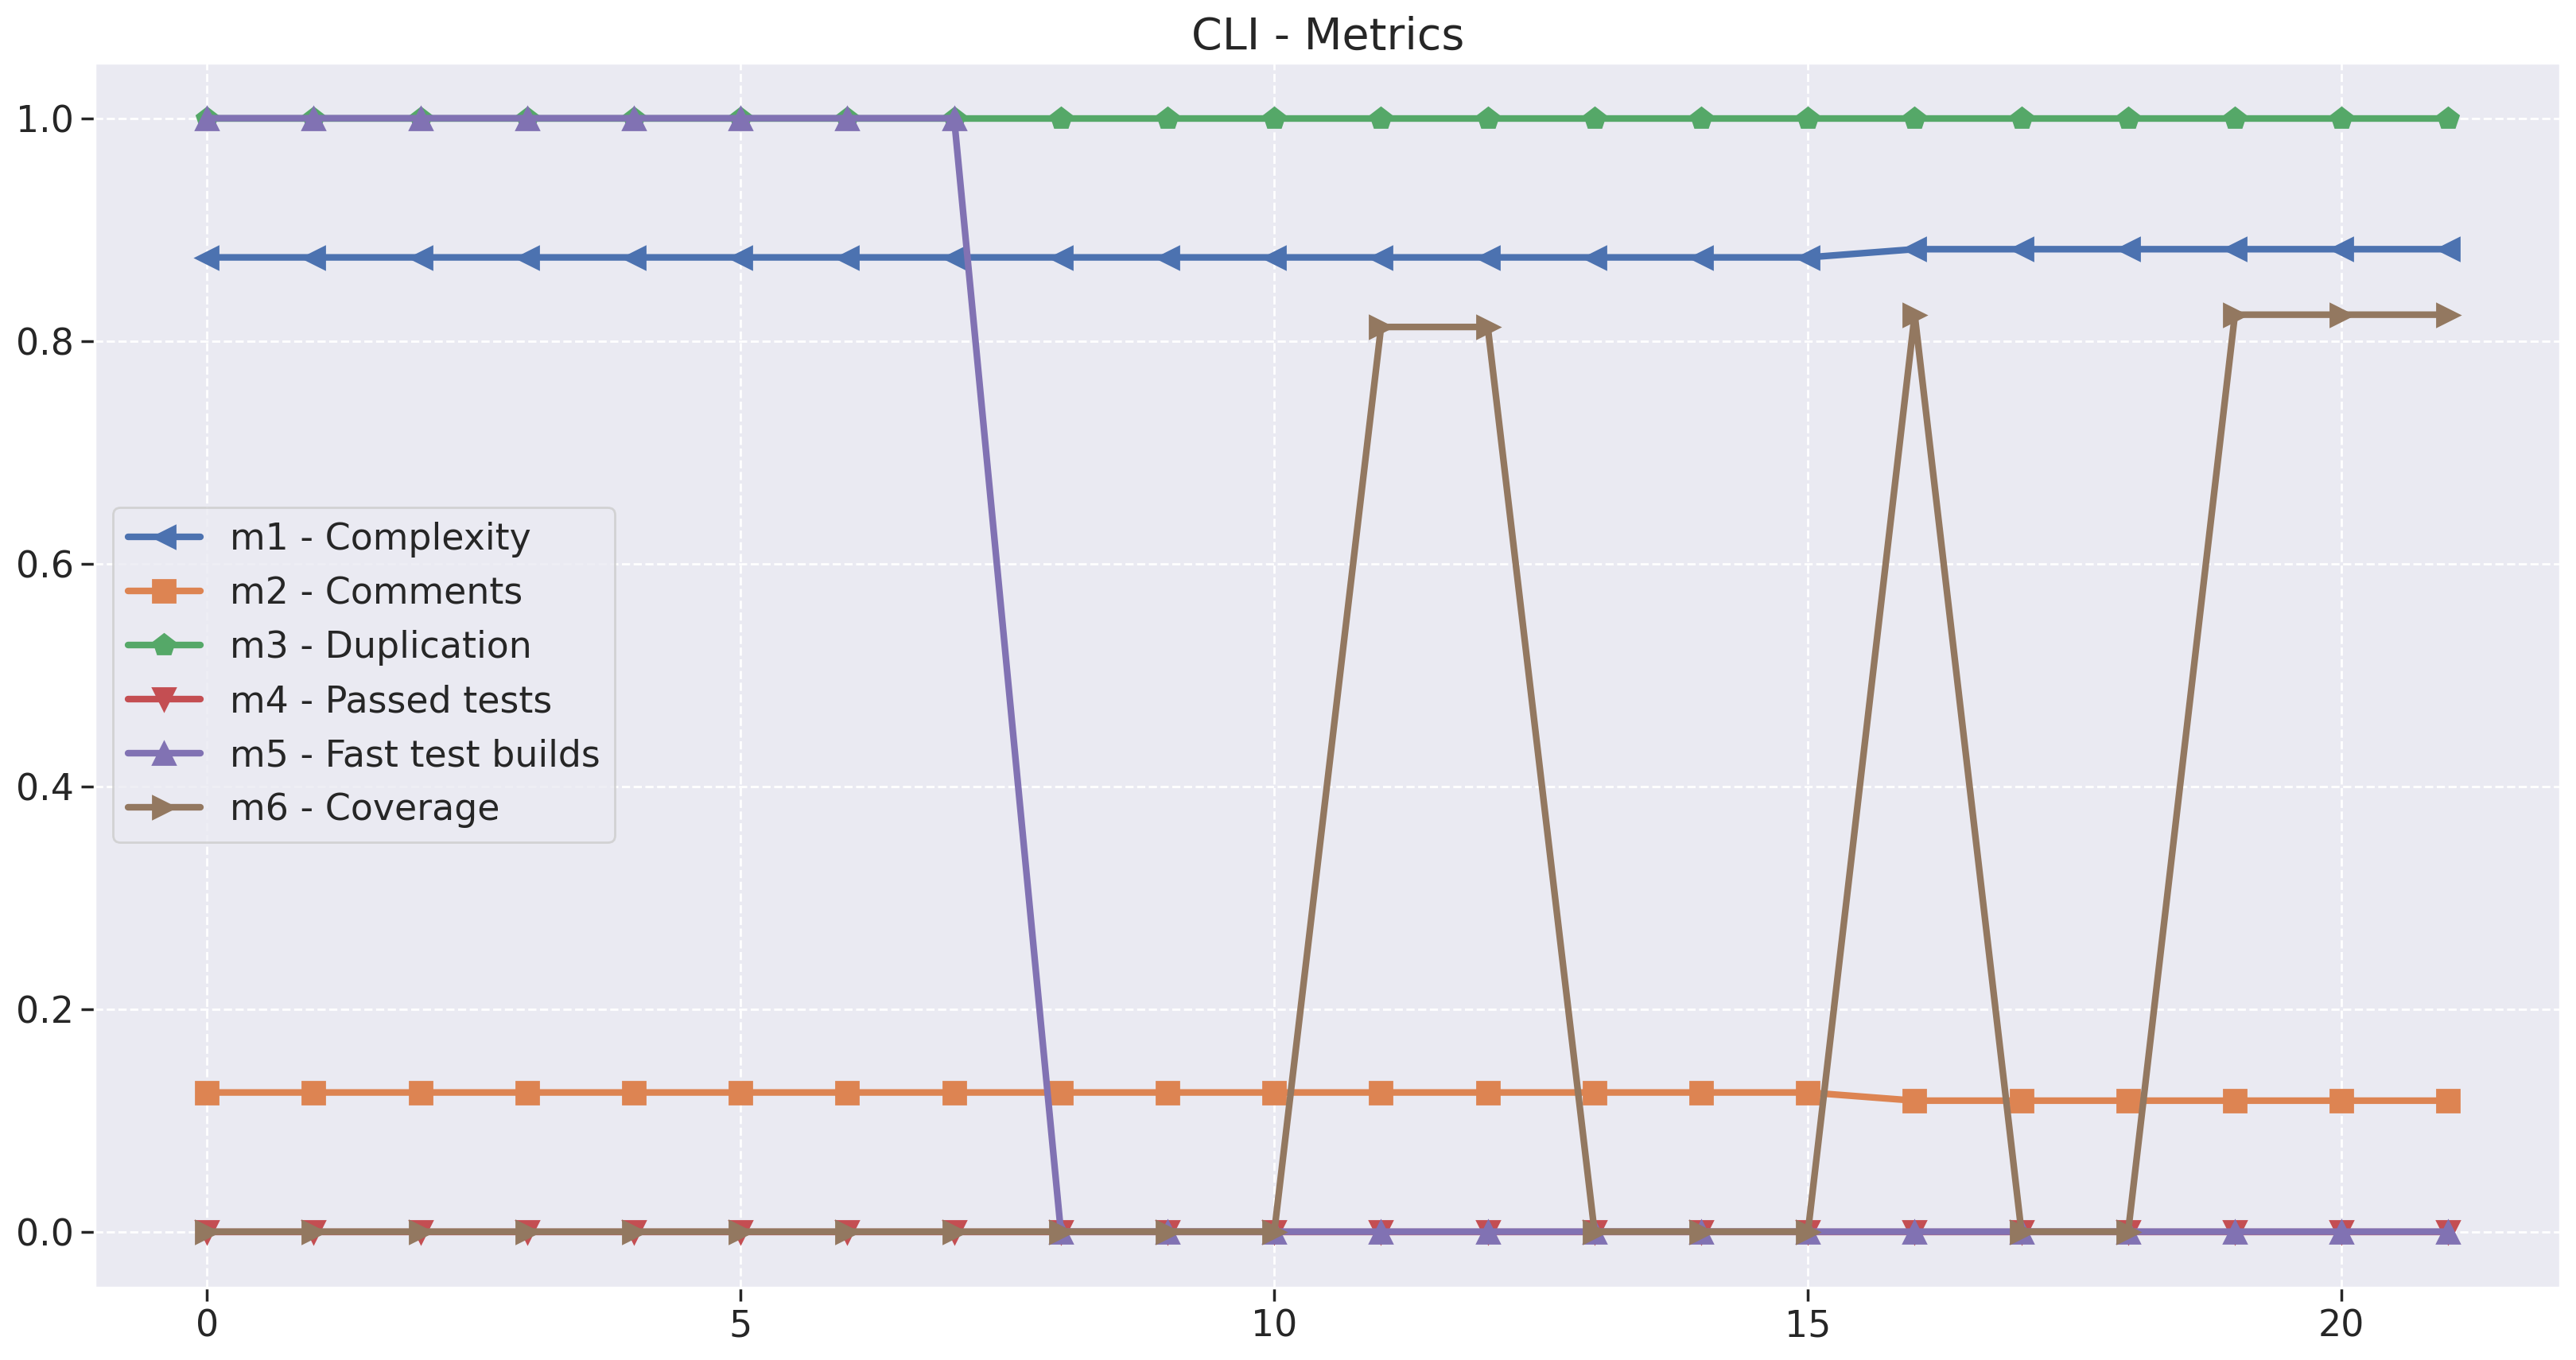

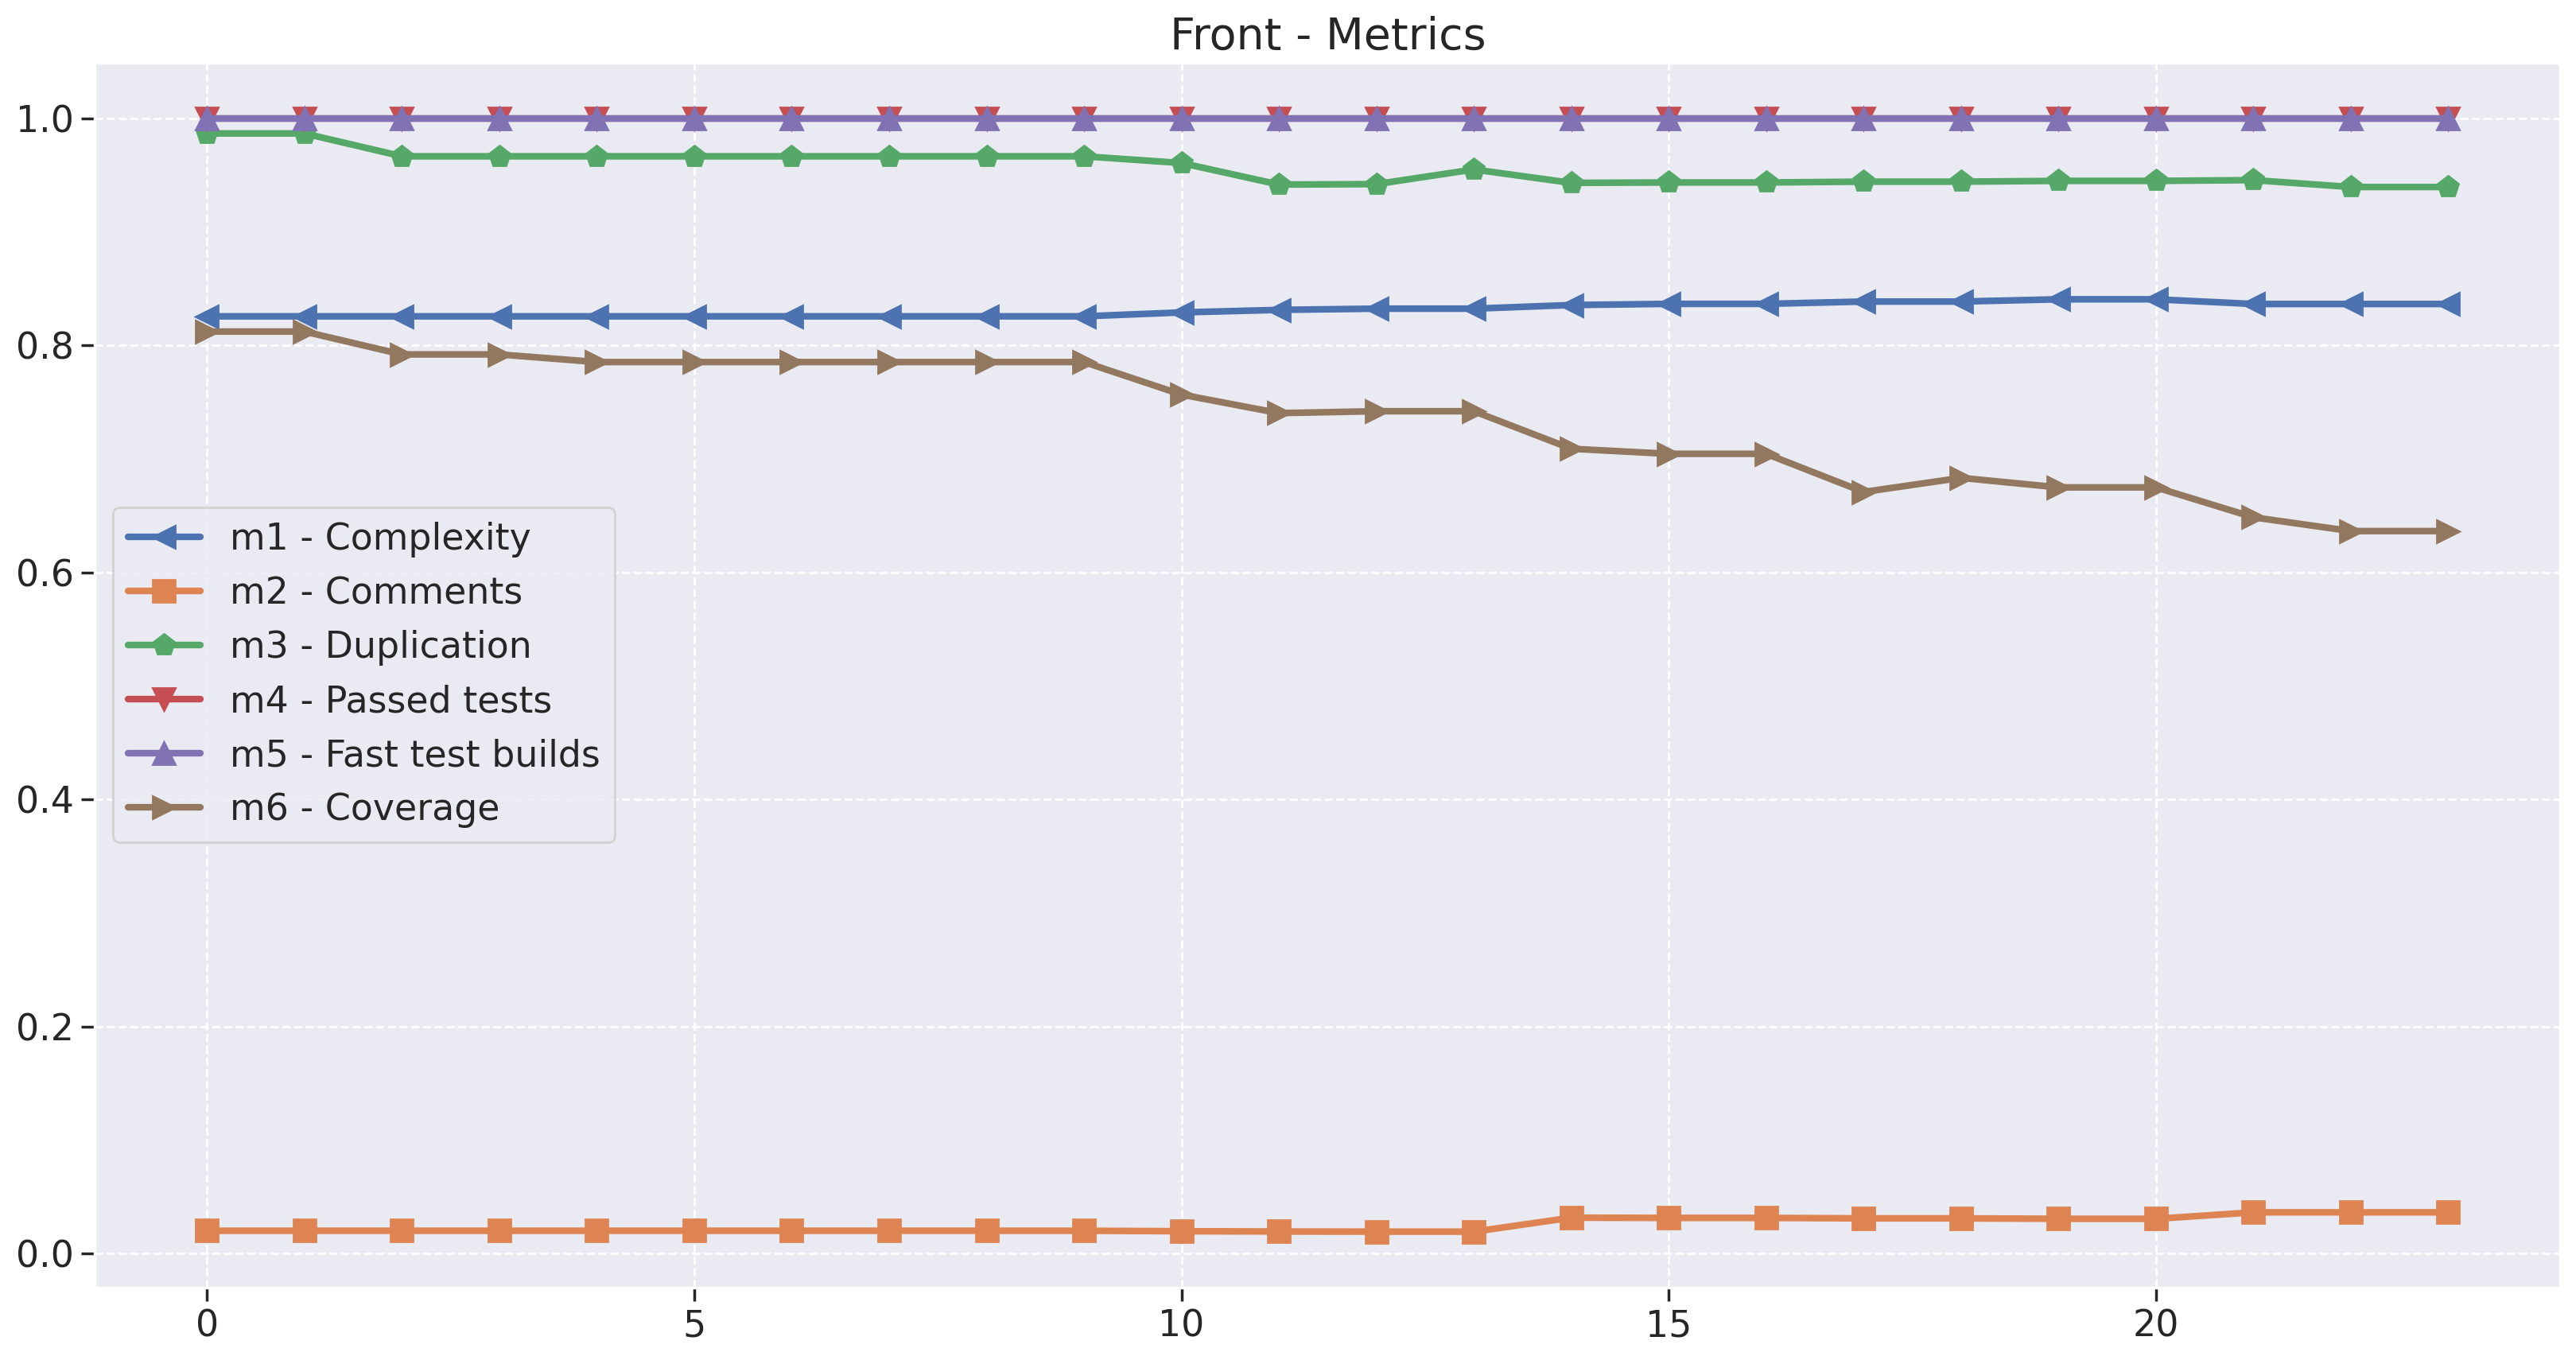

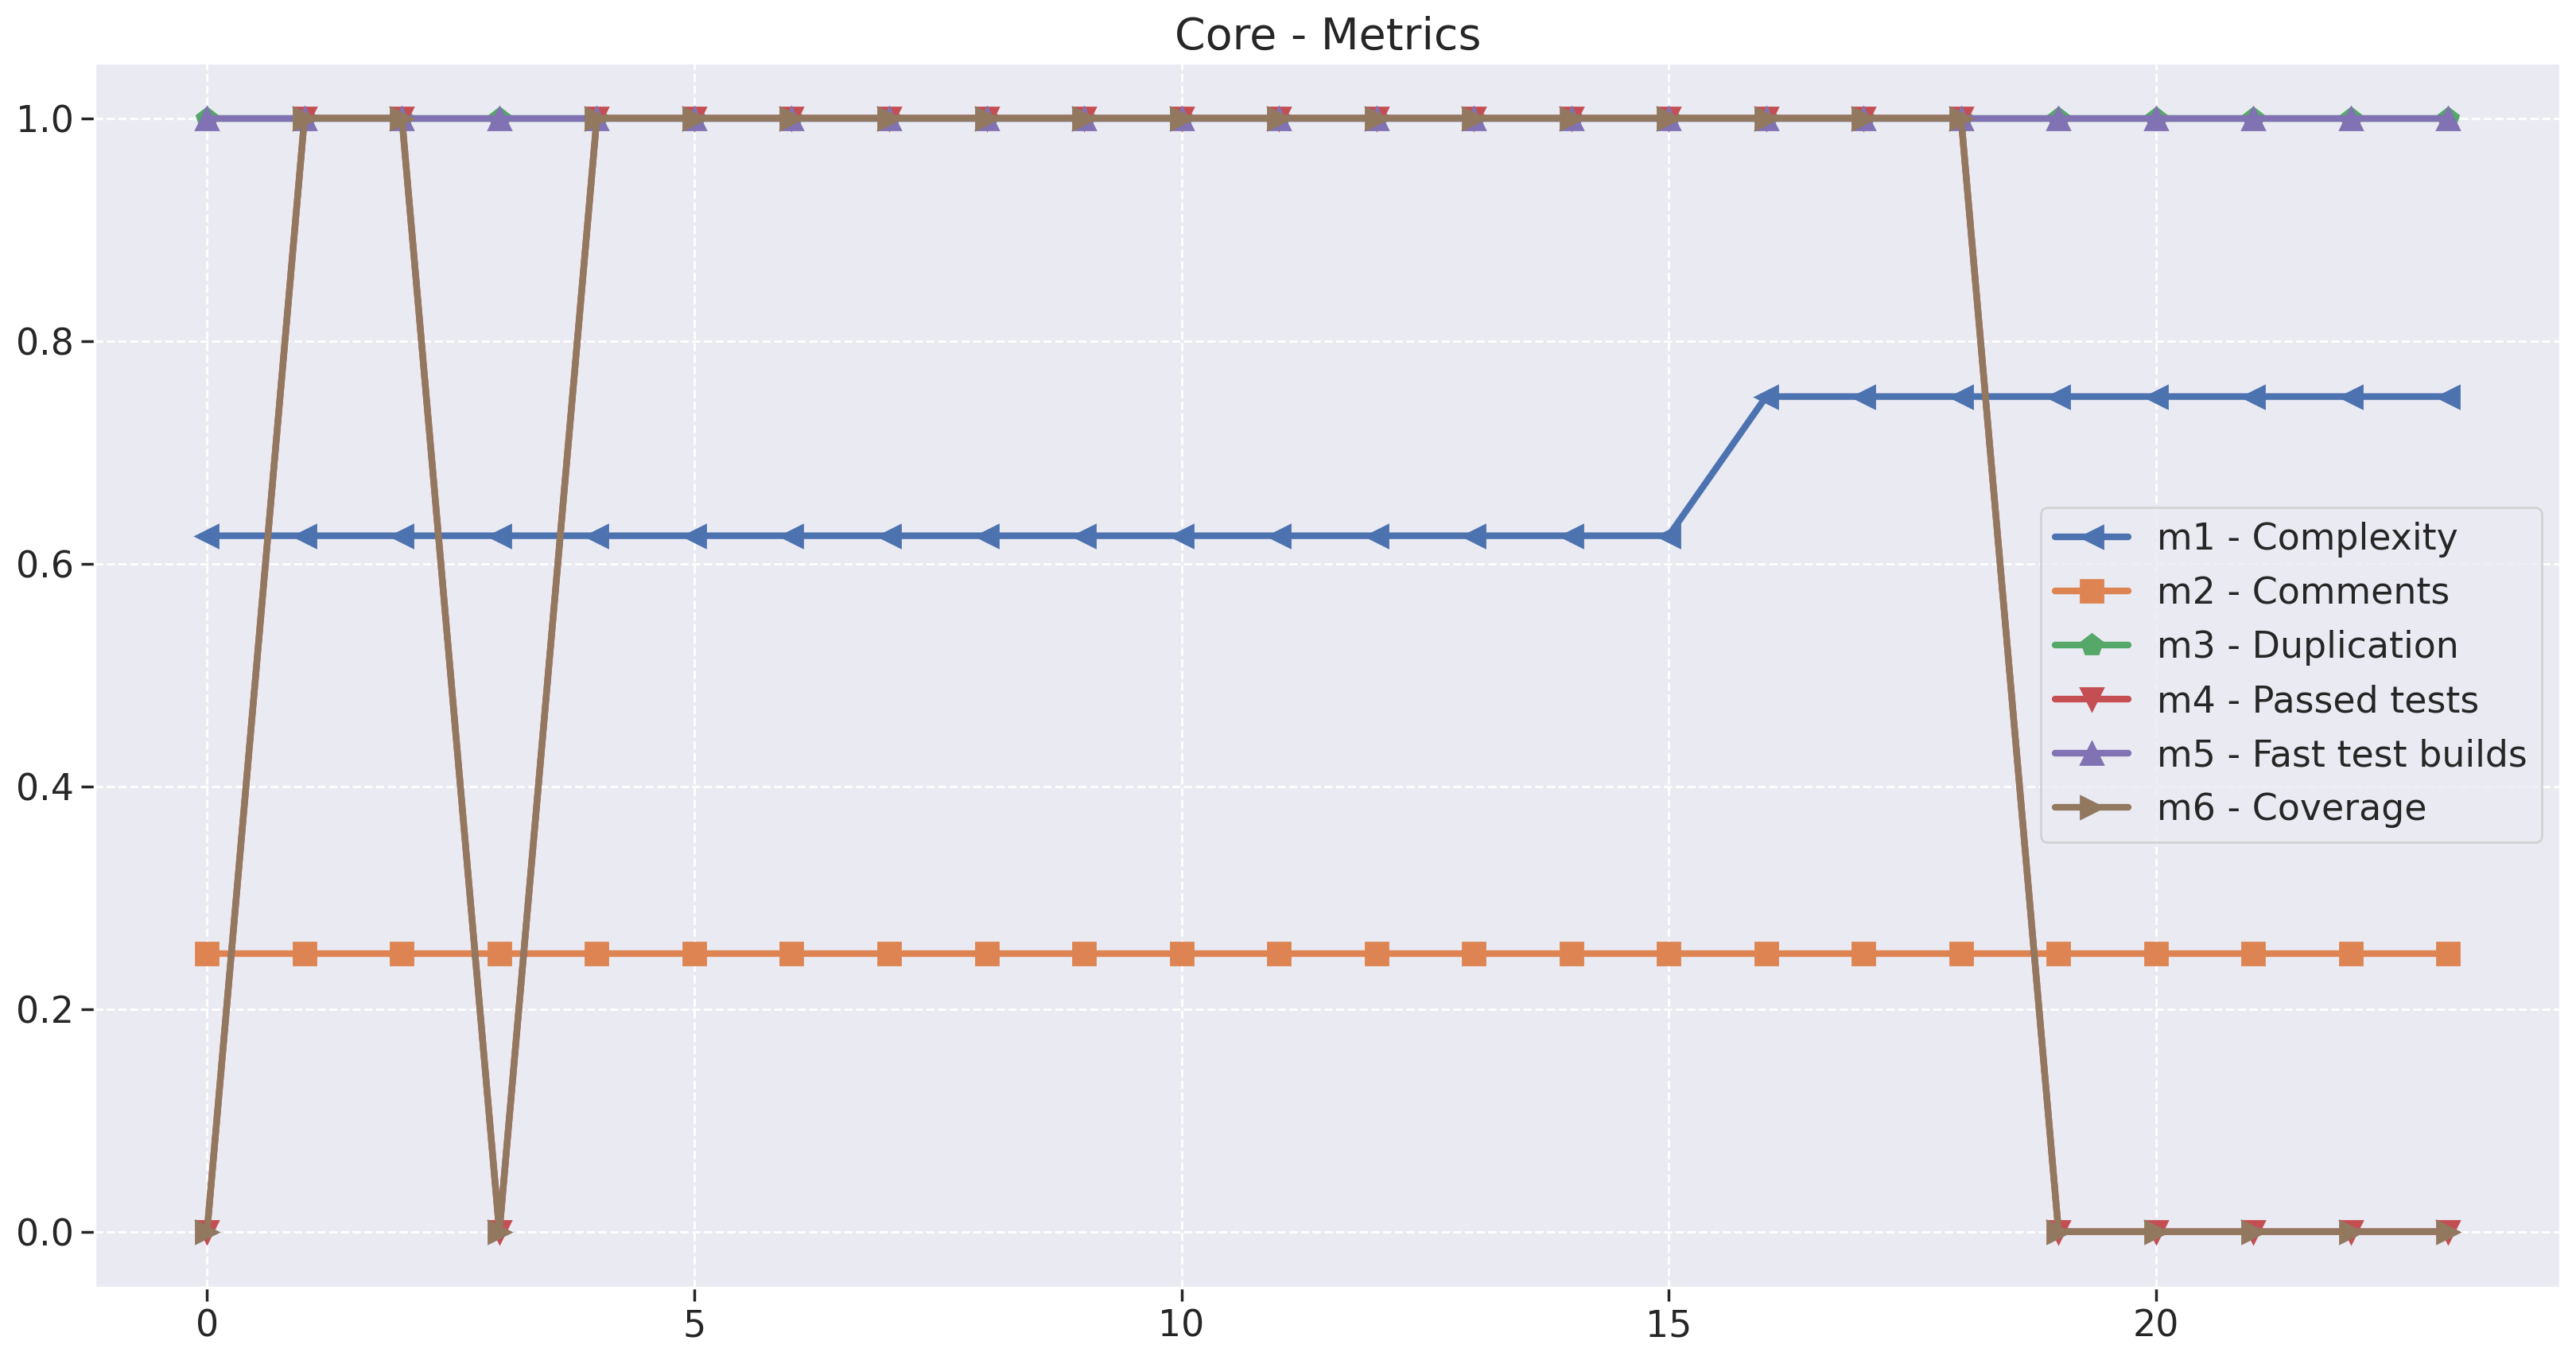

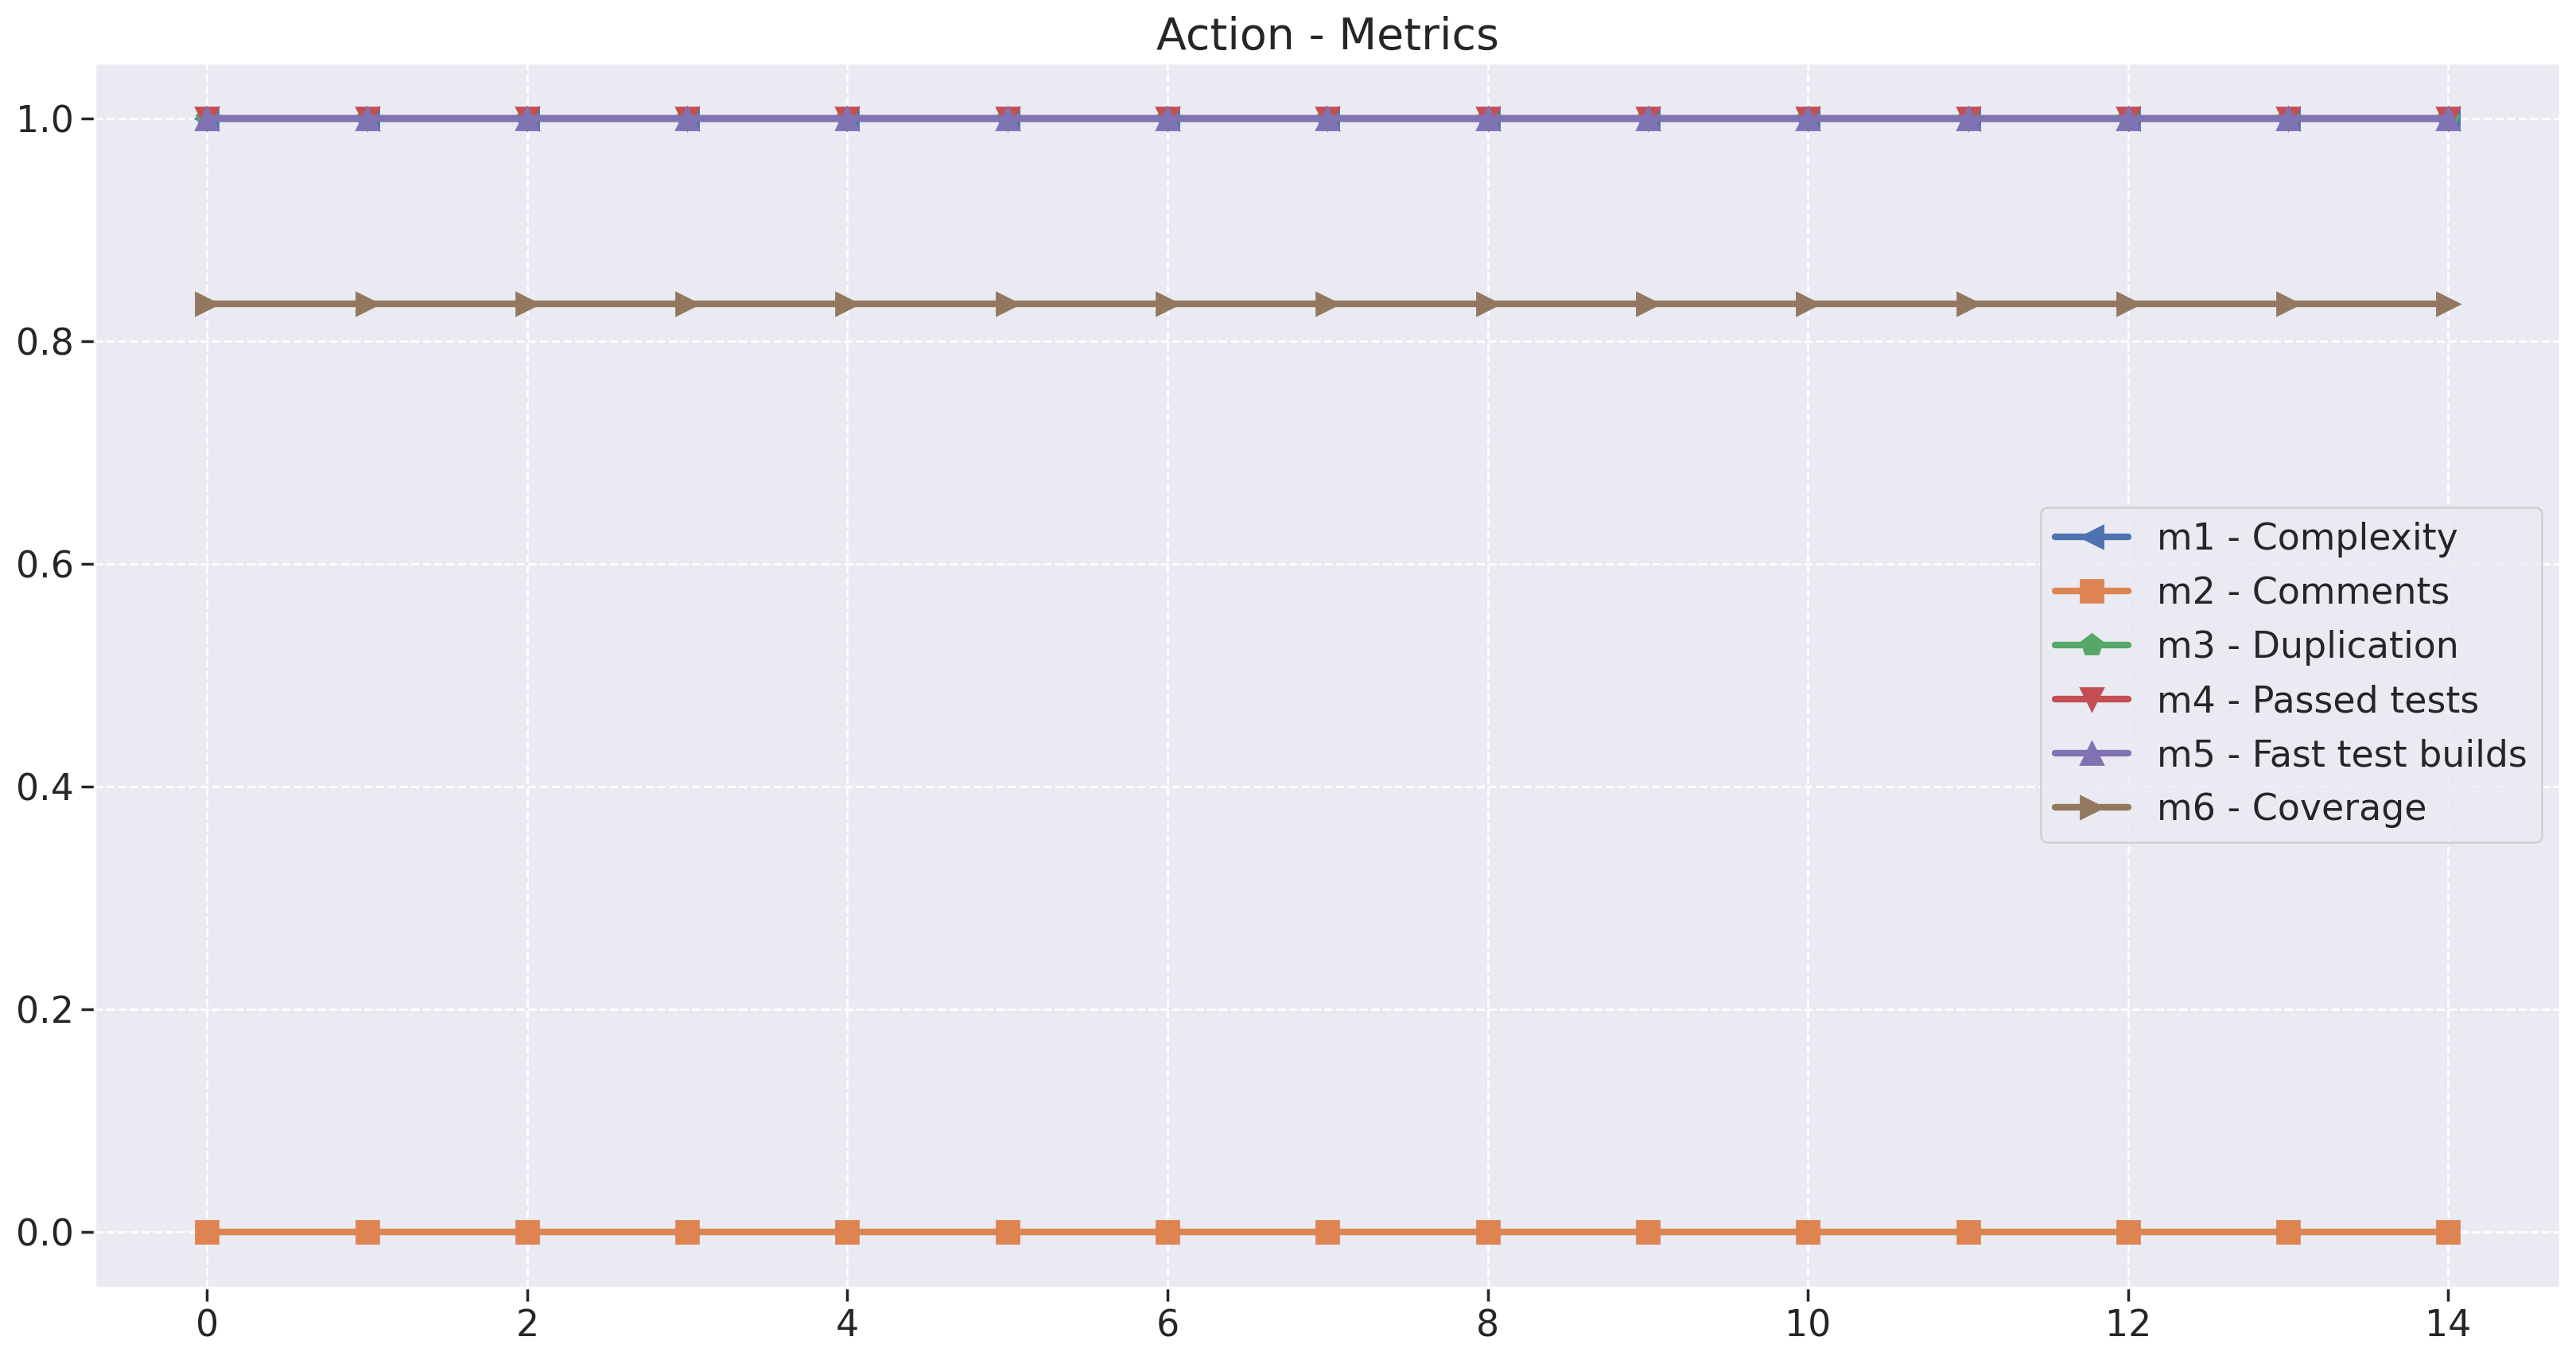

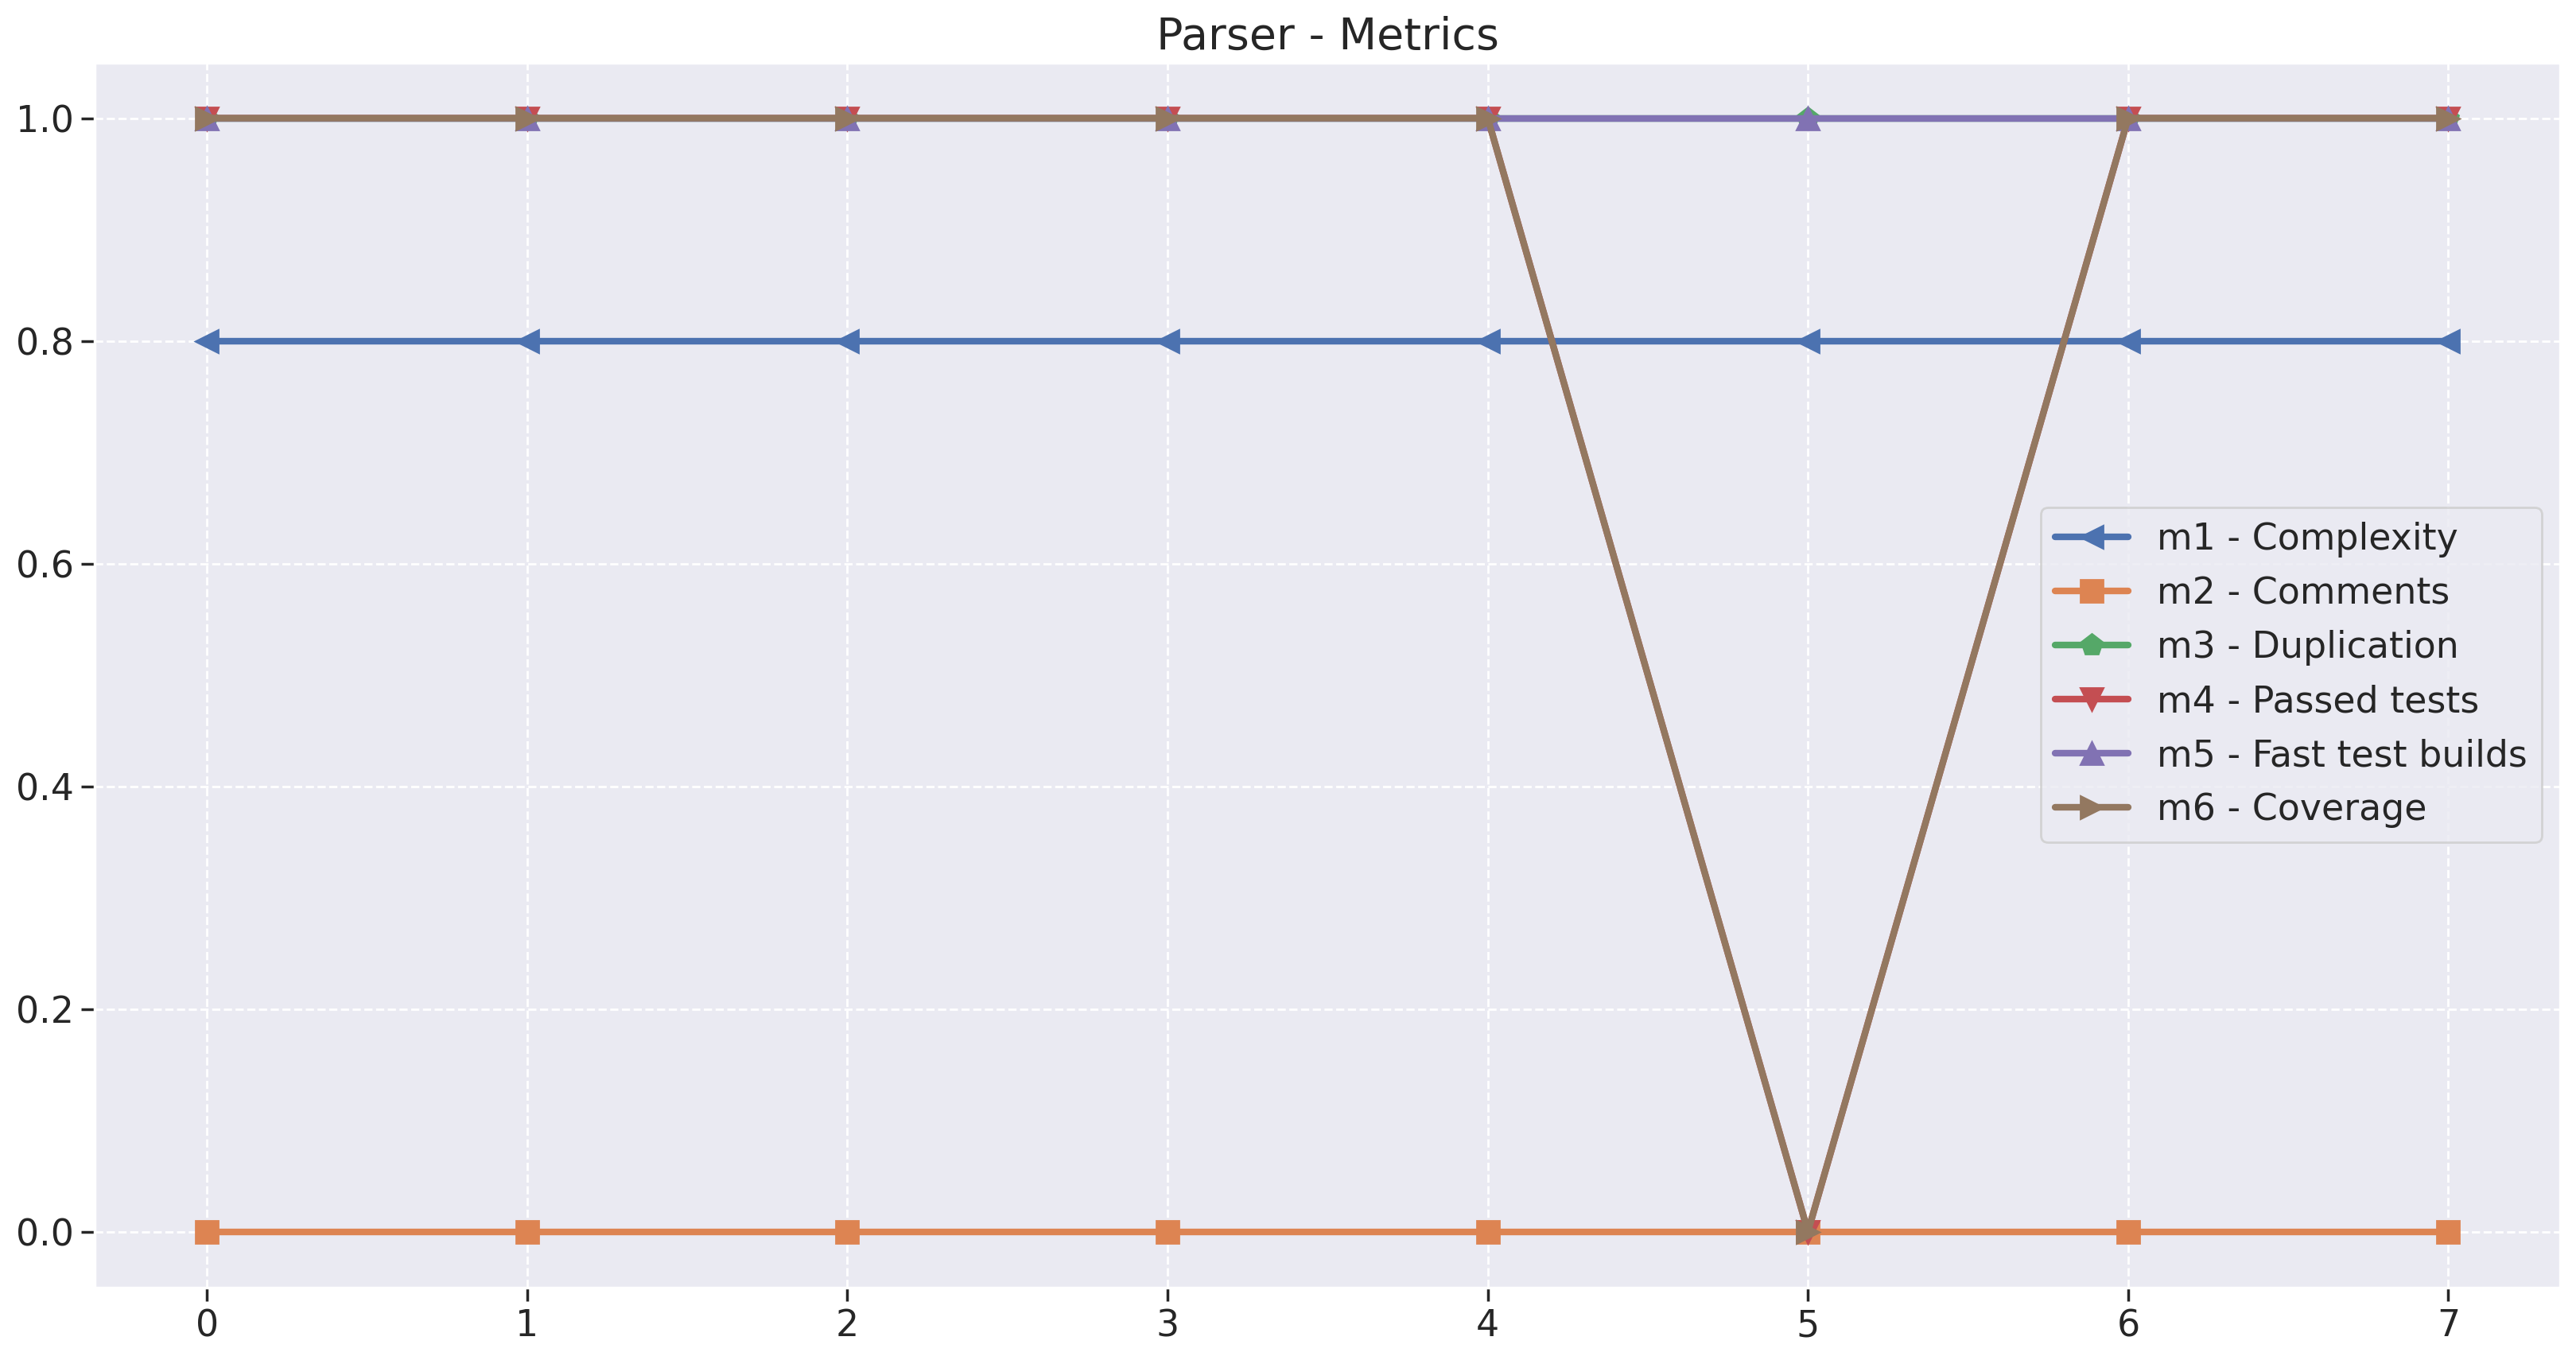

In [23]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [24]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

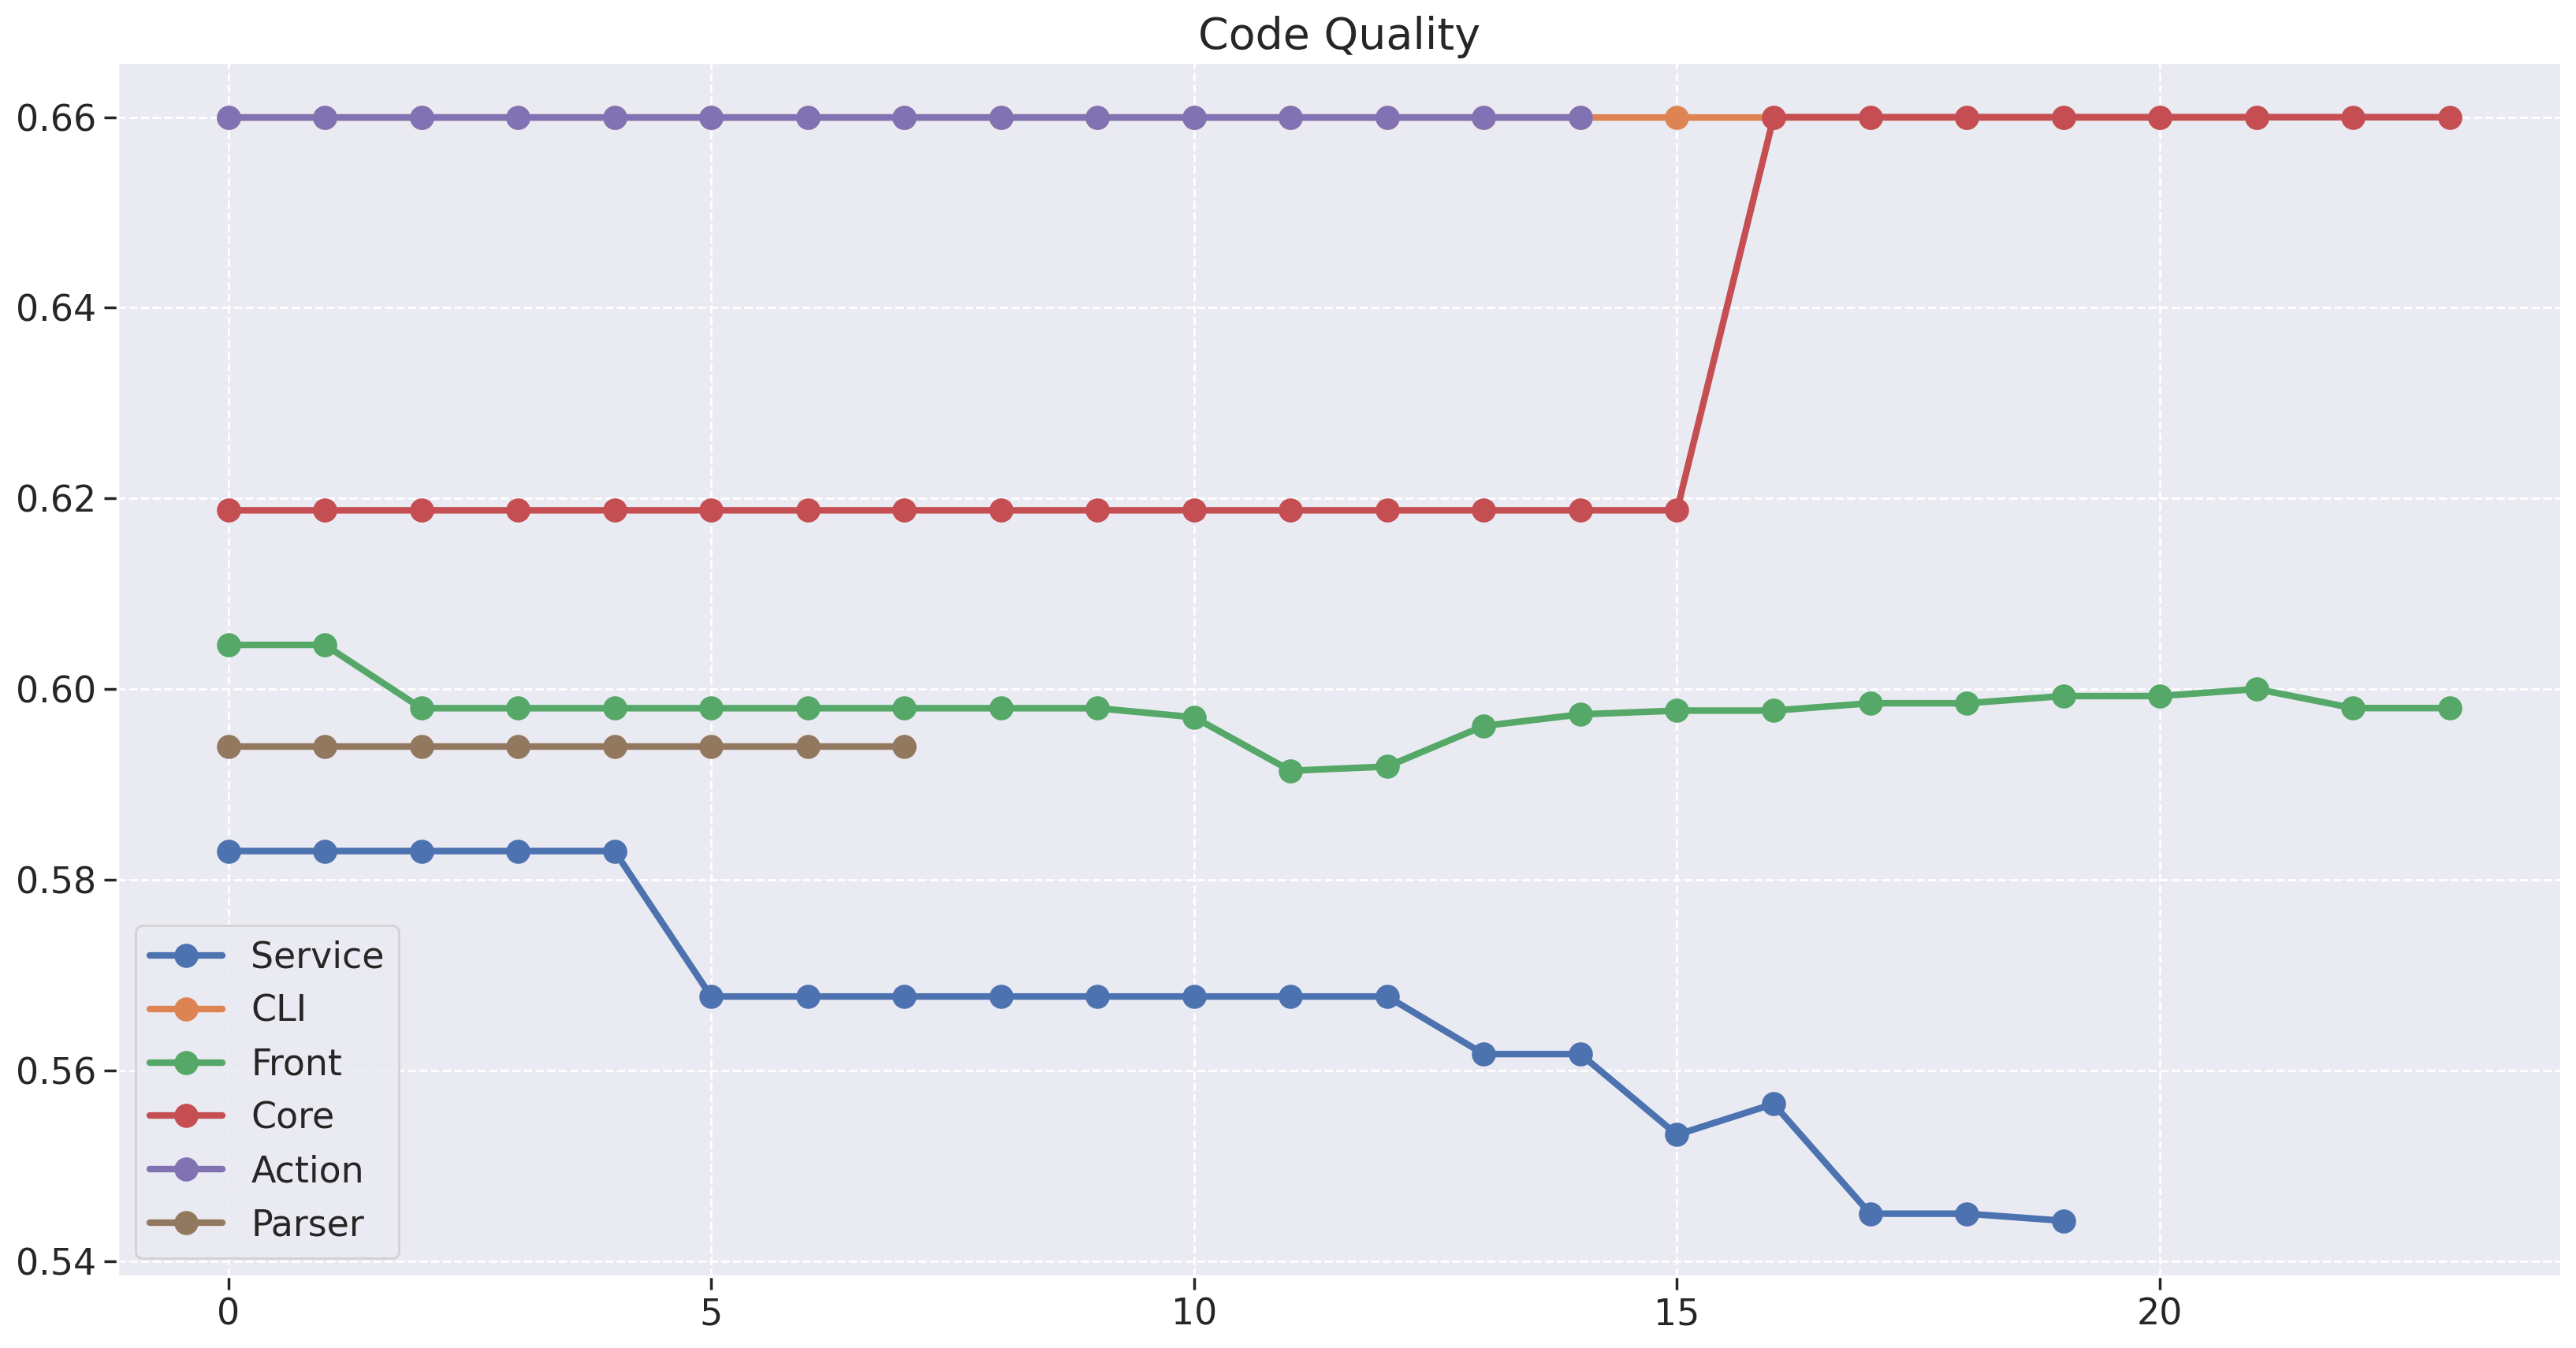

In [25]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

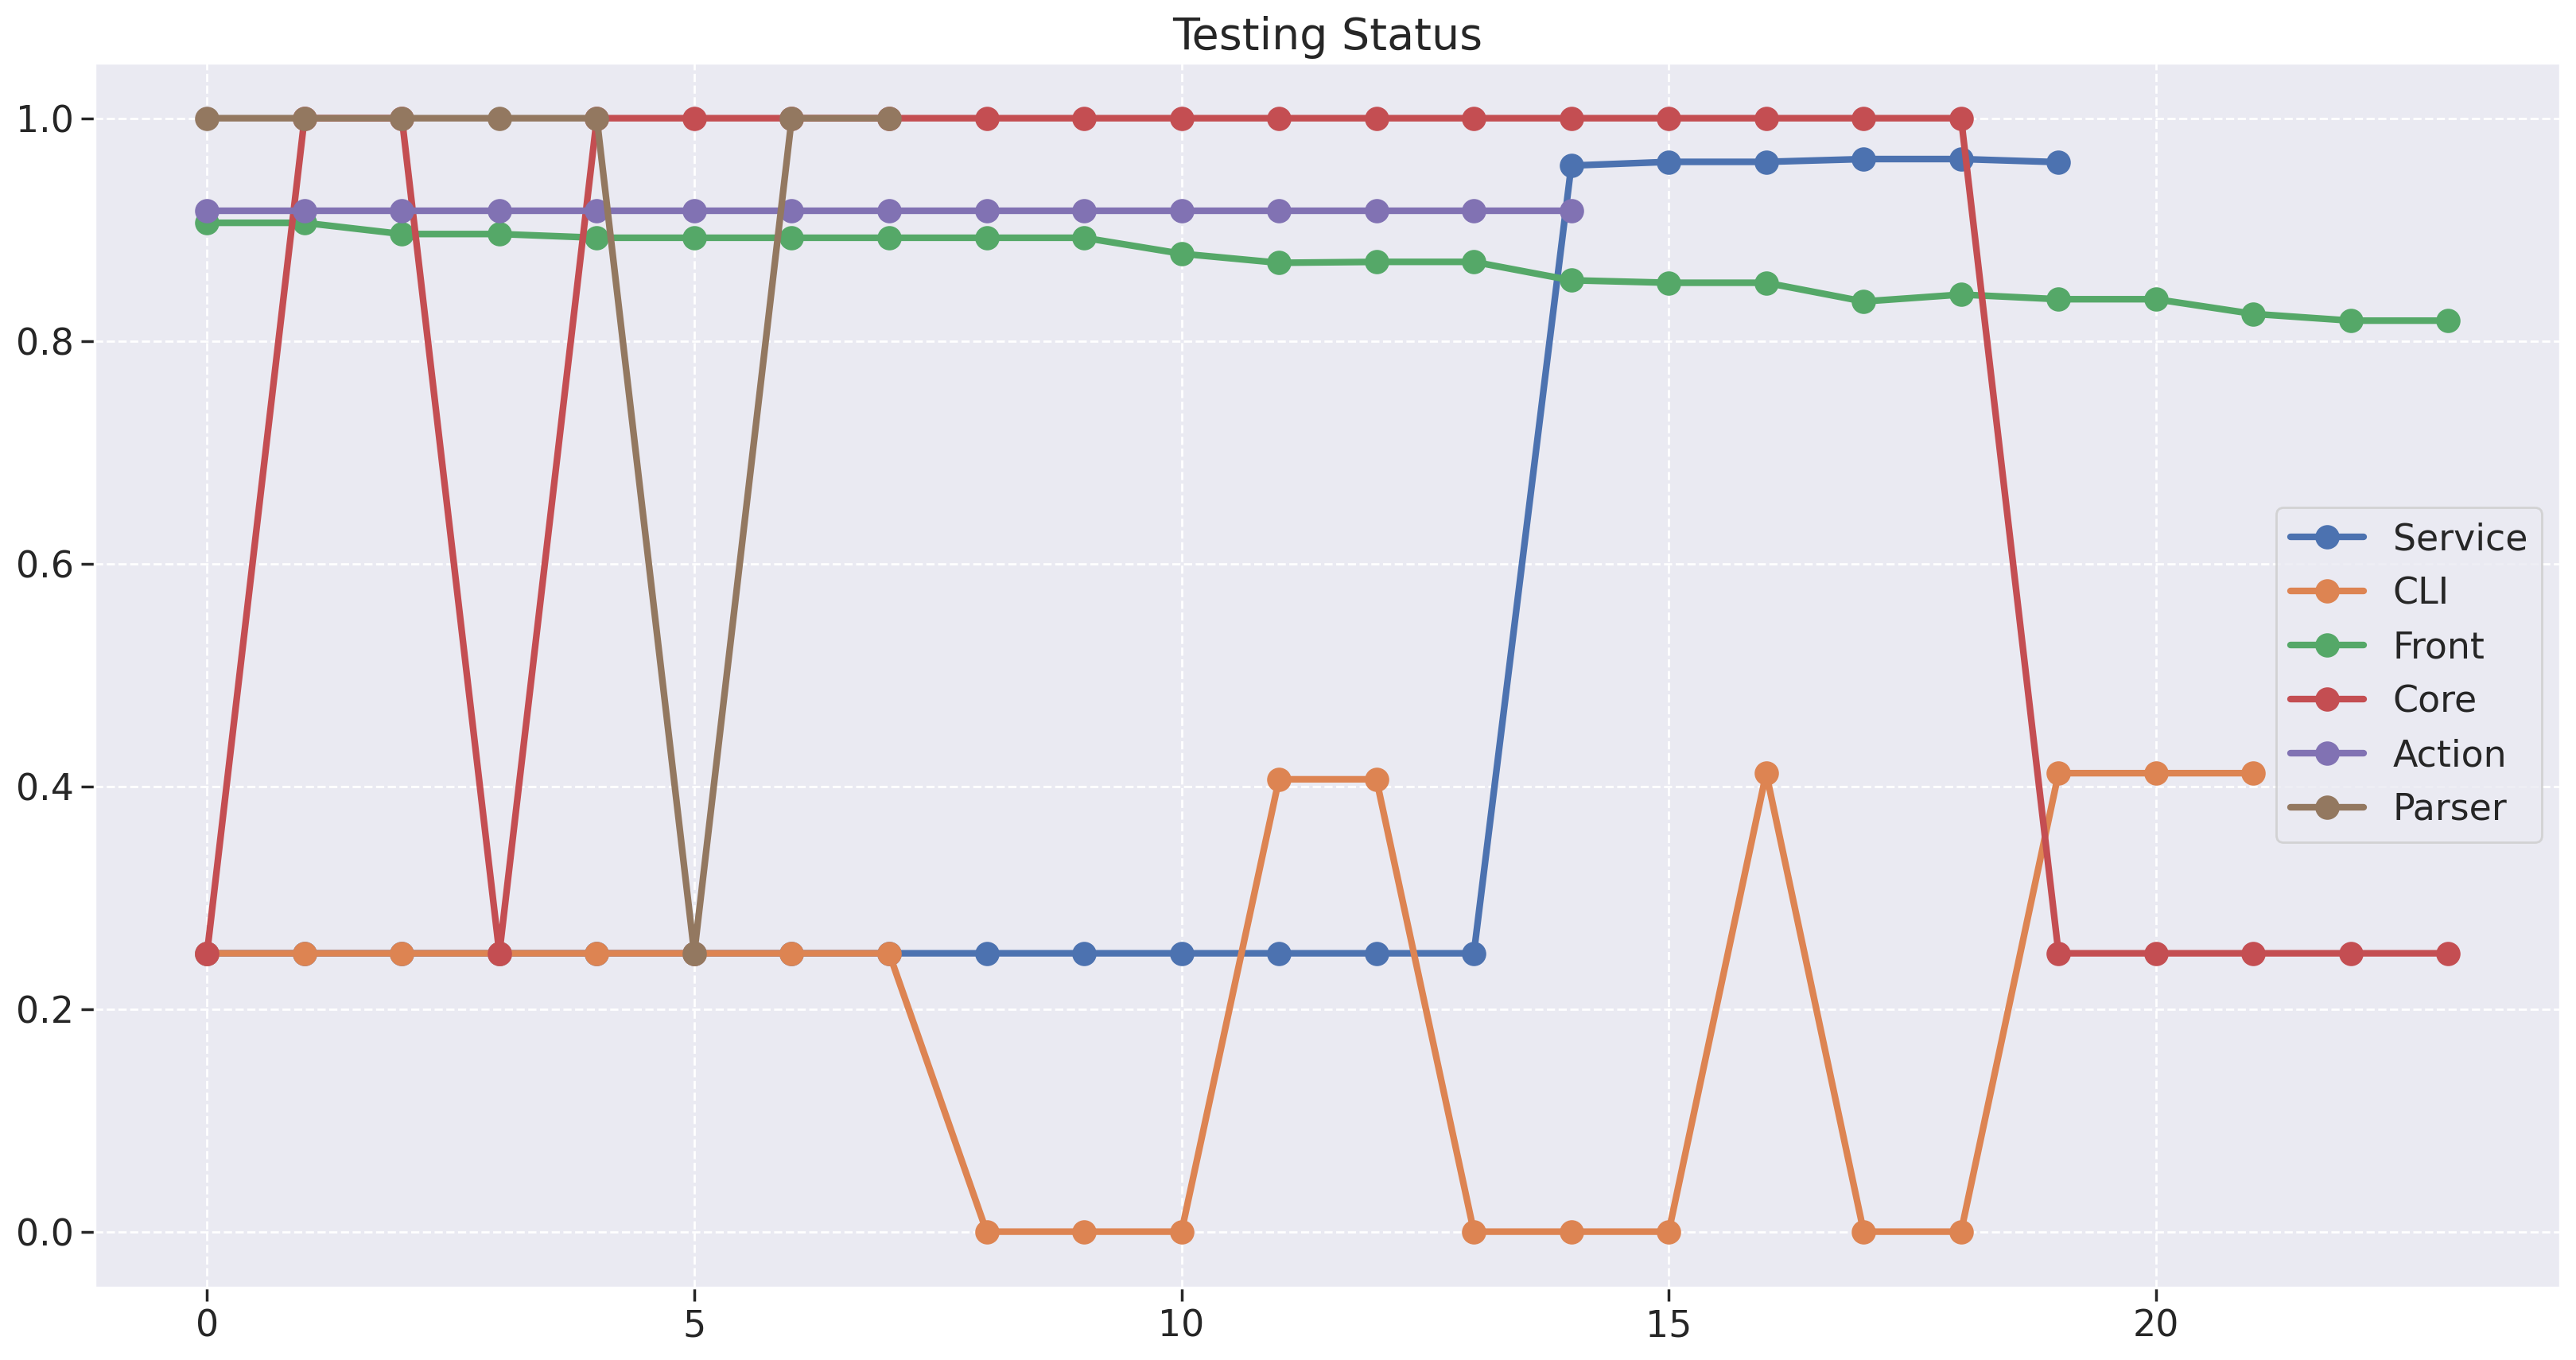

In [26]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [27]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [28]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [29]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

Service
Maintainability Stats
    mean     mode   median      std      var      min    max
0.283104 0.283871 0.283871 0.006407 0.000041 0.272105 0.2915
Reliability Stats
    mean  mode  median      std      var   min      max
0.231654 0.125   0.125 0.167149 0.027939 0.125 0.481651


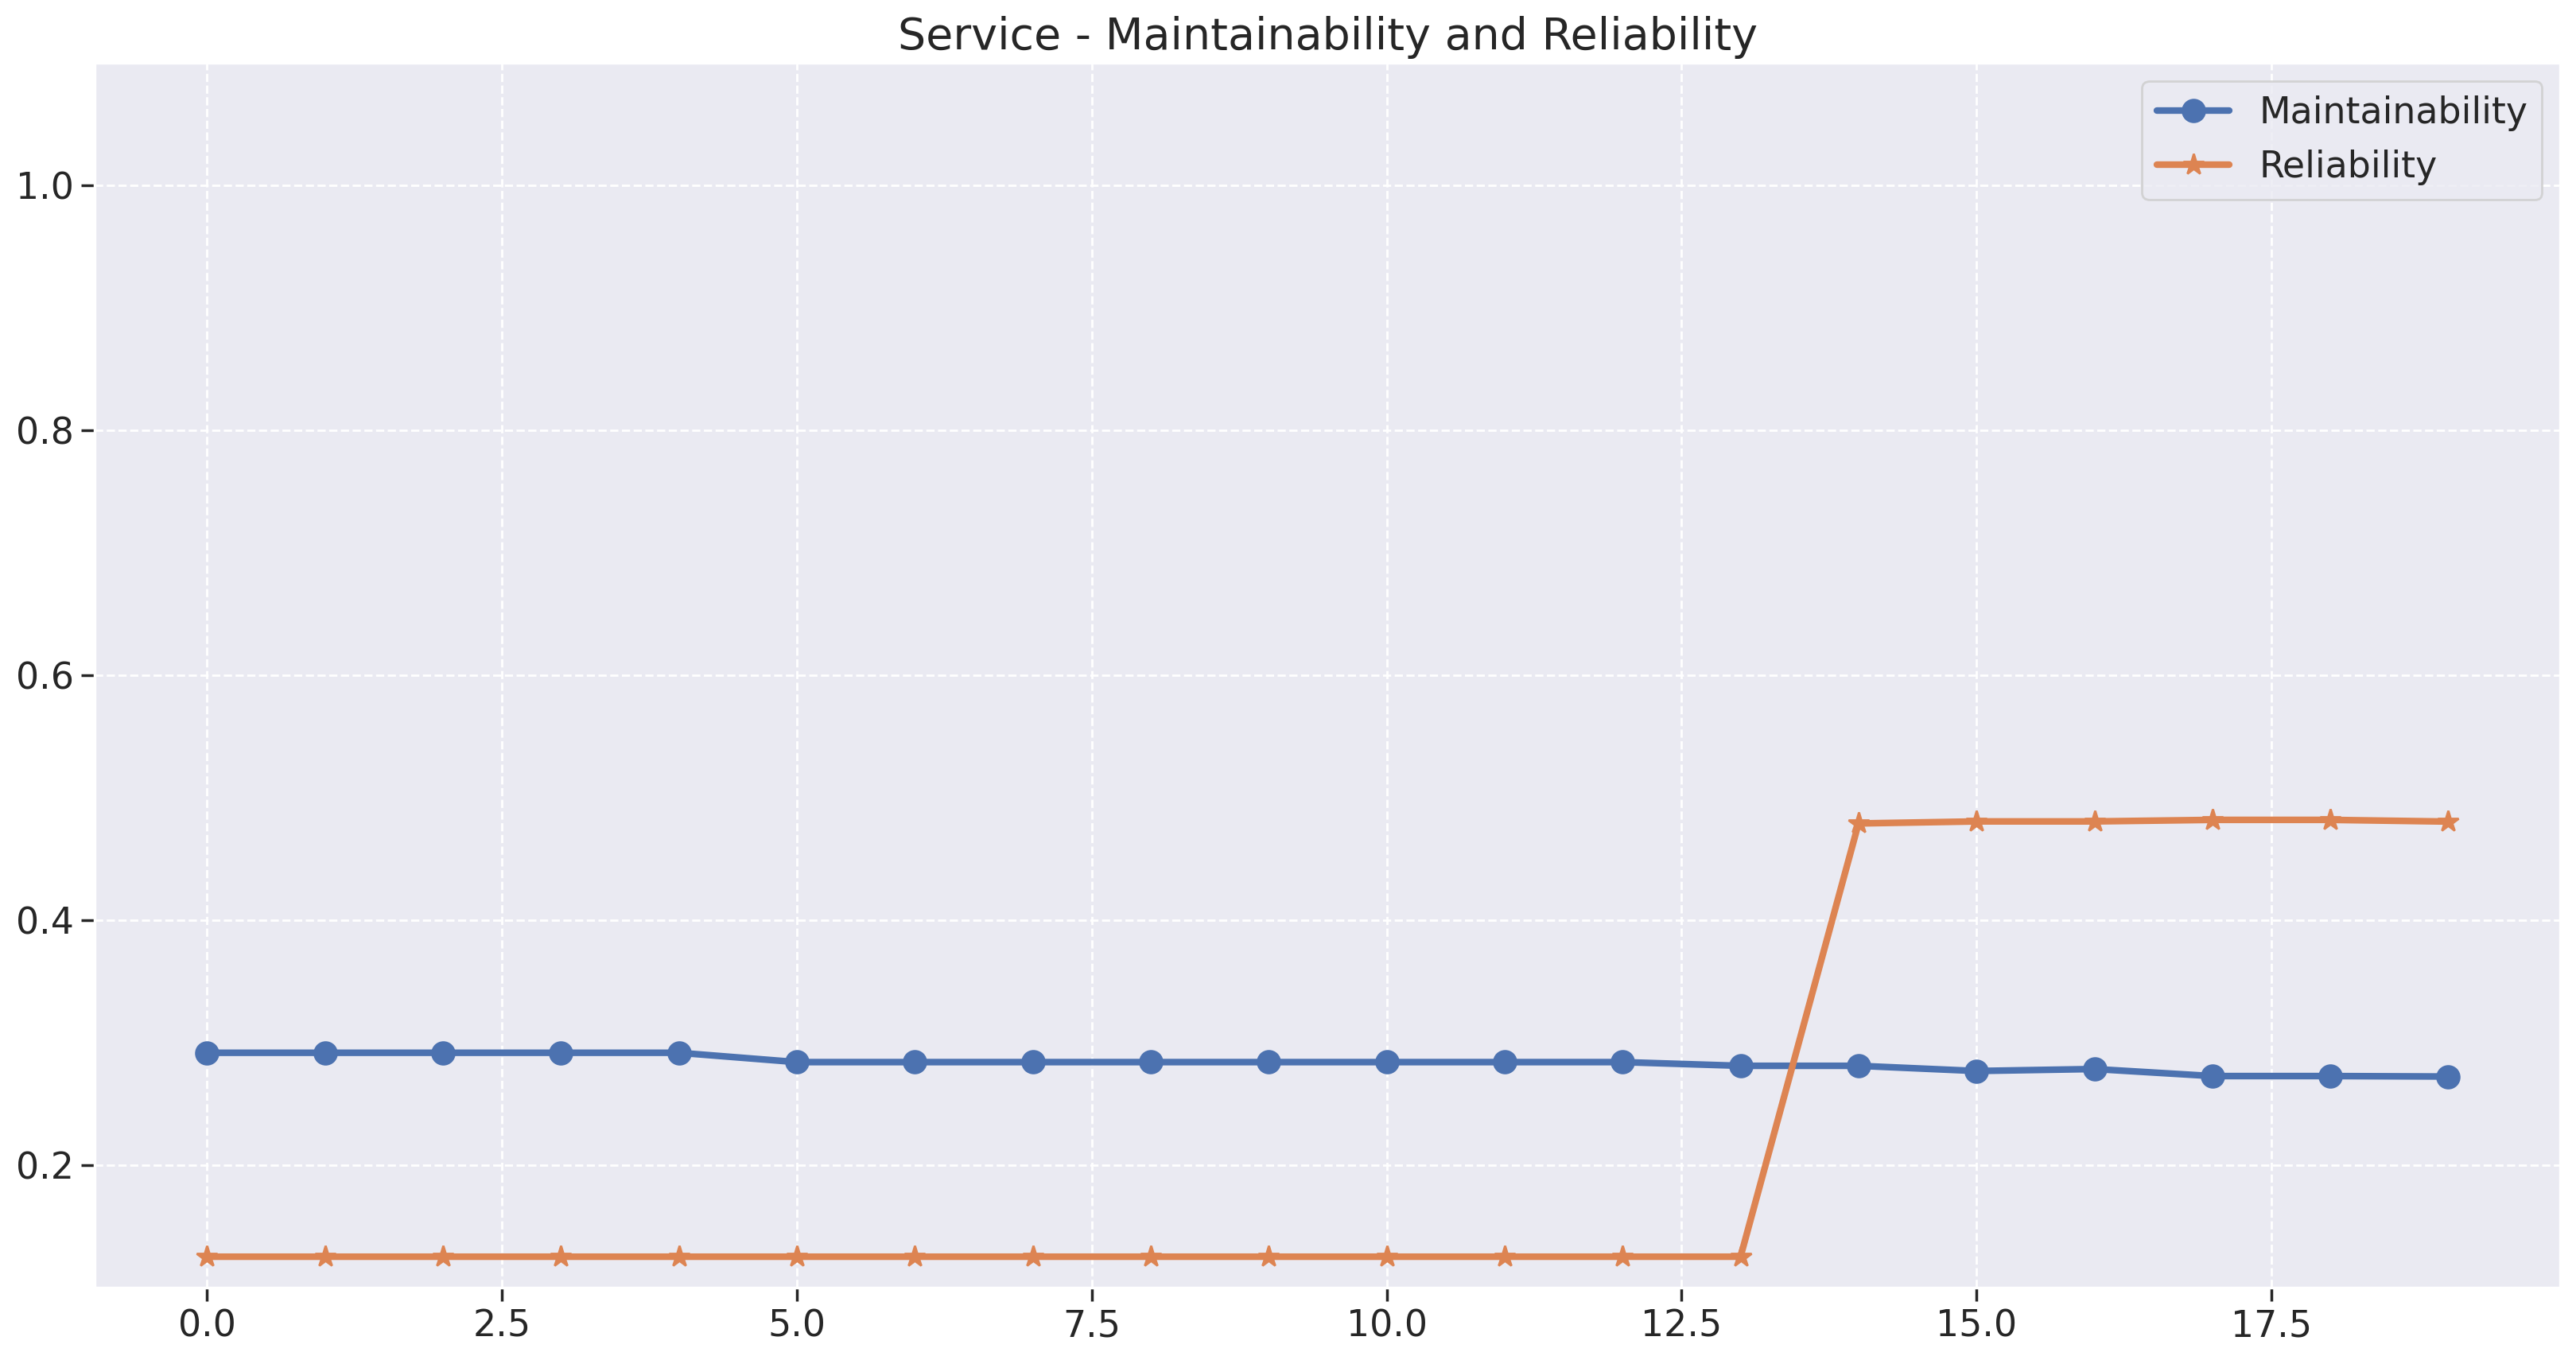

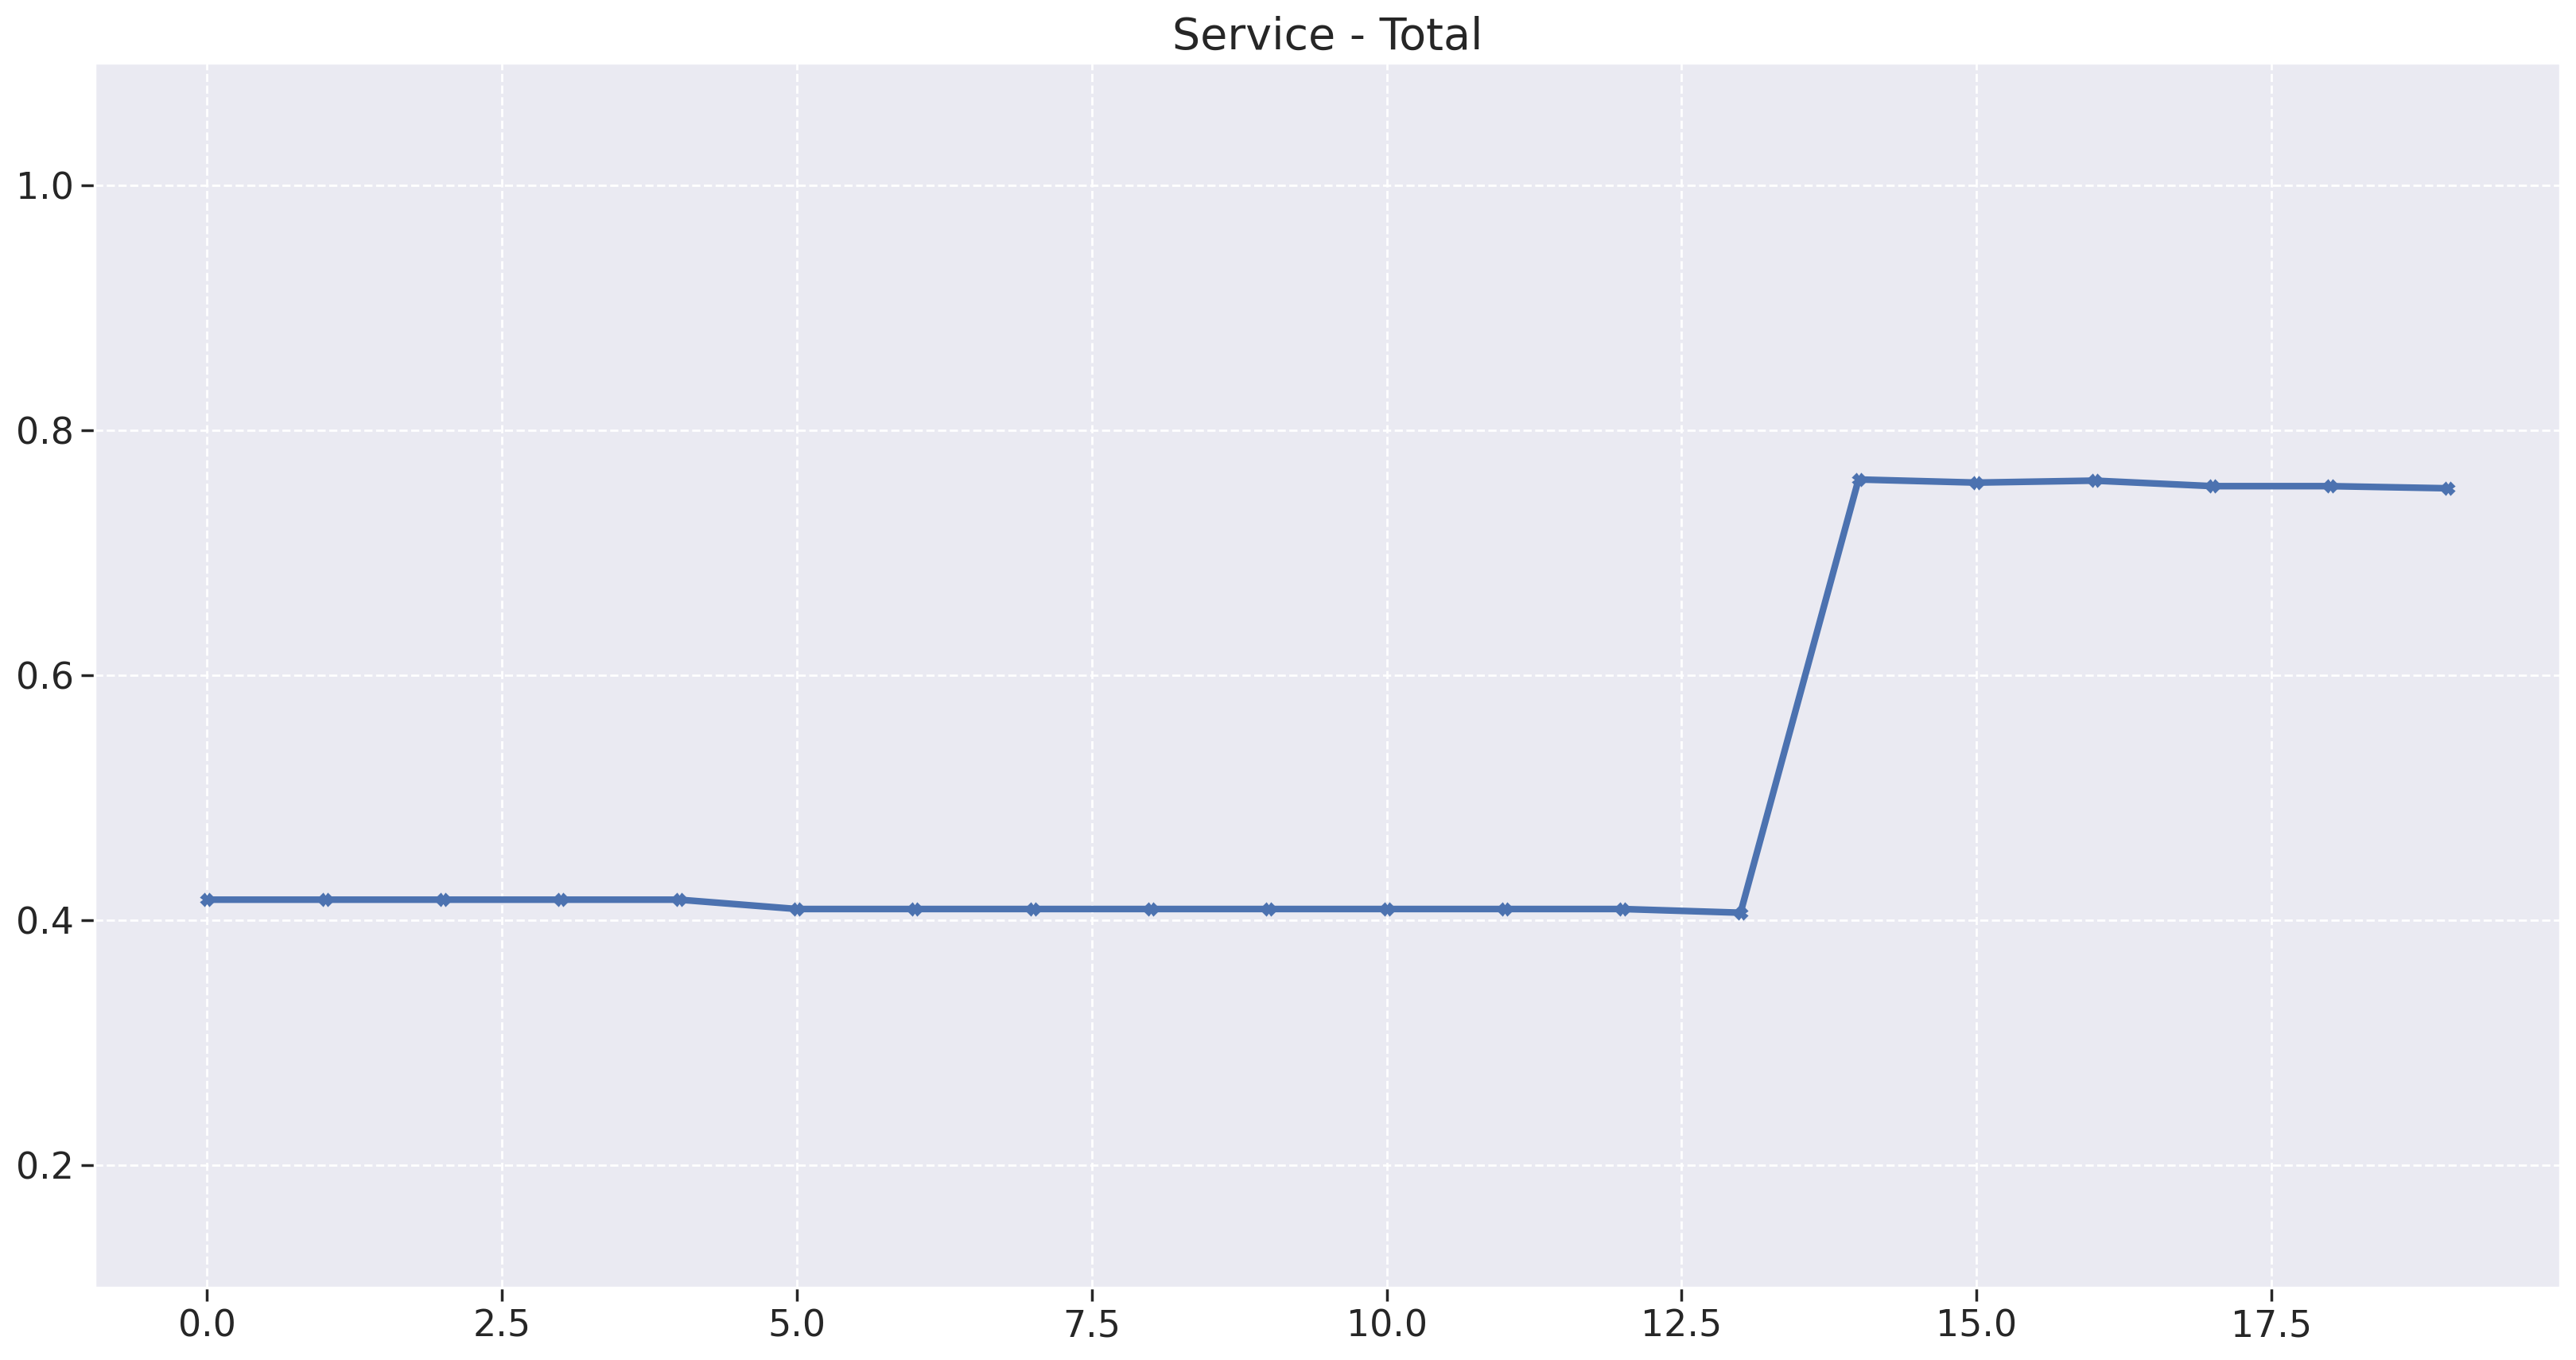

CLI
Maintainability Stats
 mean  mode  median  std  var  min  max
 0.33  0.33    0.33  0.0  0.0 0.33 0.33
Reliability Stats
    mean  mode  median      std      var  min      max
0.101354 0.000   0.125 0.084817 0.007194  0.0 0.205882
0.101354 0.125   0.125 0.084817 0.007194  0.0 0.205882


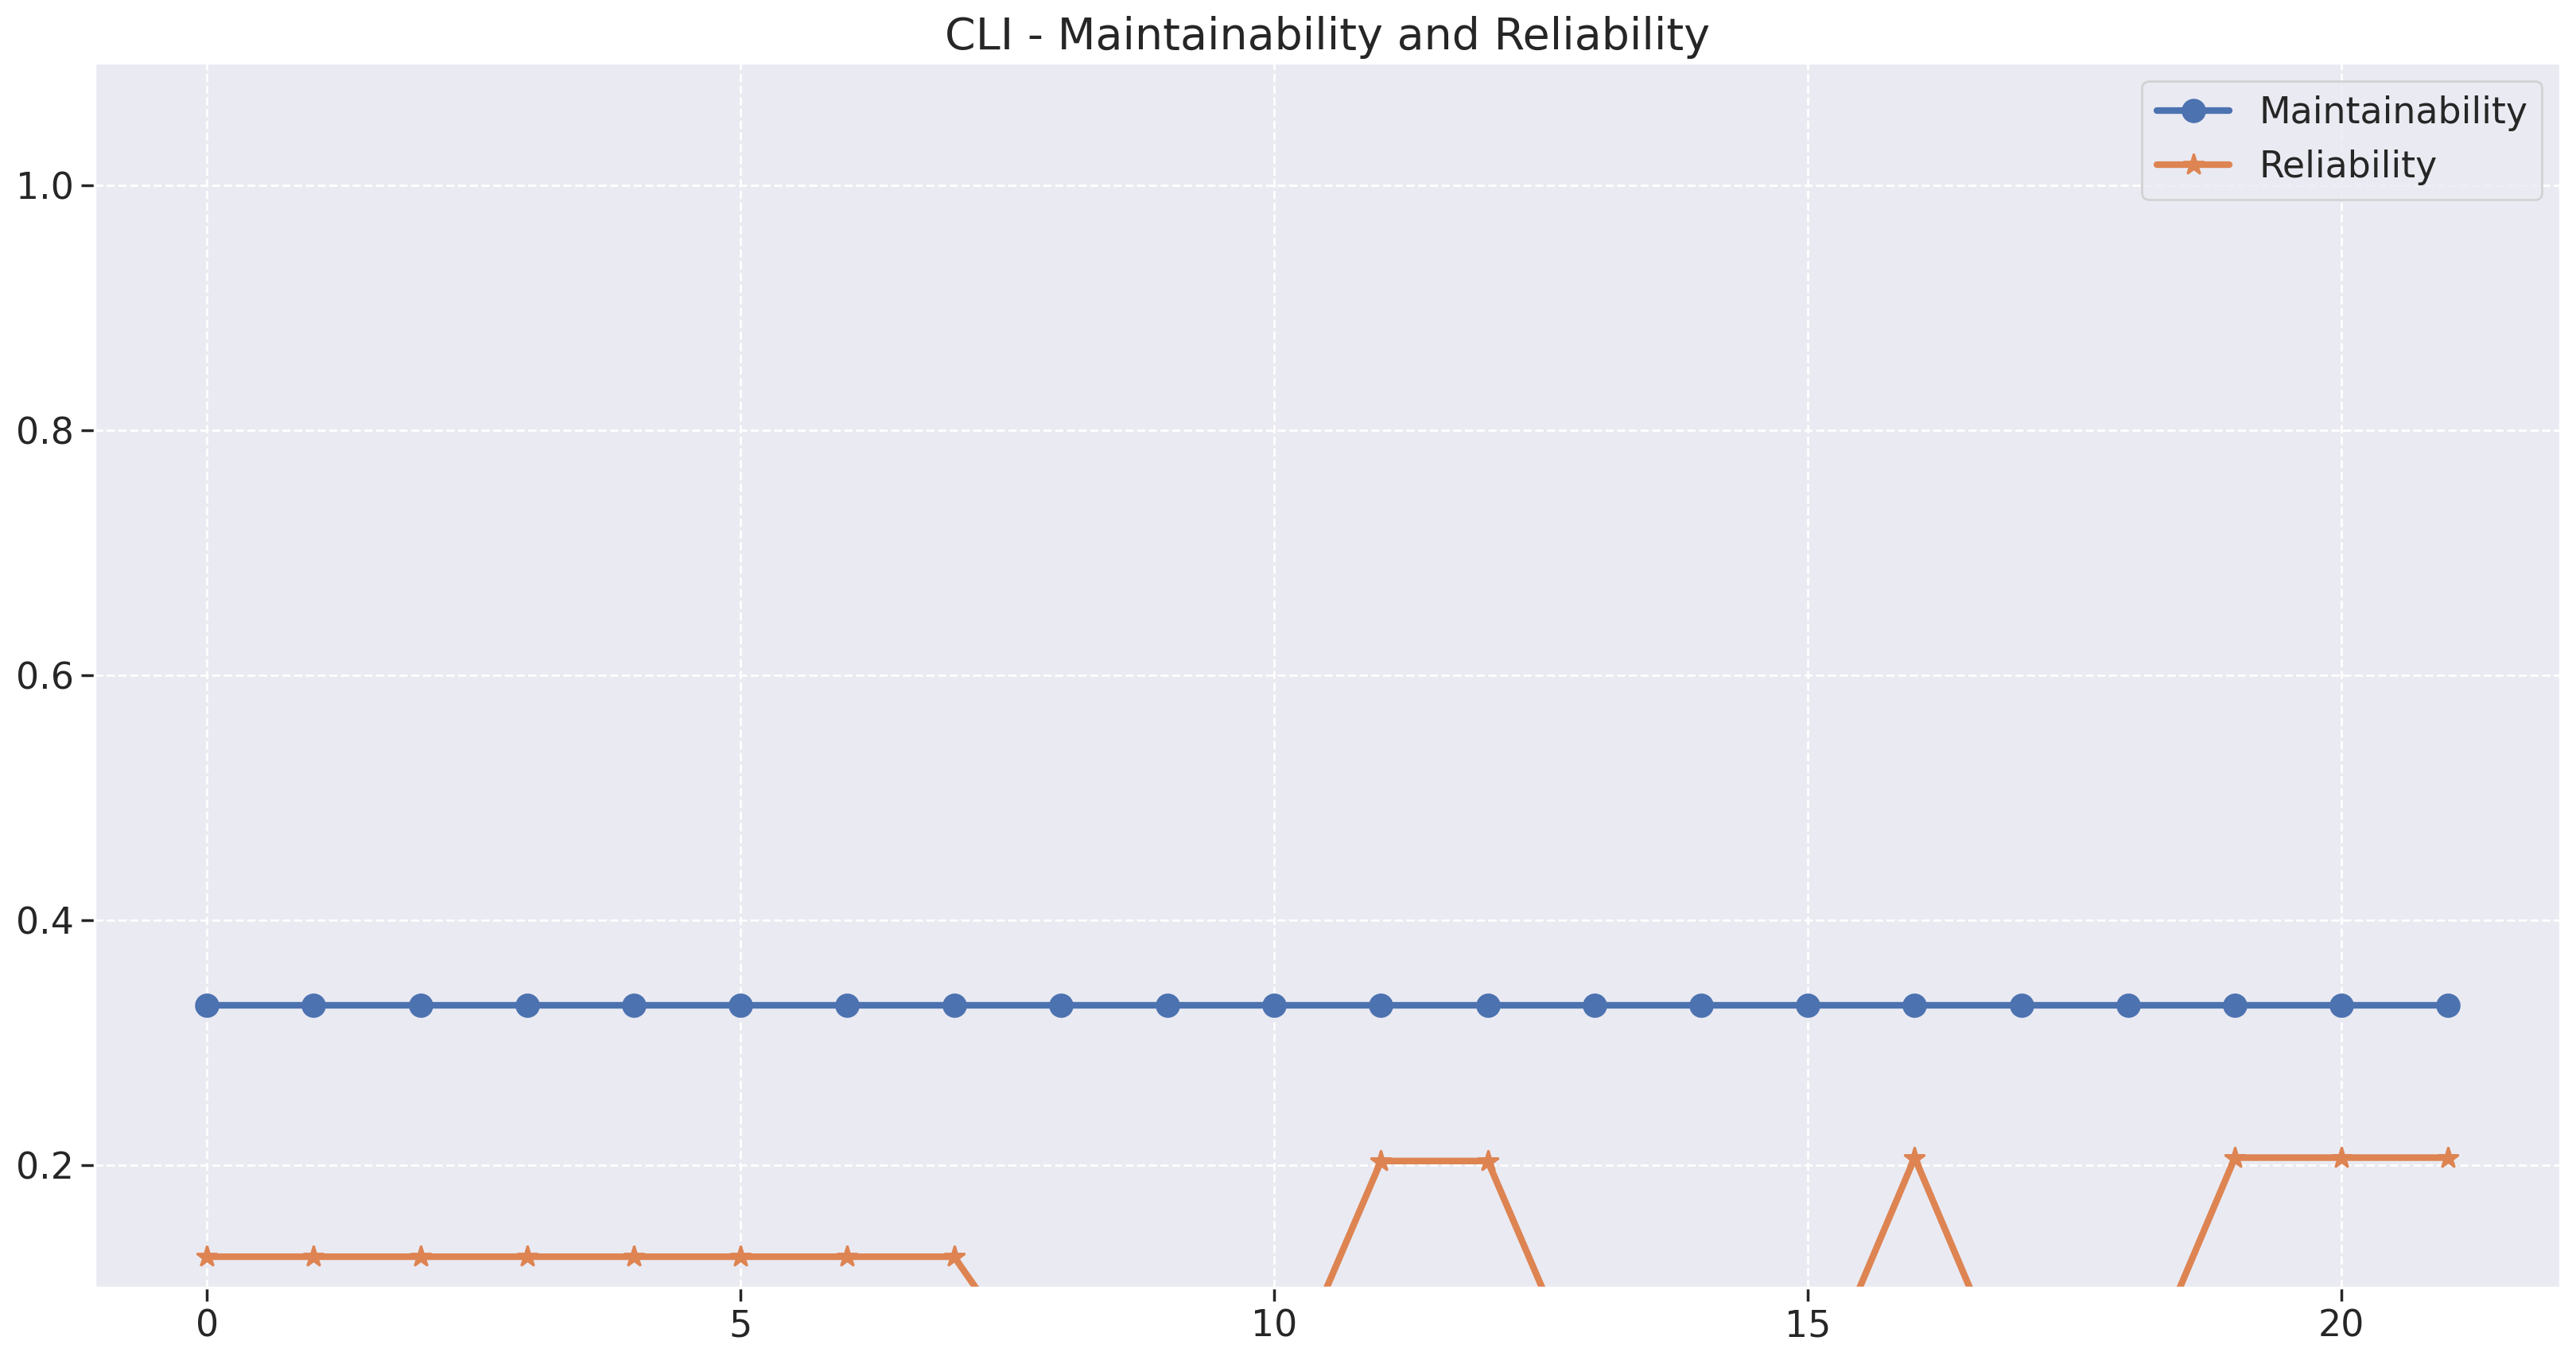

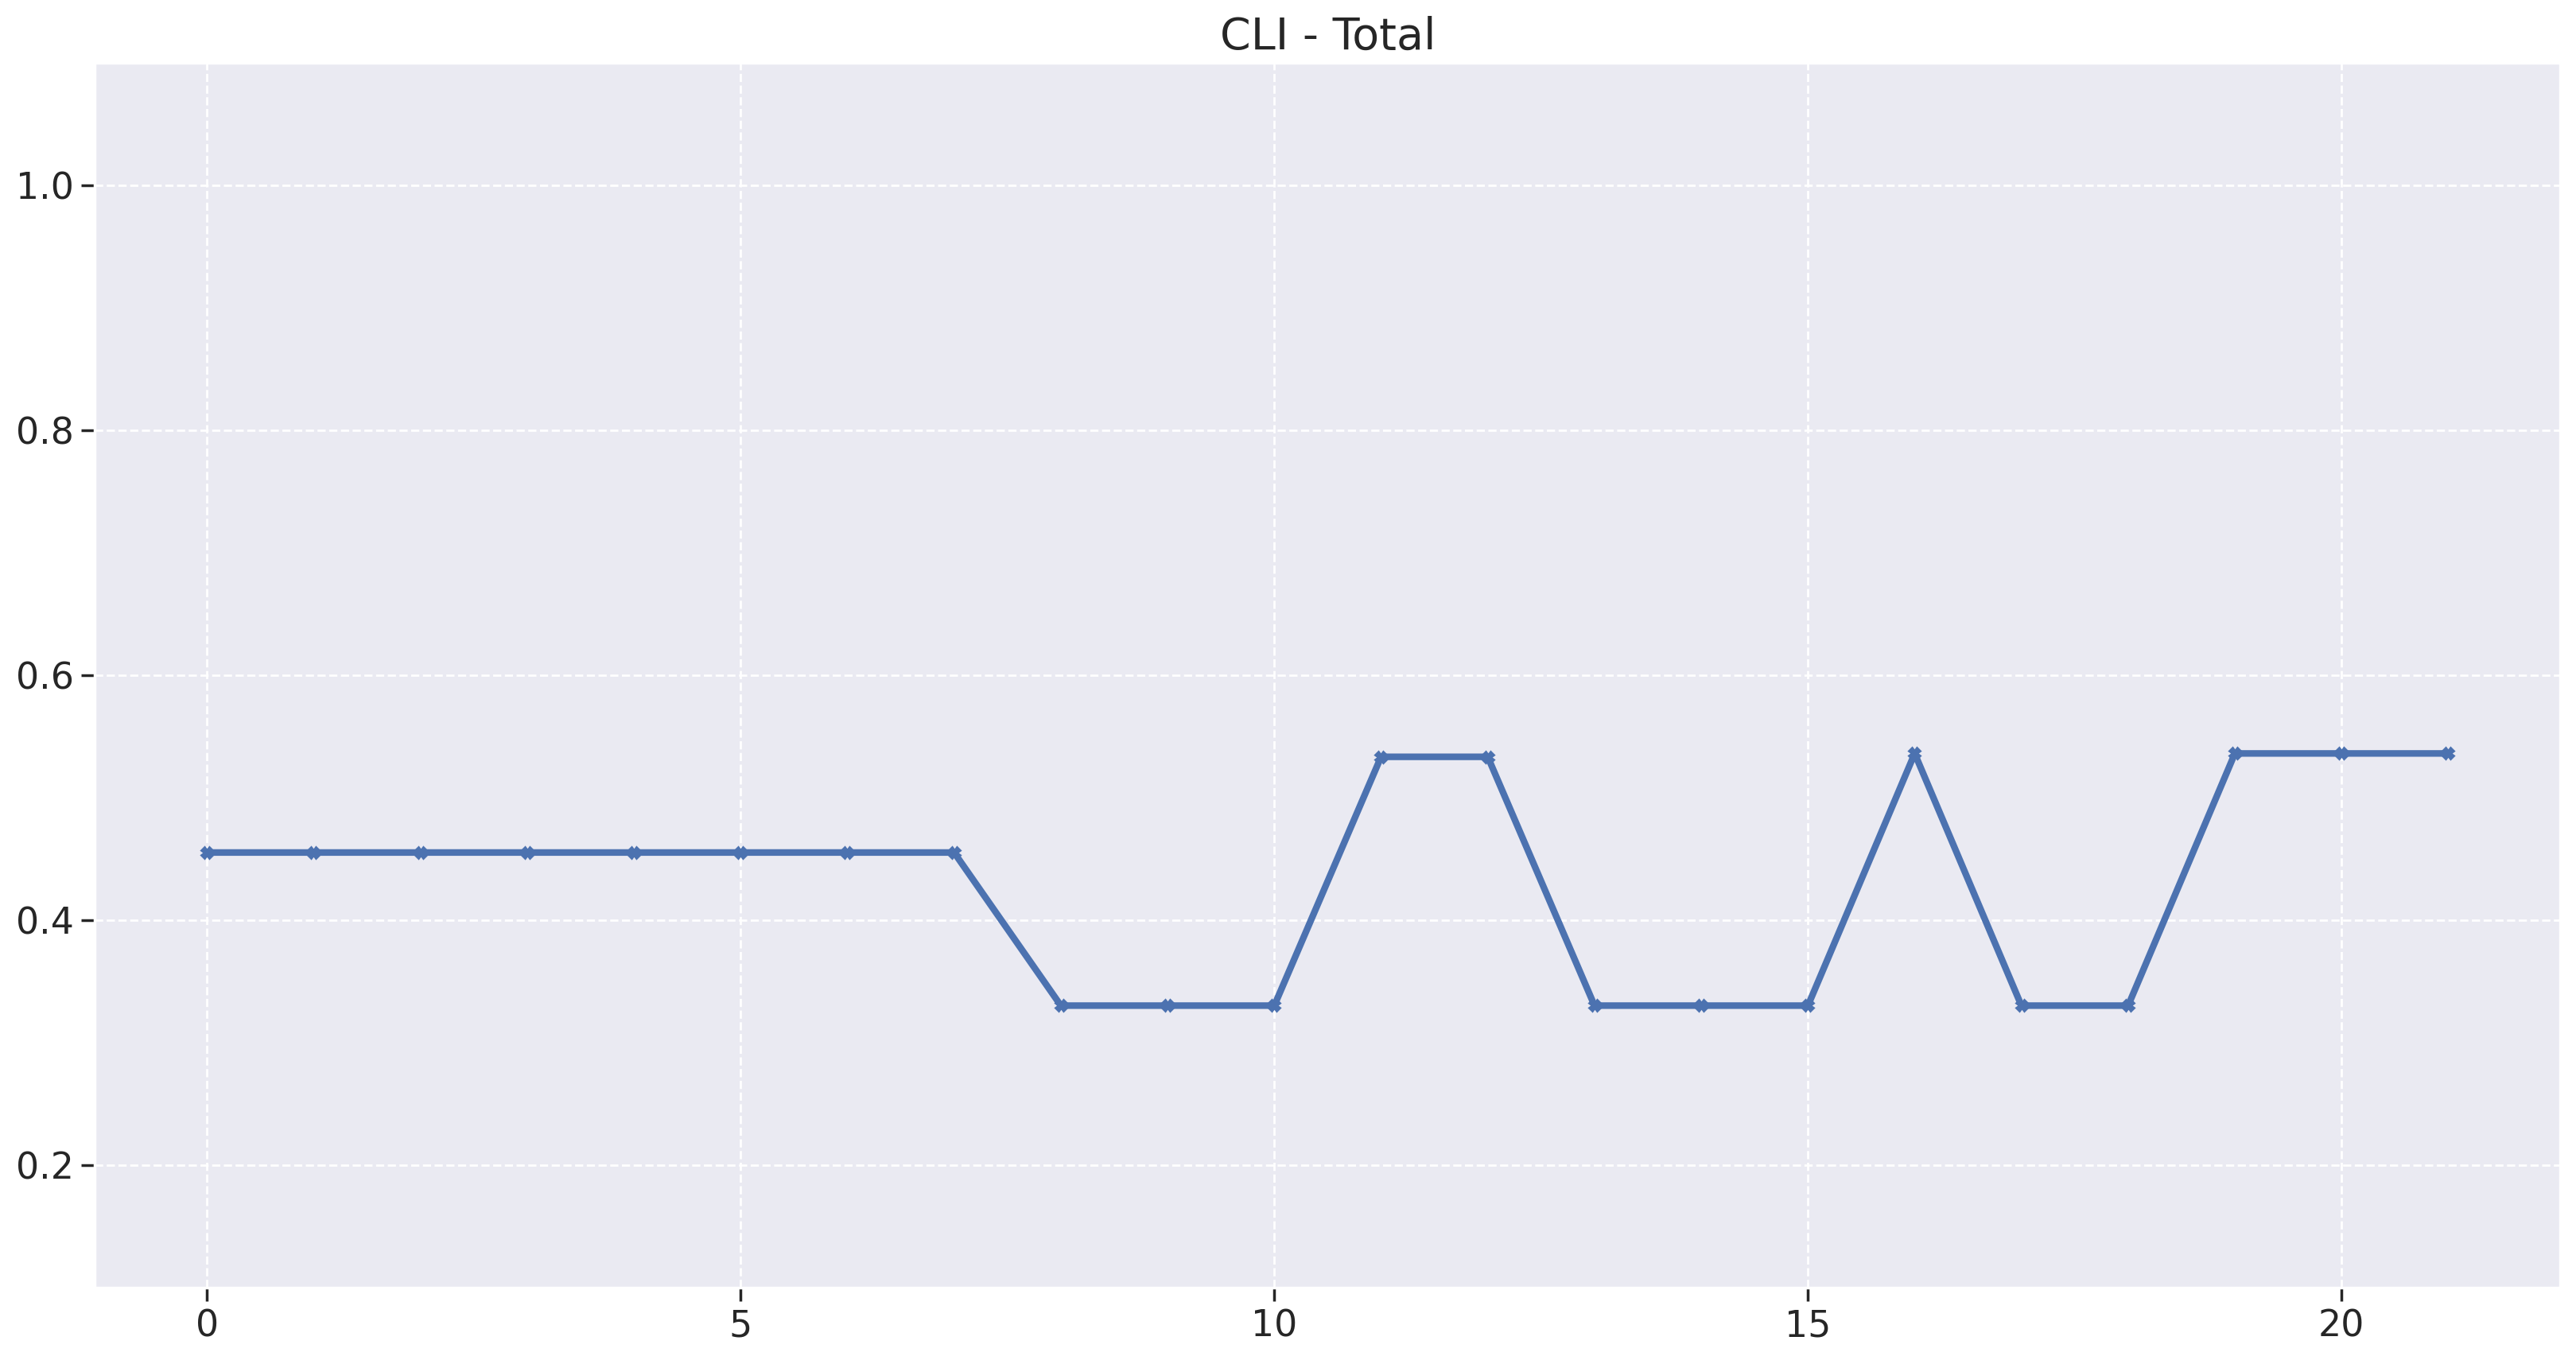

Front
Maintainability Stats
    mean     mode   median      std      var      min      max
0.299041 0.298993 0.298993 0.001404 0.000002 0.295714 0.302315
Reliability Stats
    mean     mode   median      std      var      min     max
0.433779 0.446309 0.435484 0.014525 0.000211 0.409091 0.45302


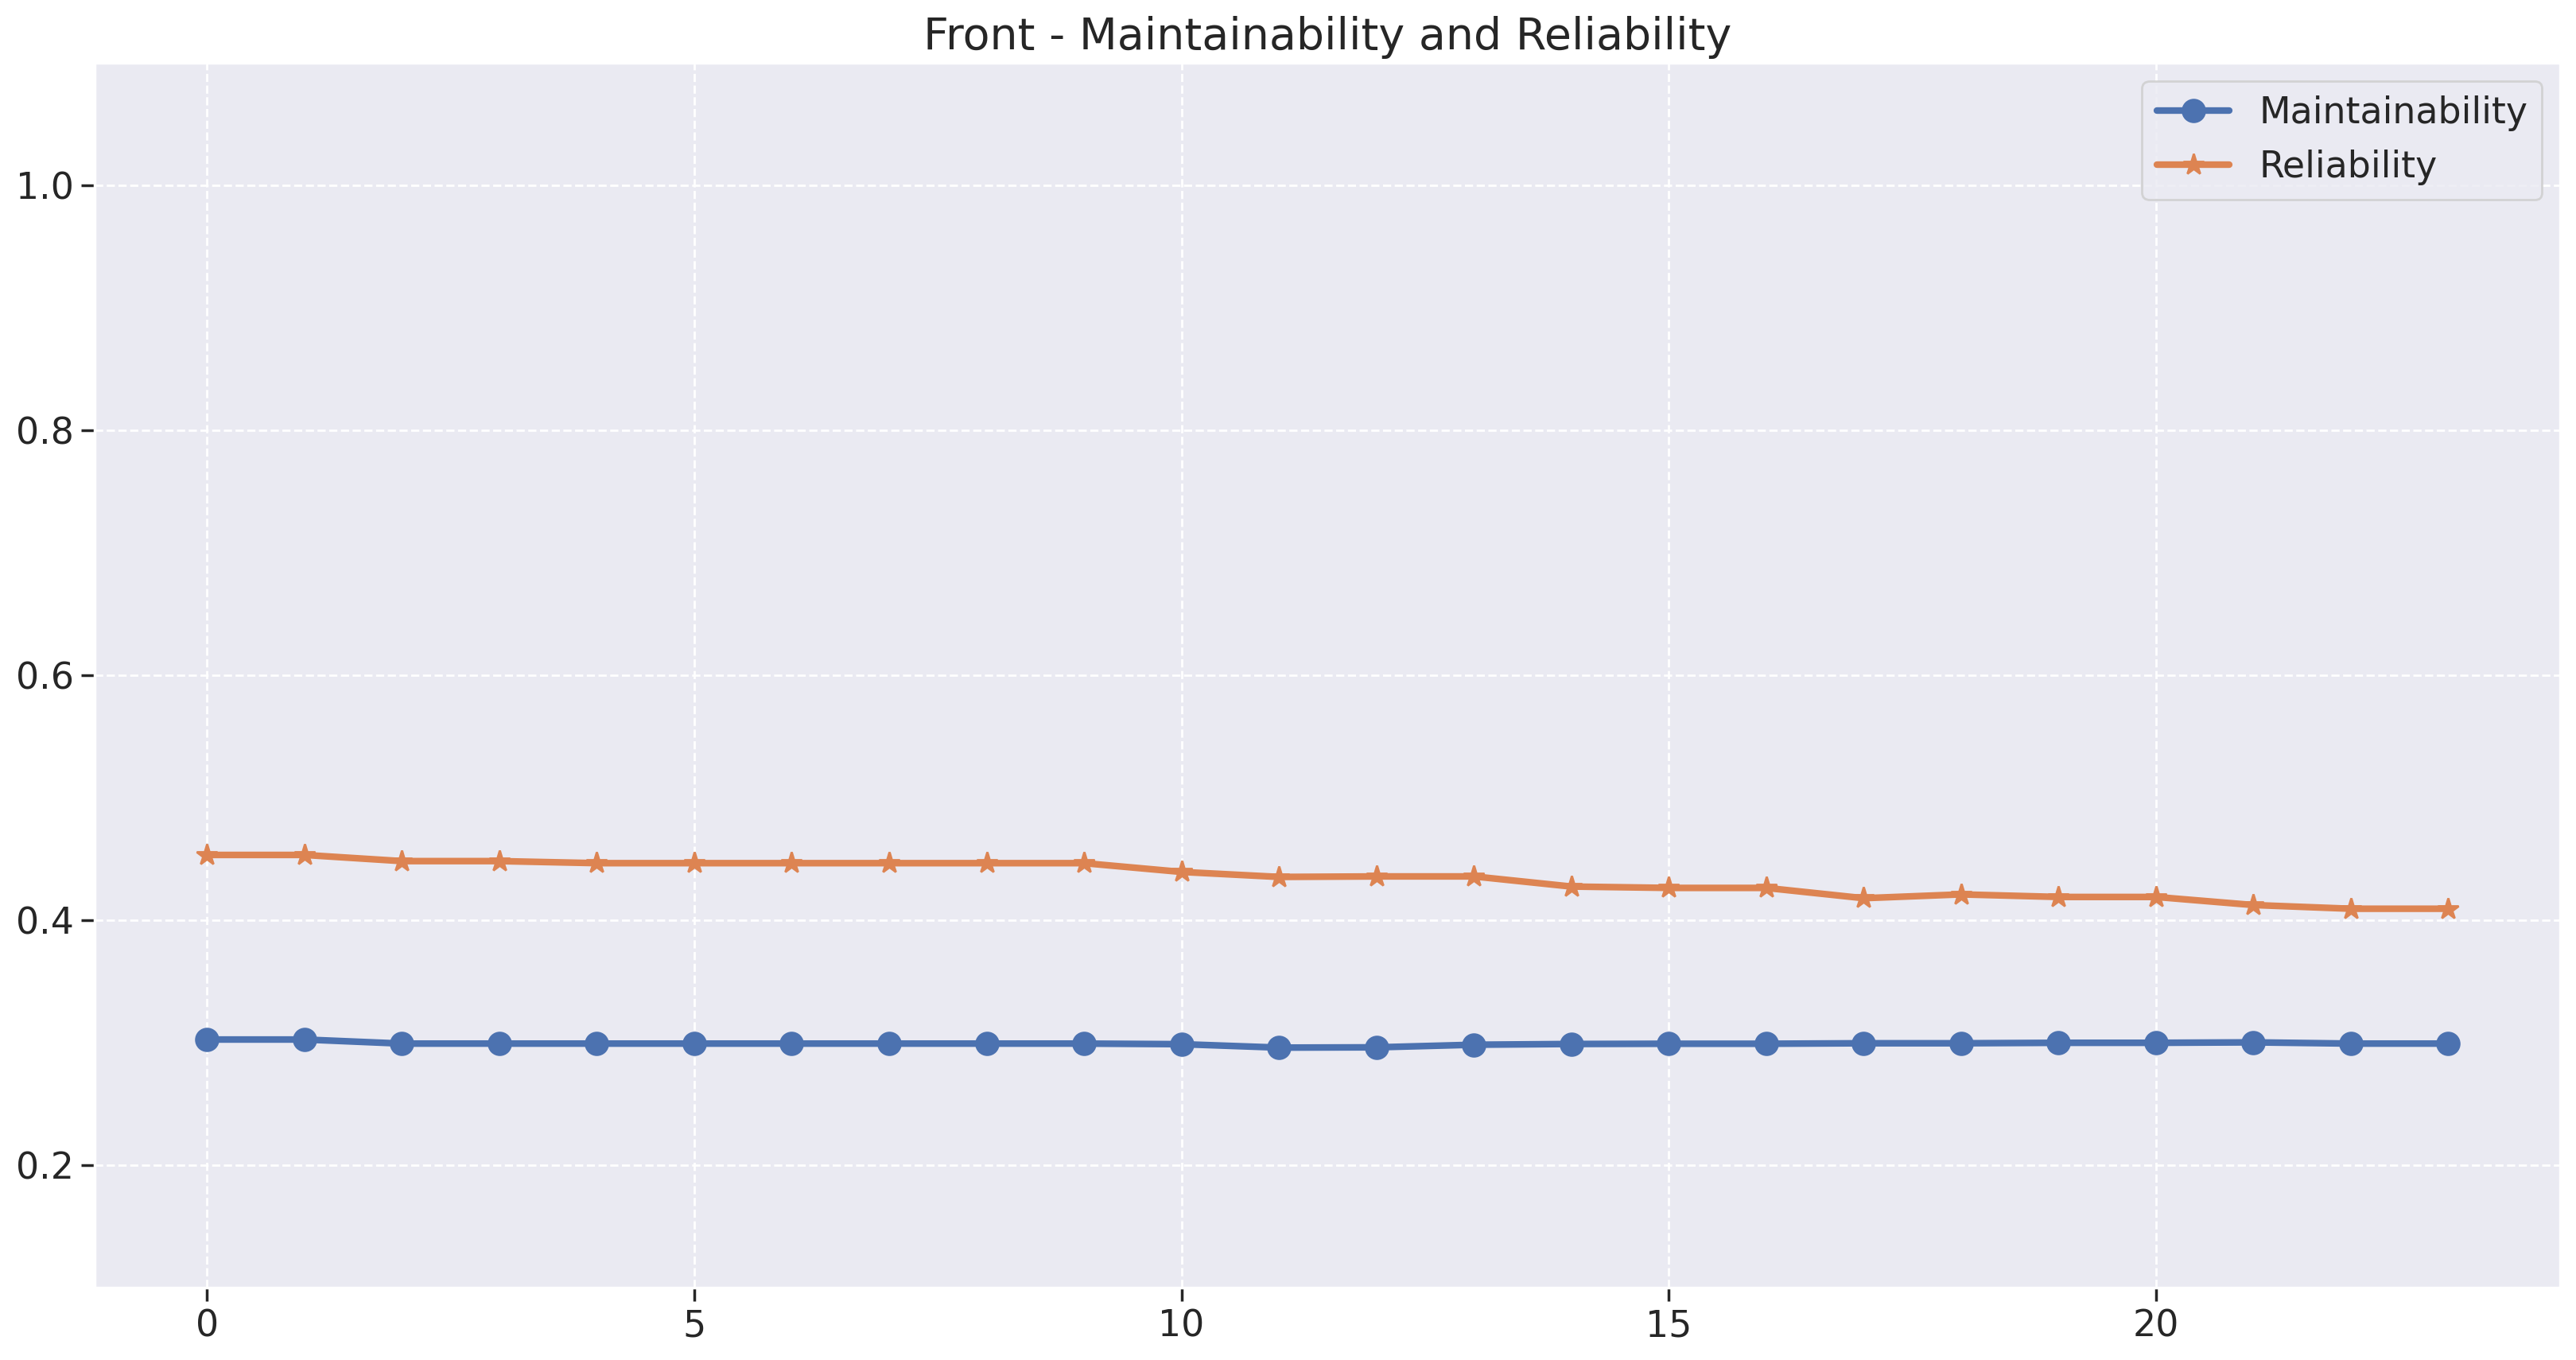

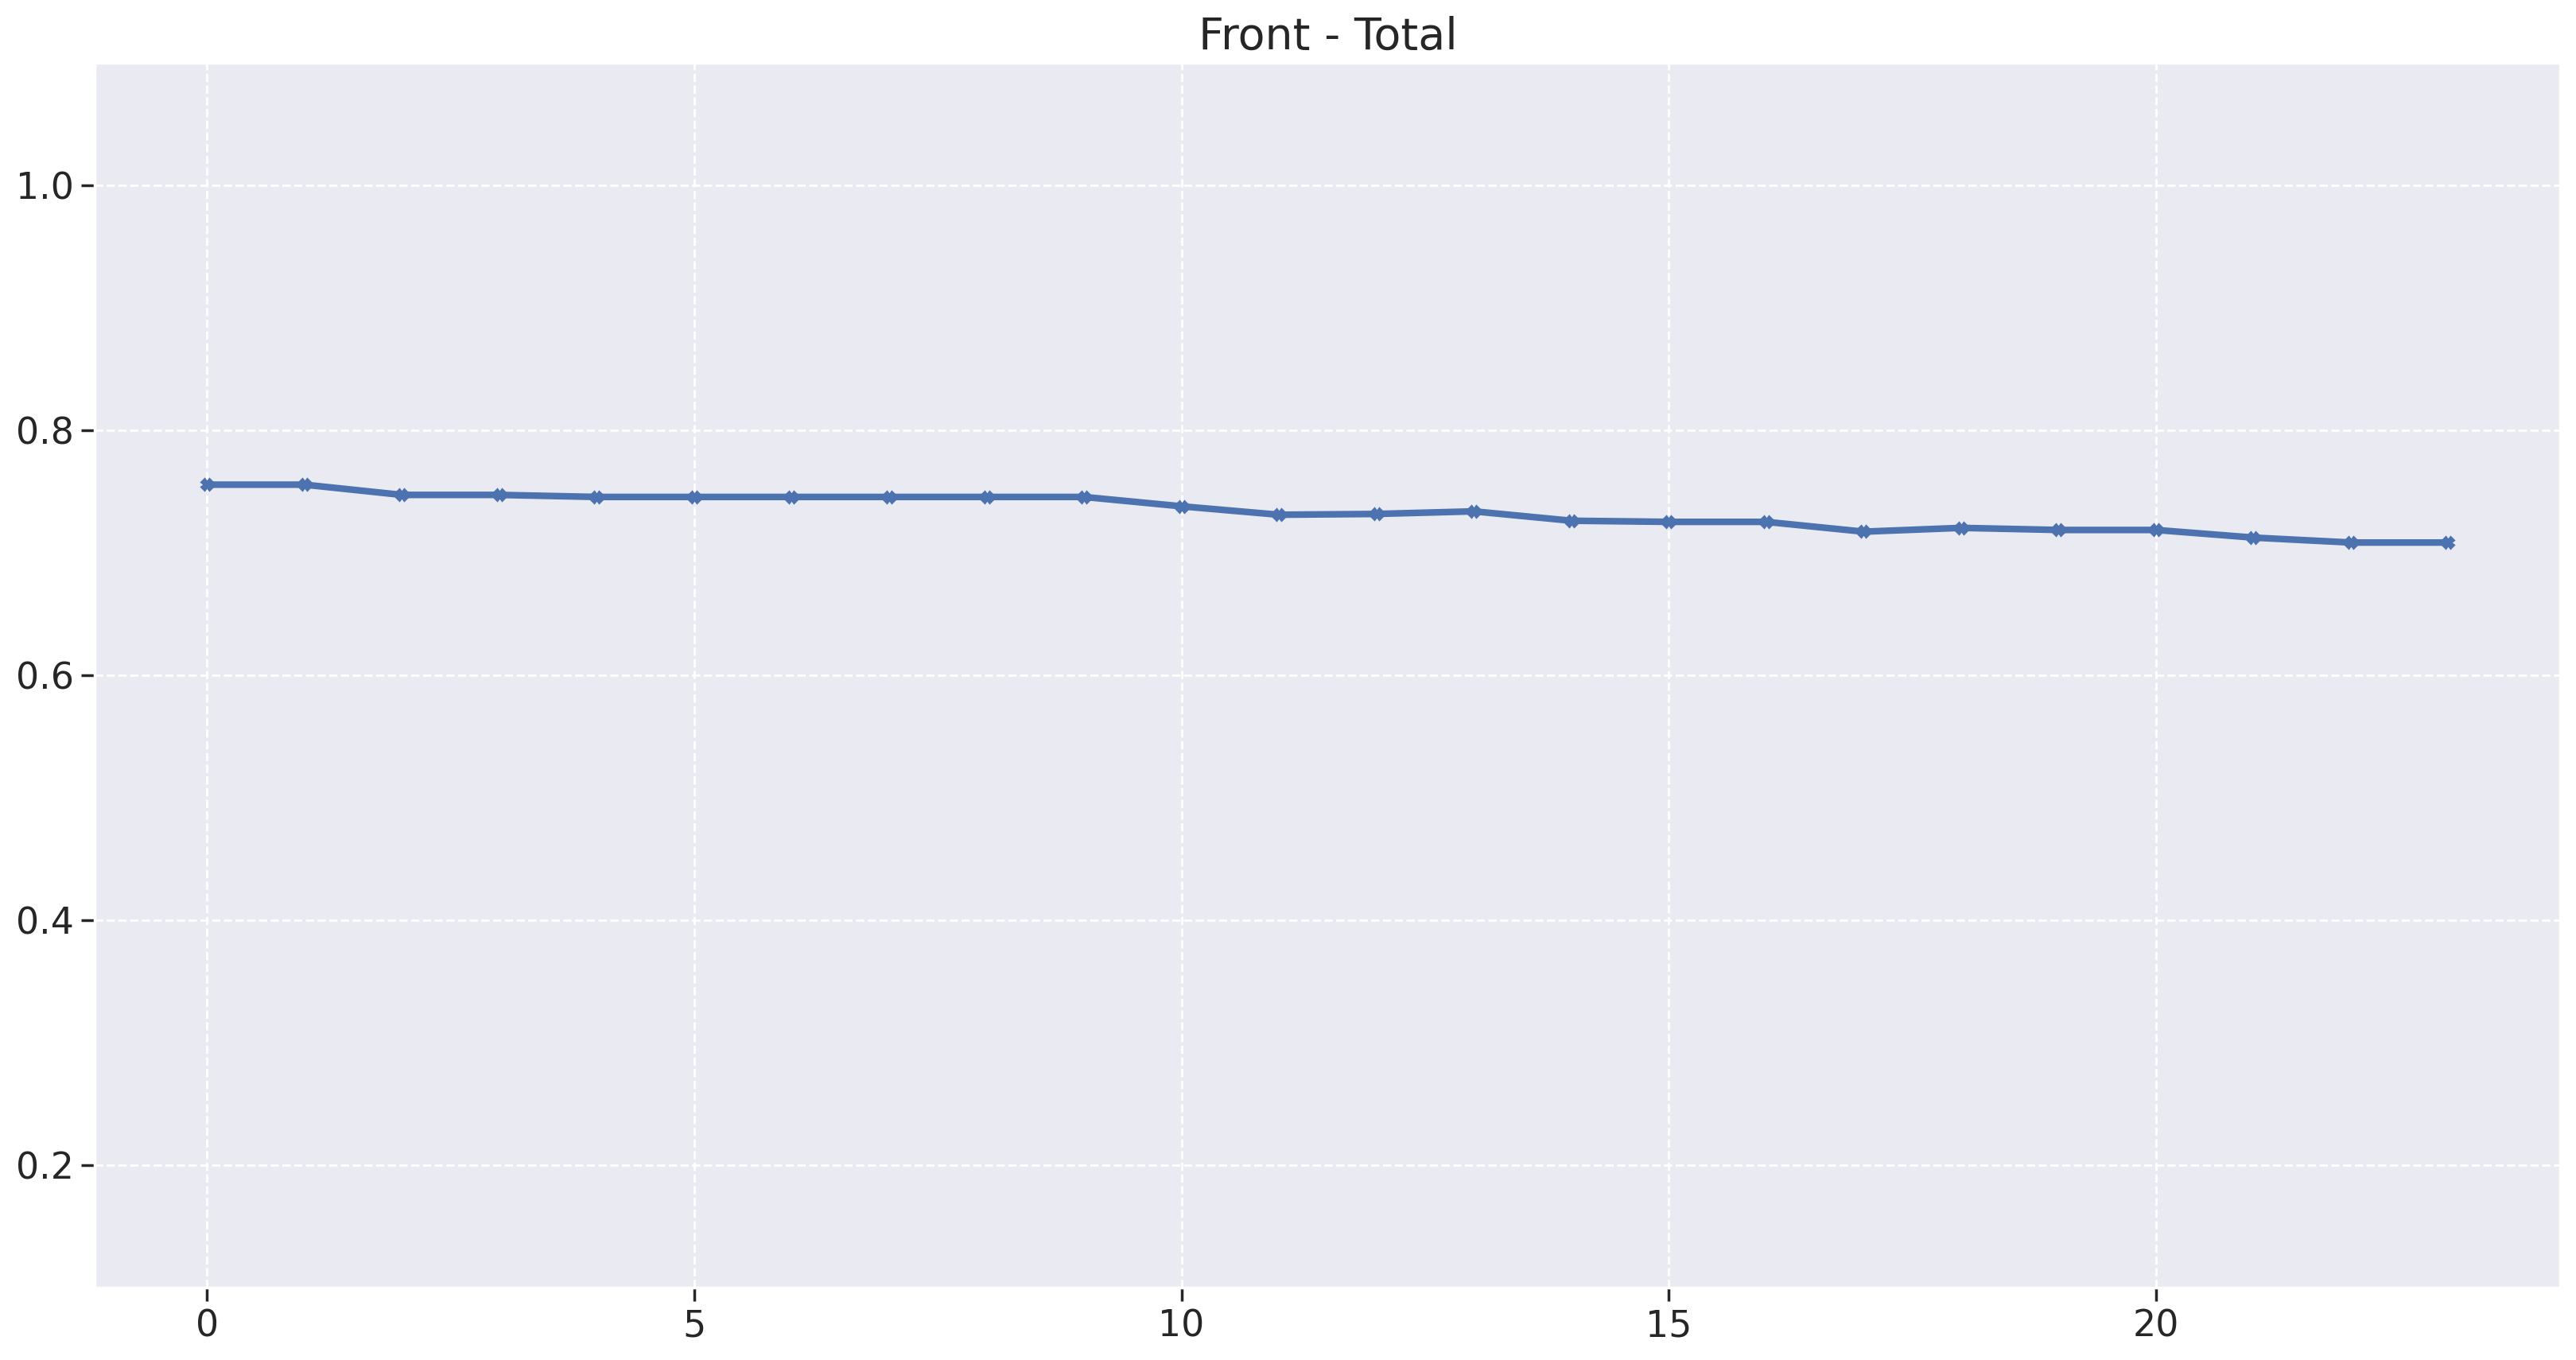

Core
Maintainability Stats
   mean     mode   median      std      var      min  max
0.31625 0.309375 0.309375 0.009932 0.000099 0.309375 0.33
Reliability Stats
    mean  mode  median      std      var   min  max
0.390625   0.5     0.5 0.174115 0.030316 0.125  0.5


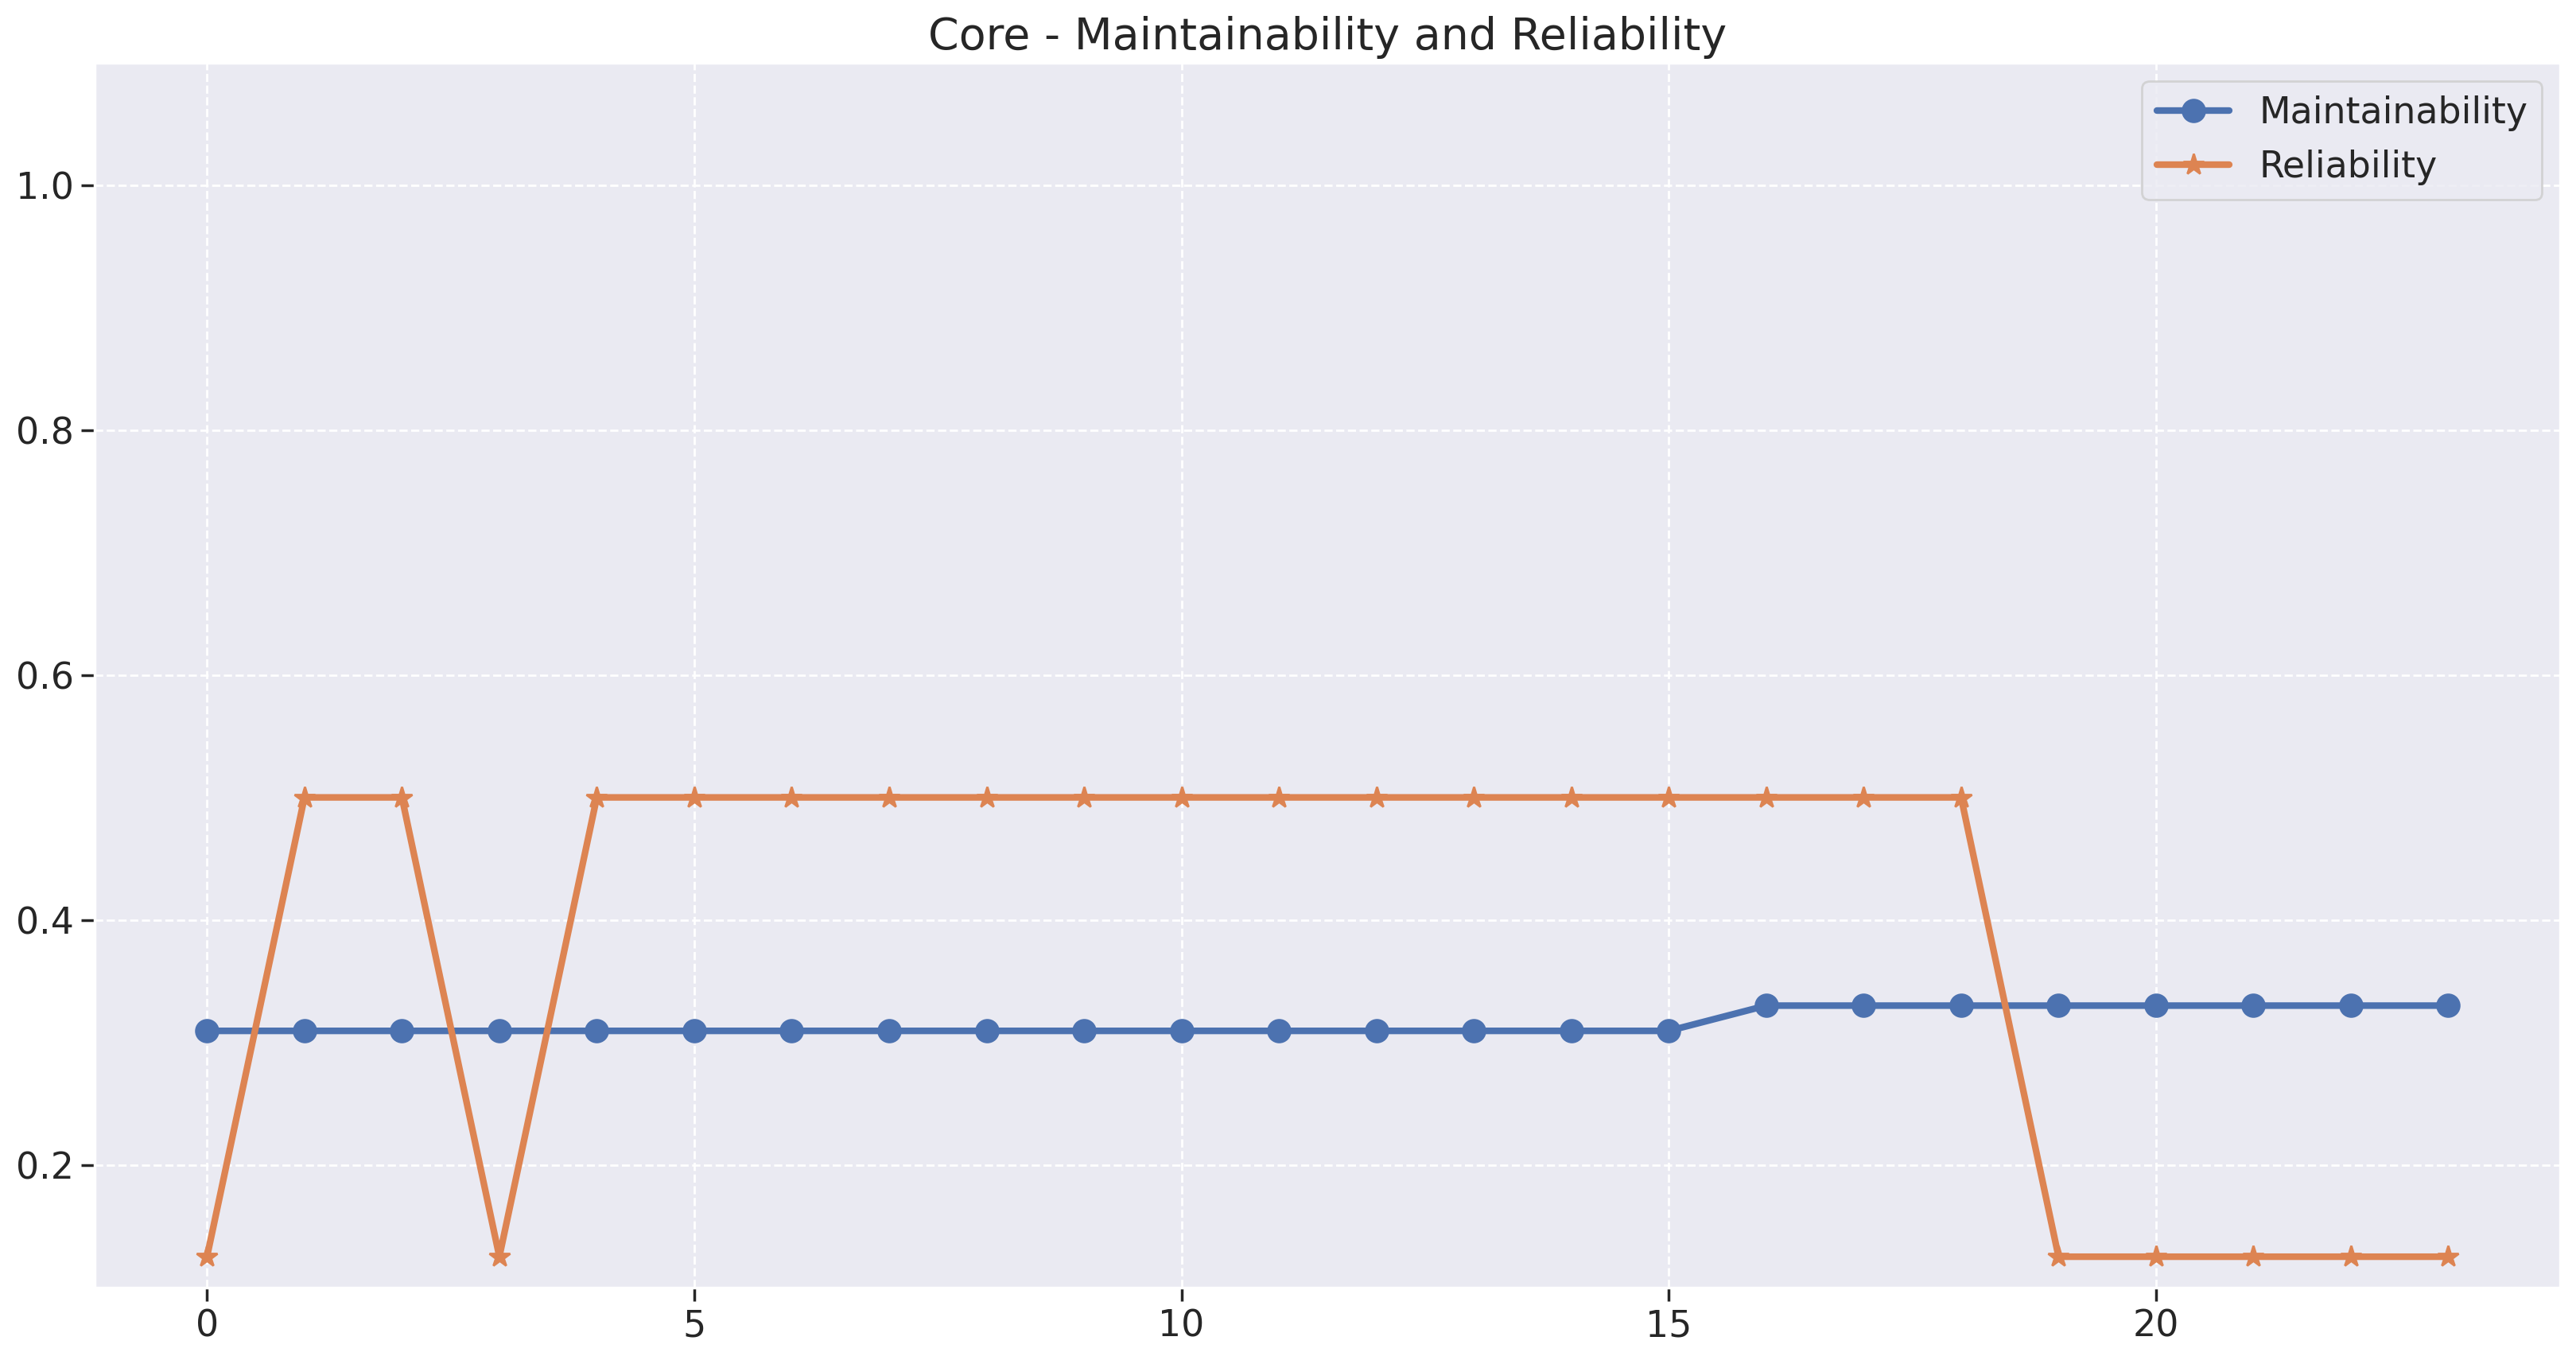

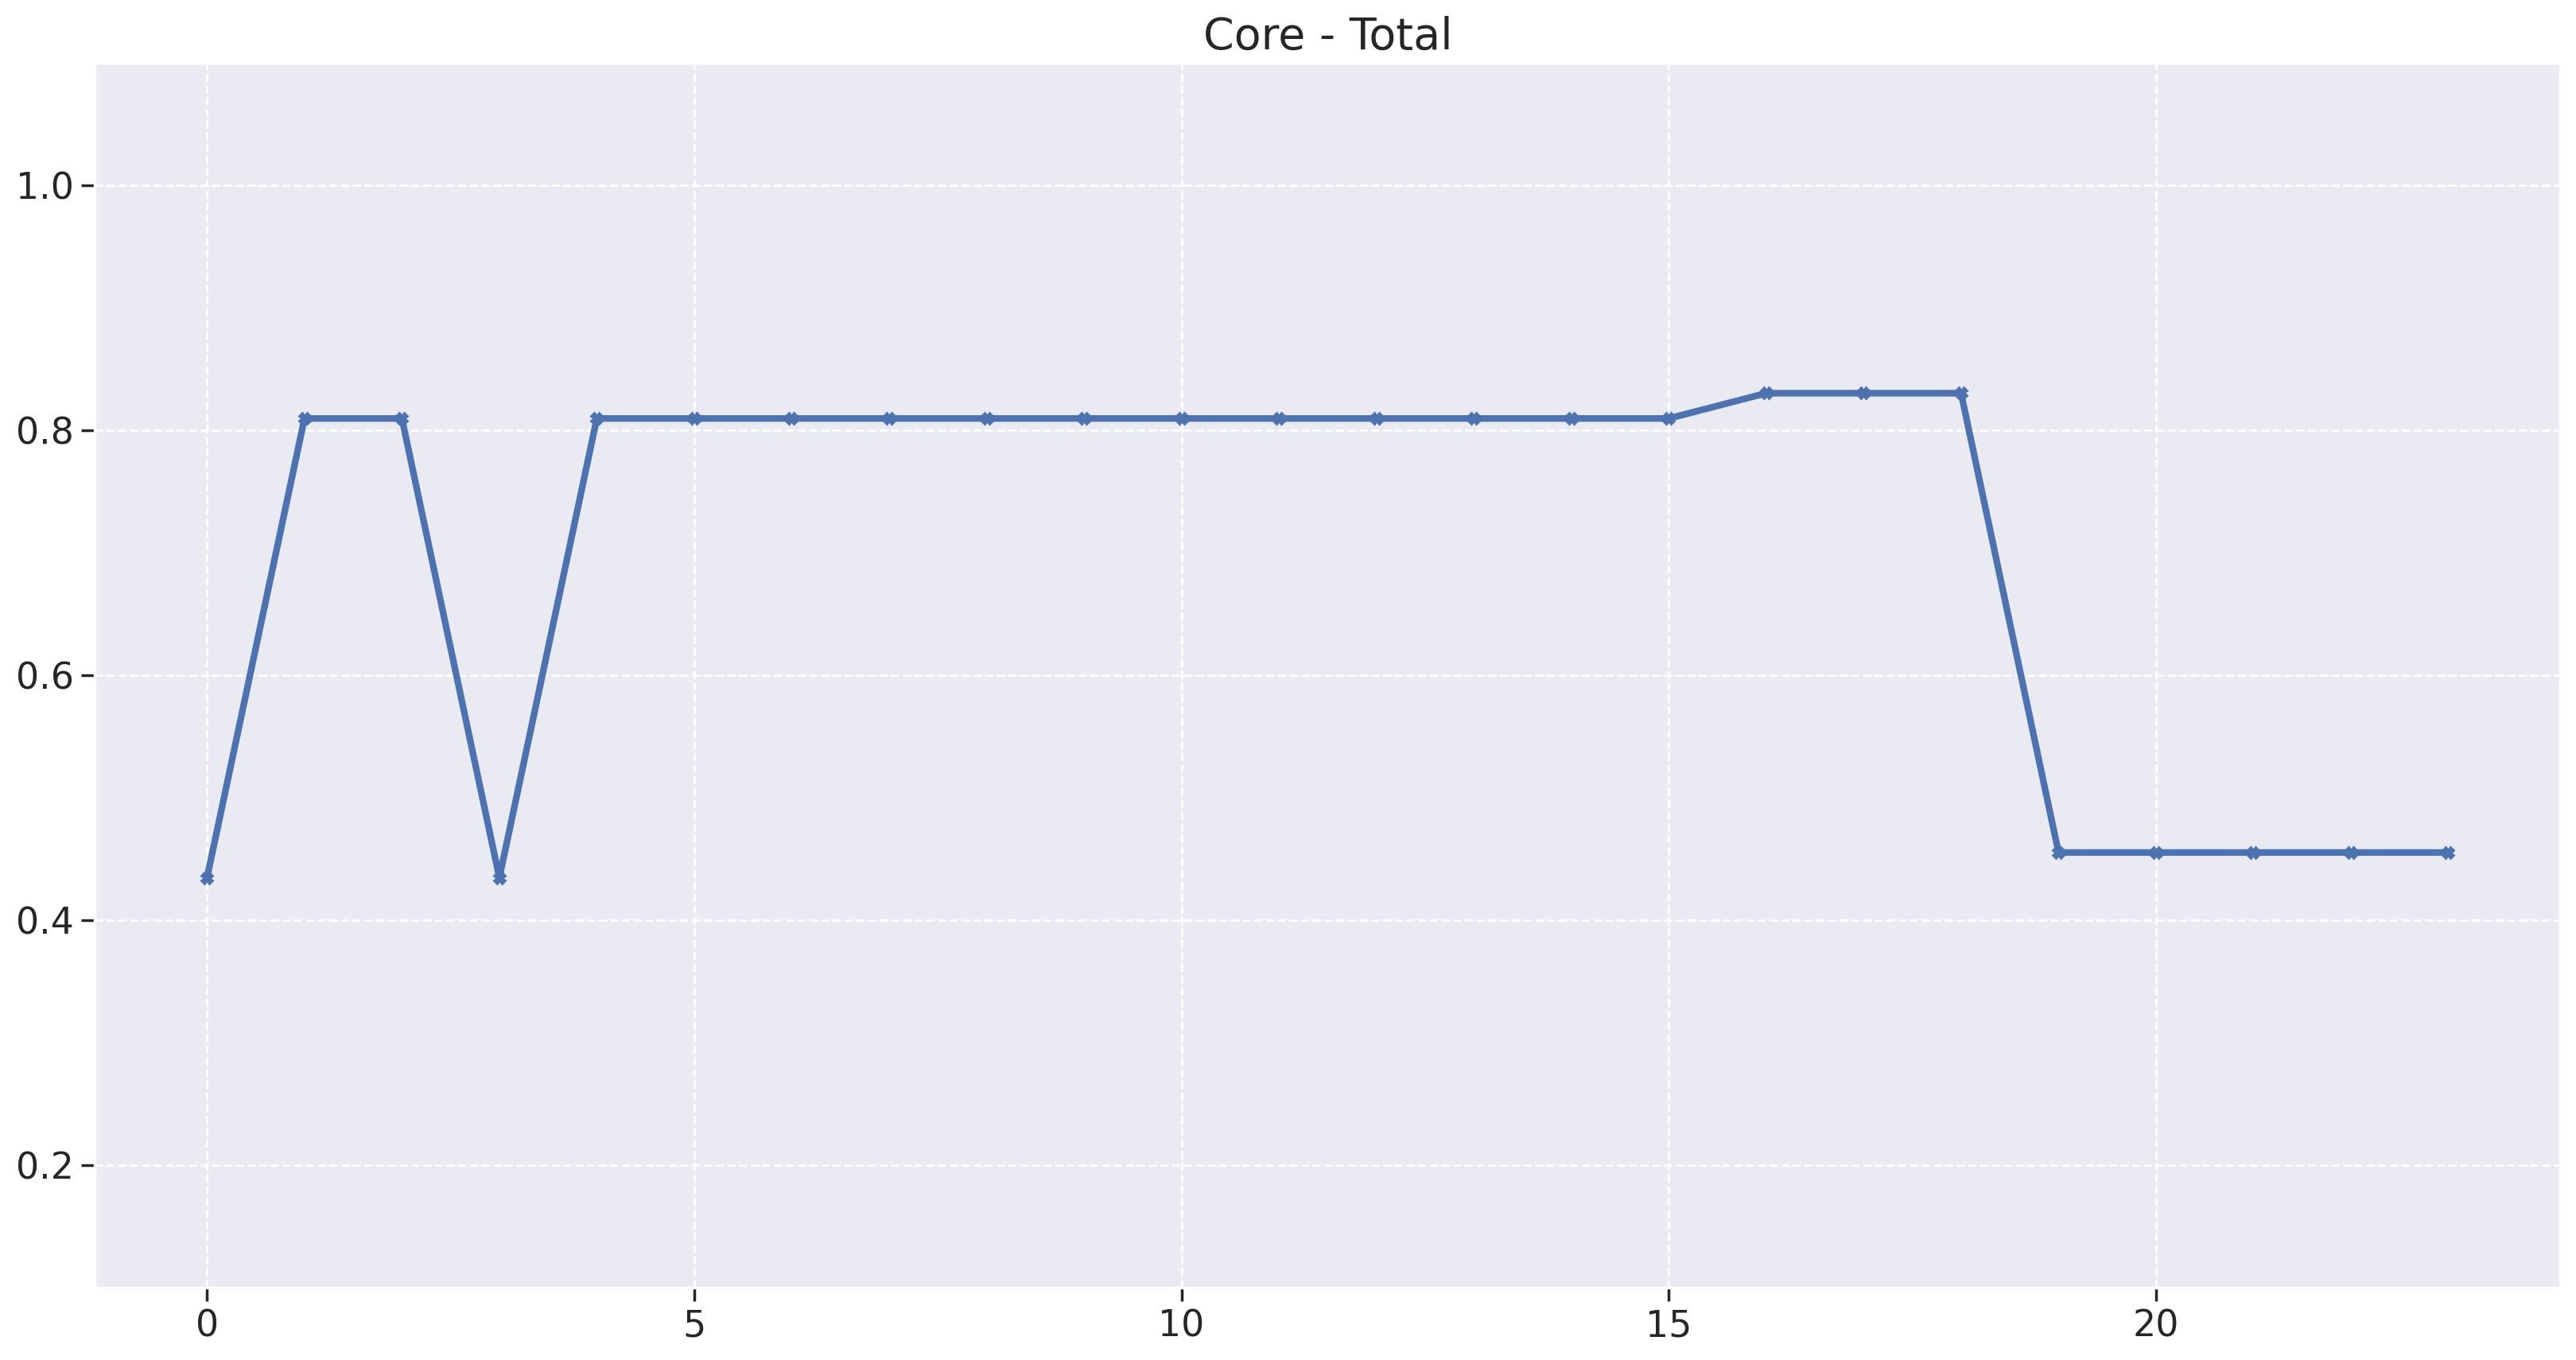

Action
Maintainability Stats
 mean  mode  median  std  var  min  max
 0.33  0.33    0.33  0.0  0.0 0.33 0.33
Reliability Stats
    mean     mode   median          std          var      min      max
0.458333 0.458333 0.458333 1.723785e-16 2.971435e-32 0.458333 0.458333


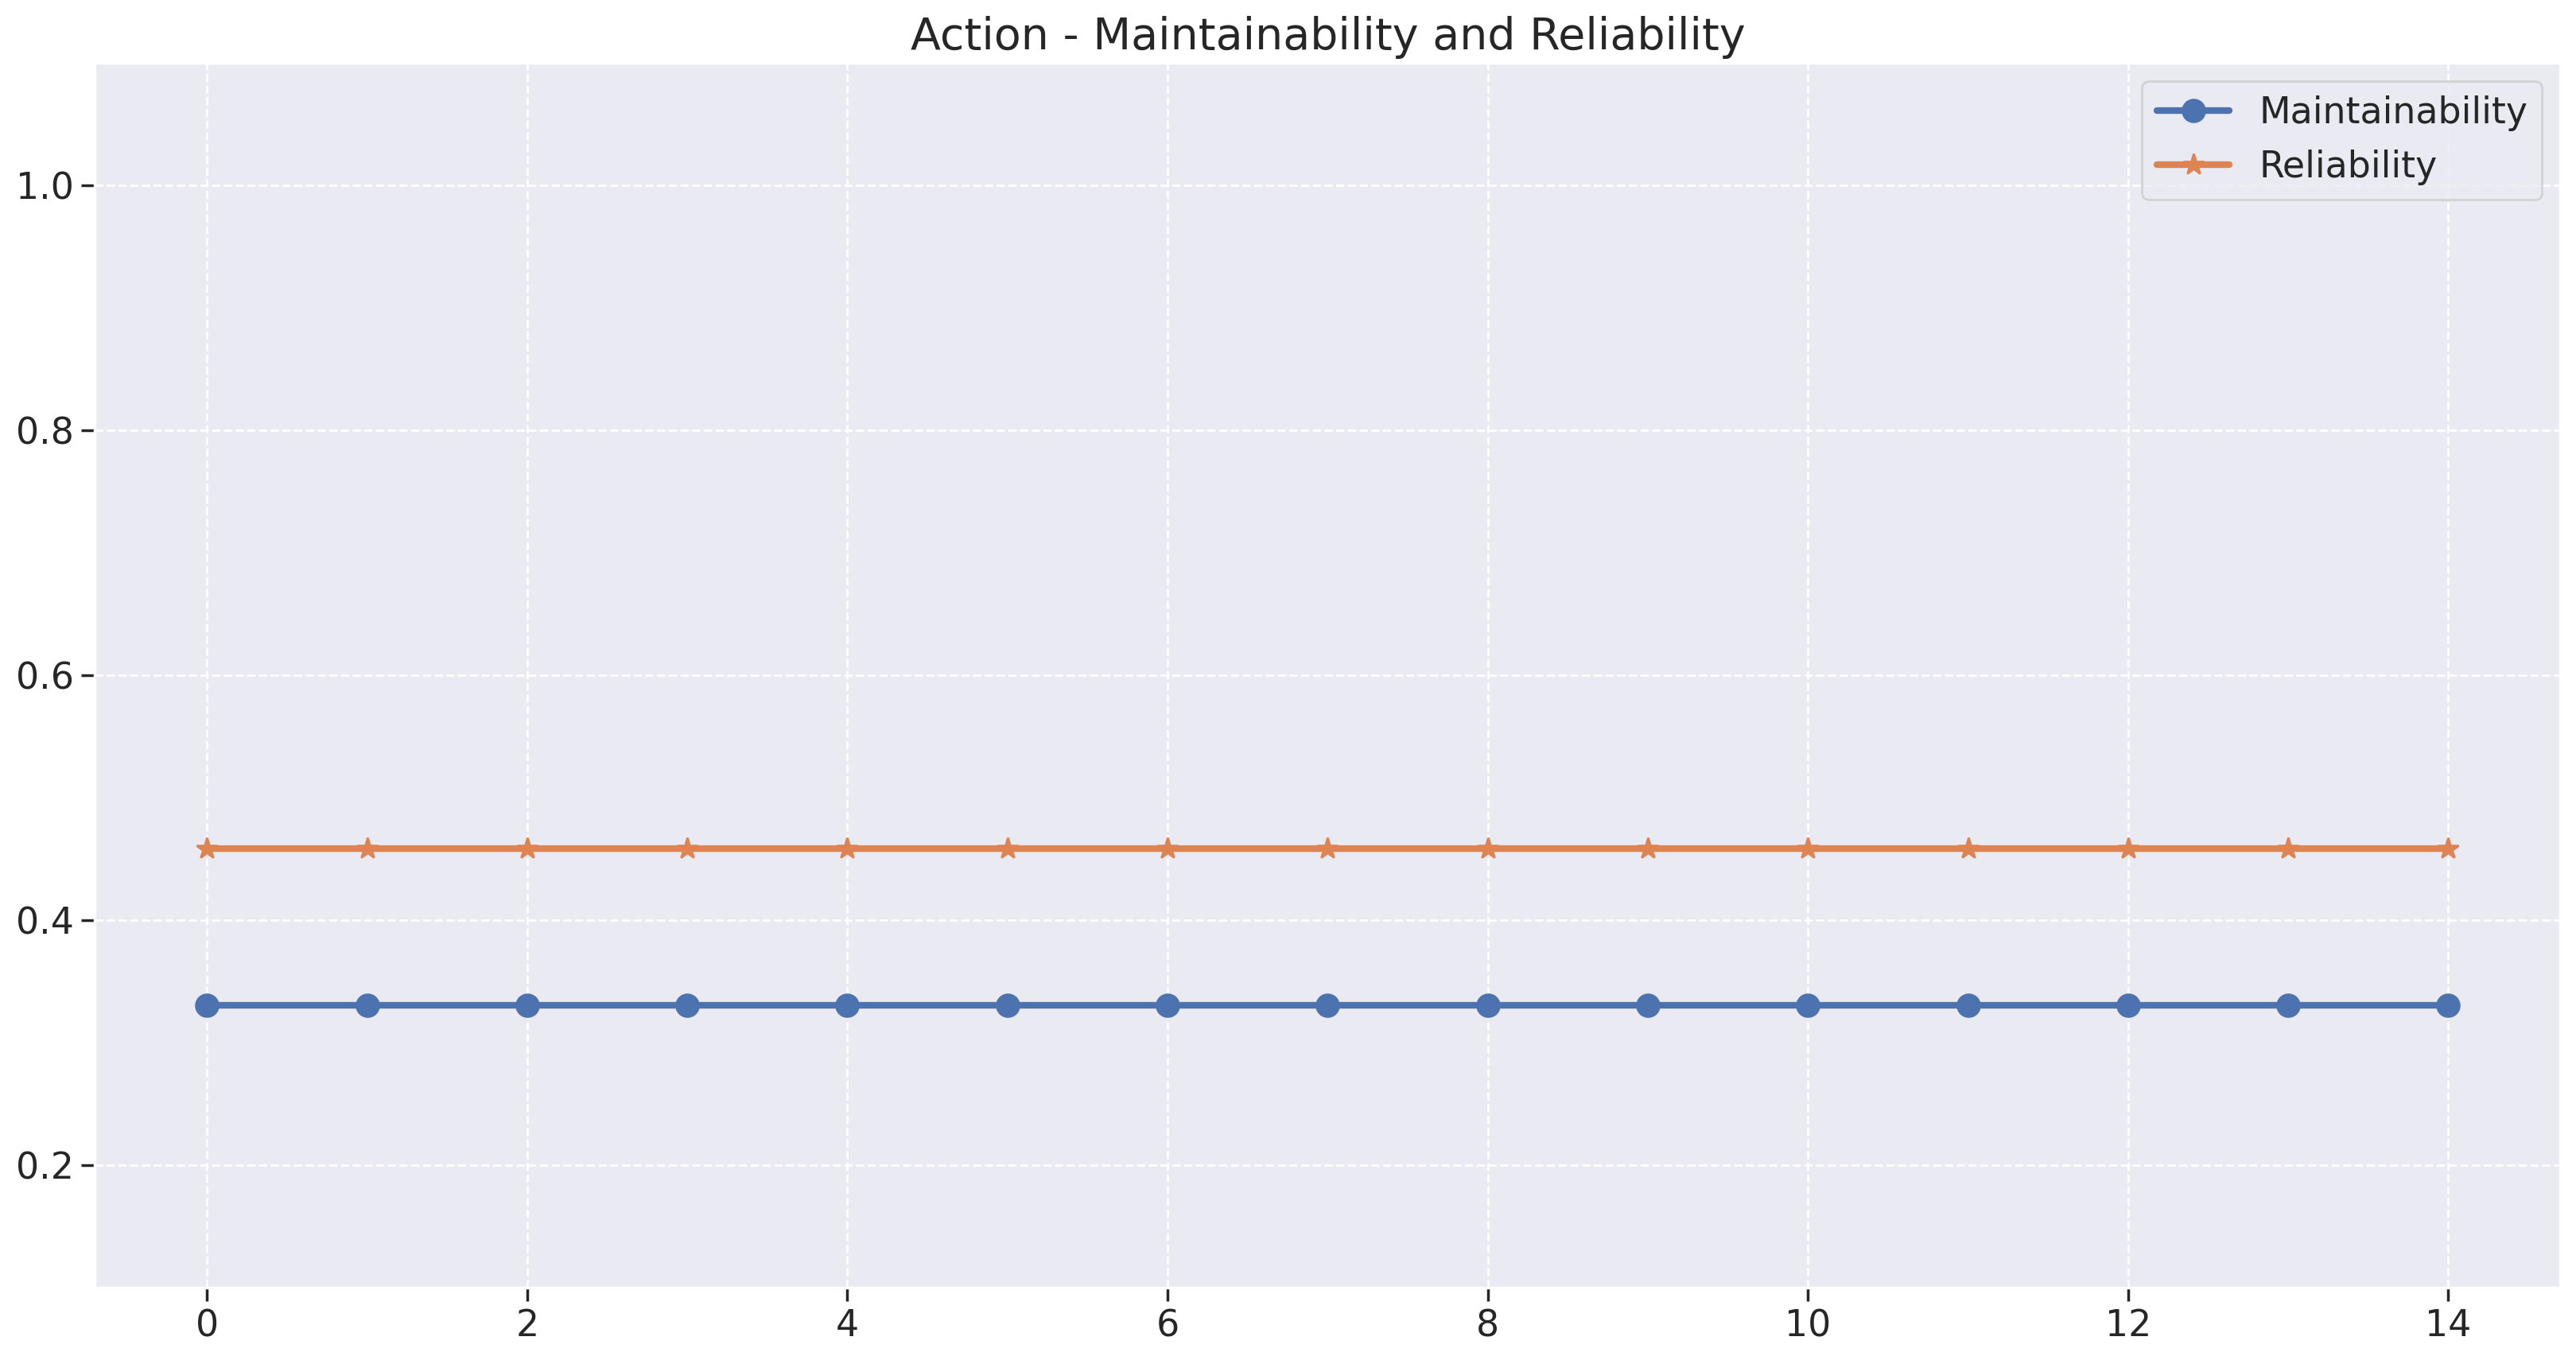

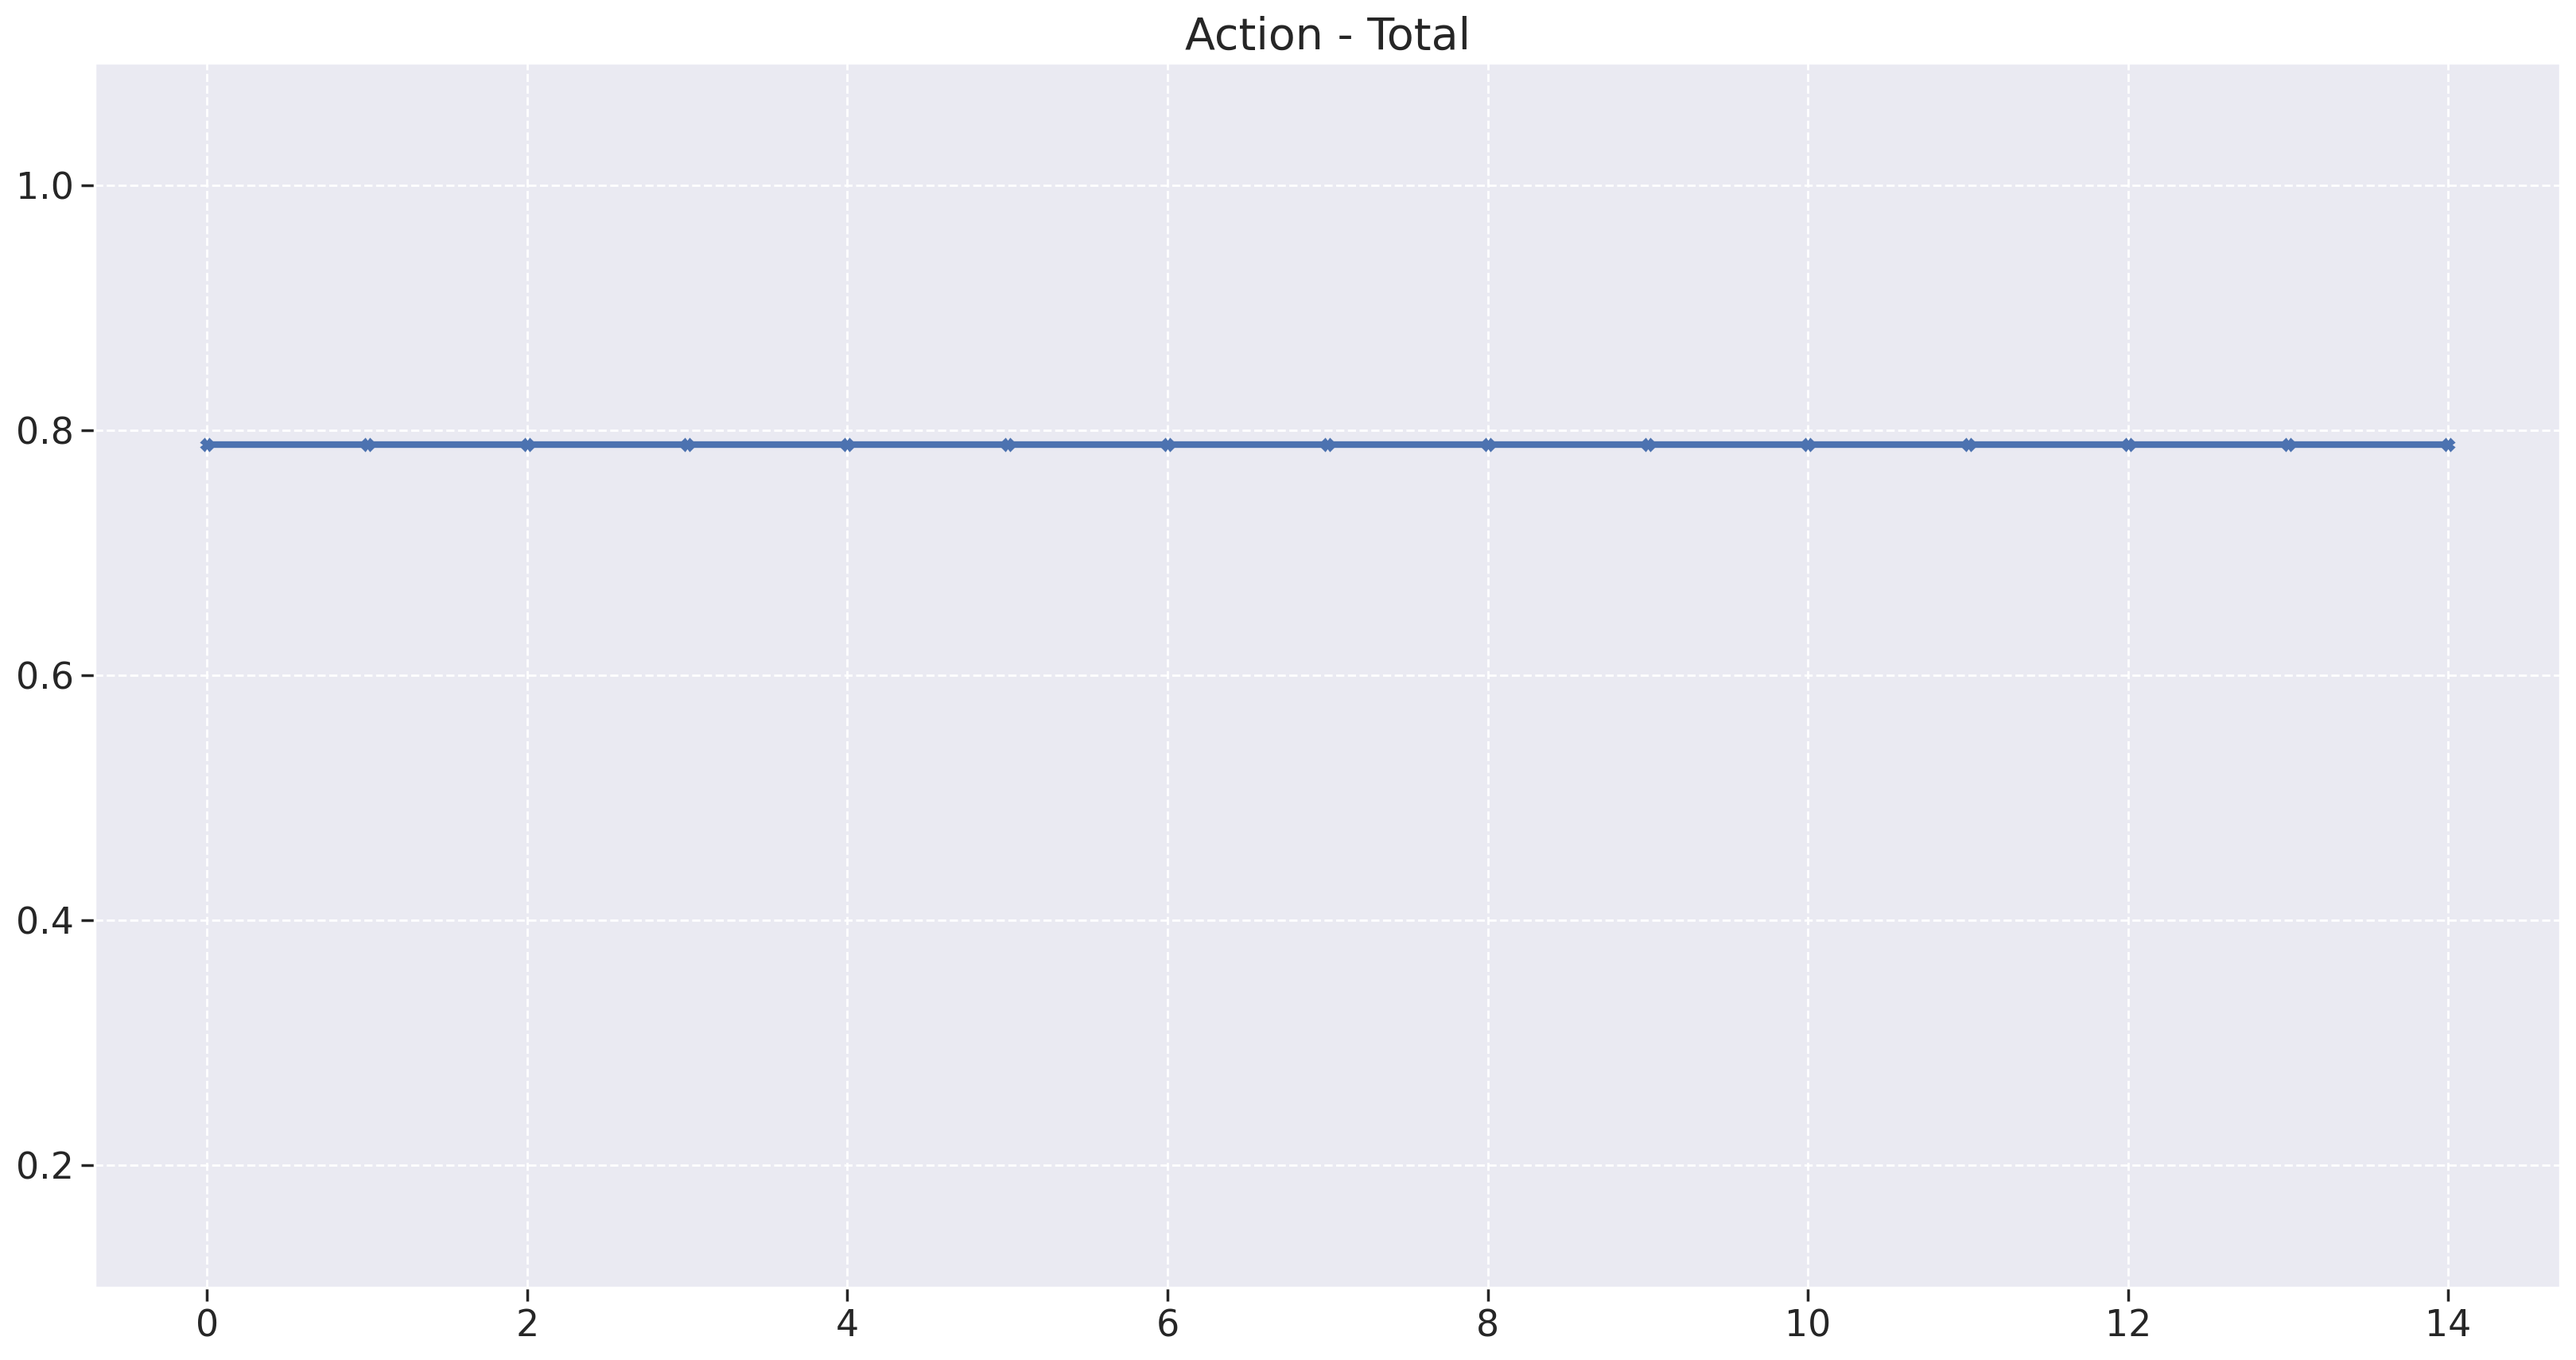

Parser
Maintainability Stats
 mean  mode  median  std  var   min   max
0.297 0.297   0.297  0.0  0.0 0.297 0.297
Reliability Stats
    mean  mode  median      std      var   min  max
0.453125   0.5     0.5 0.132583 0.017578 0.125  0.5


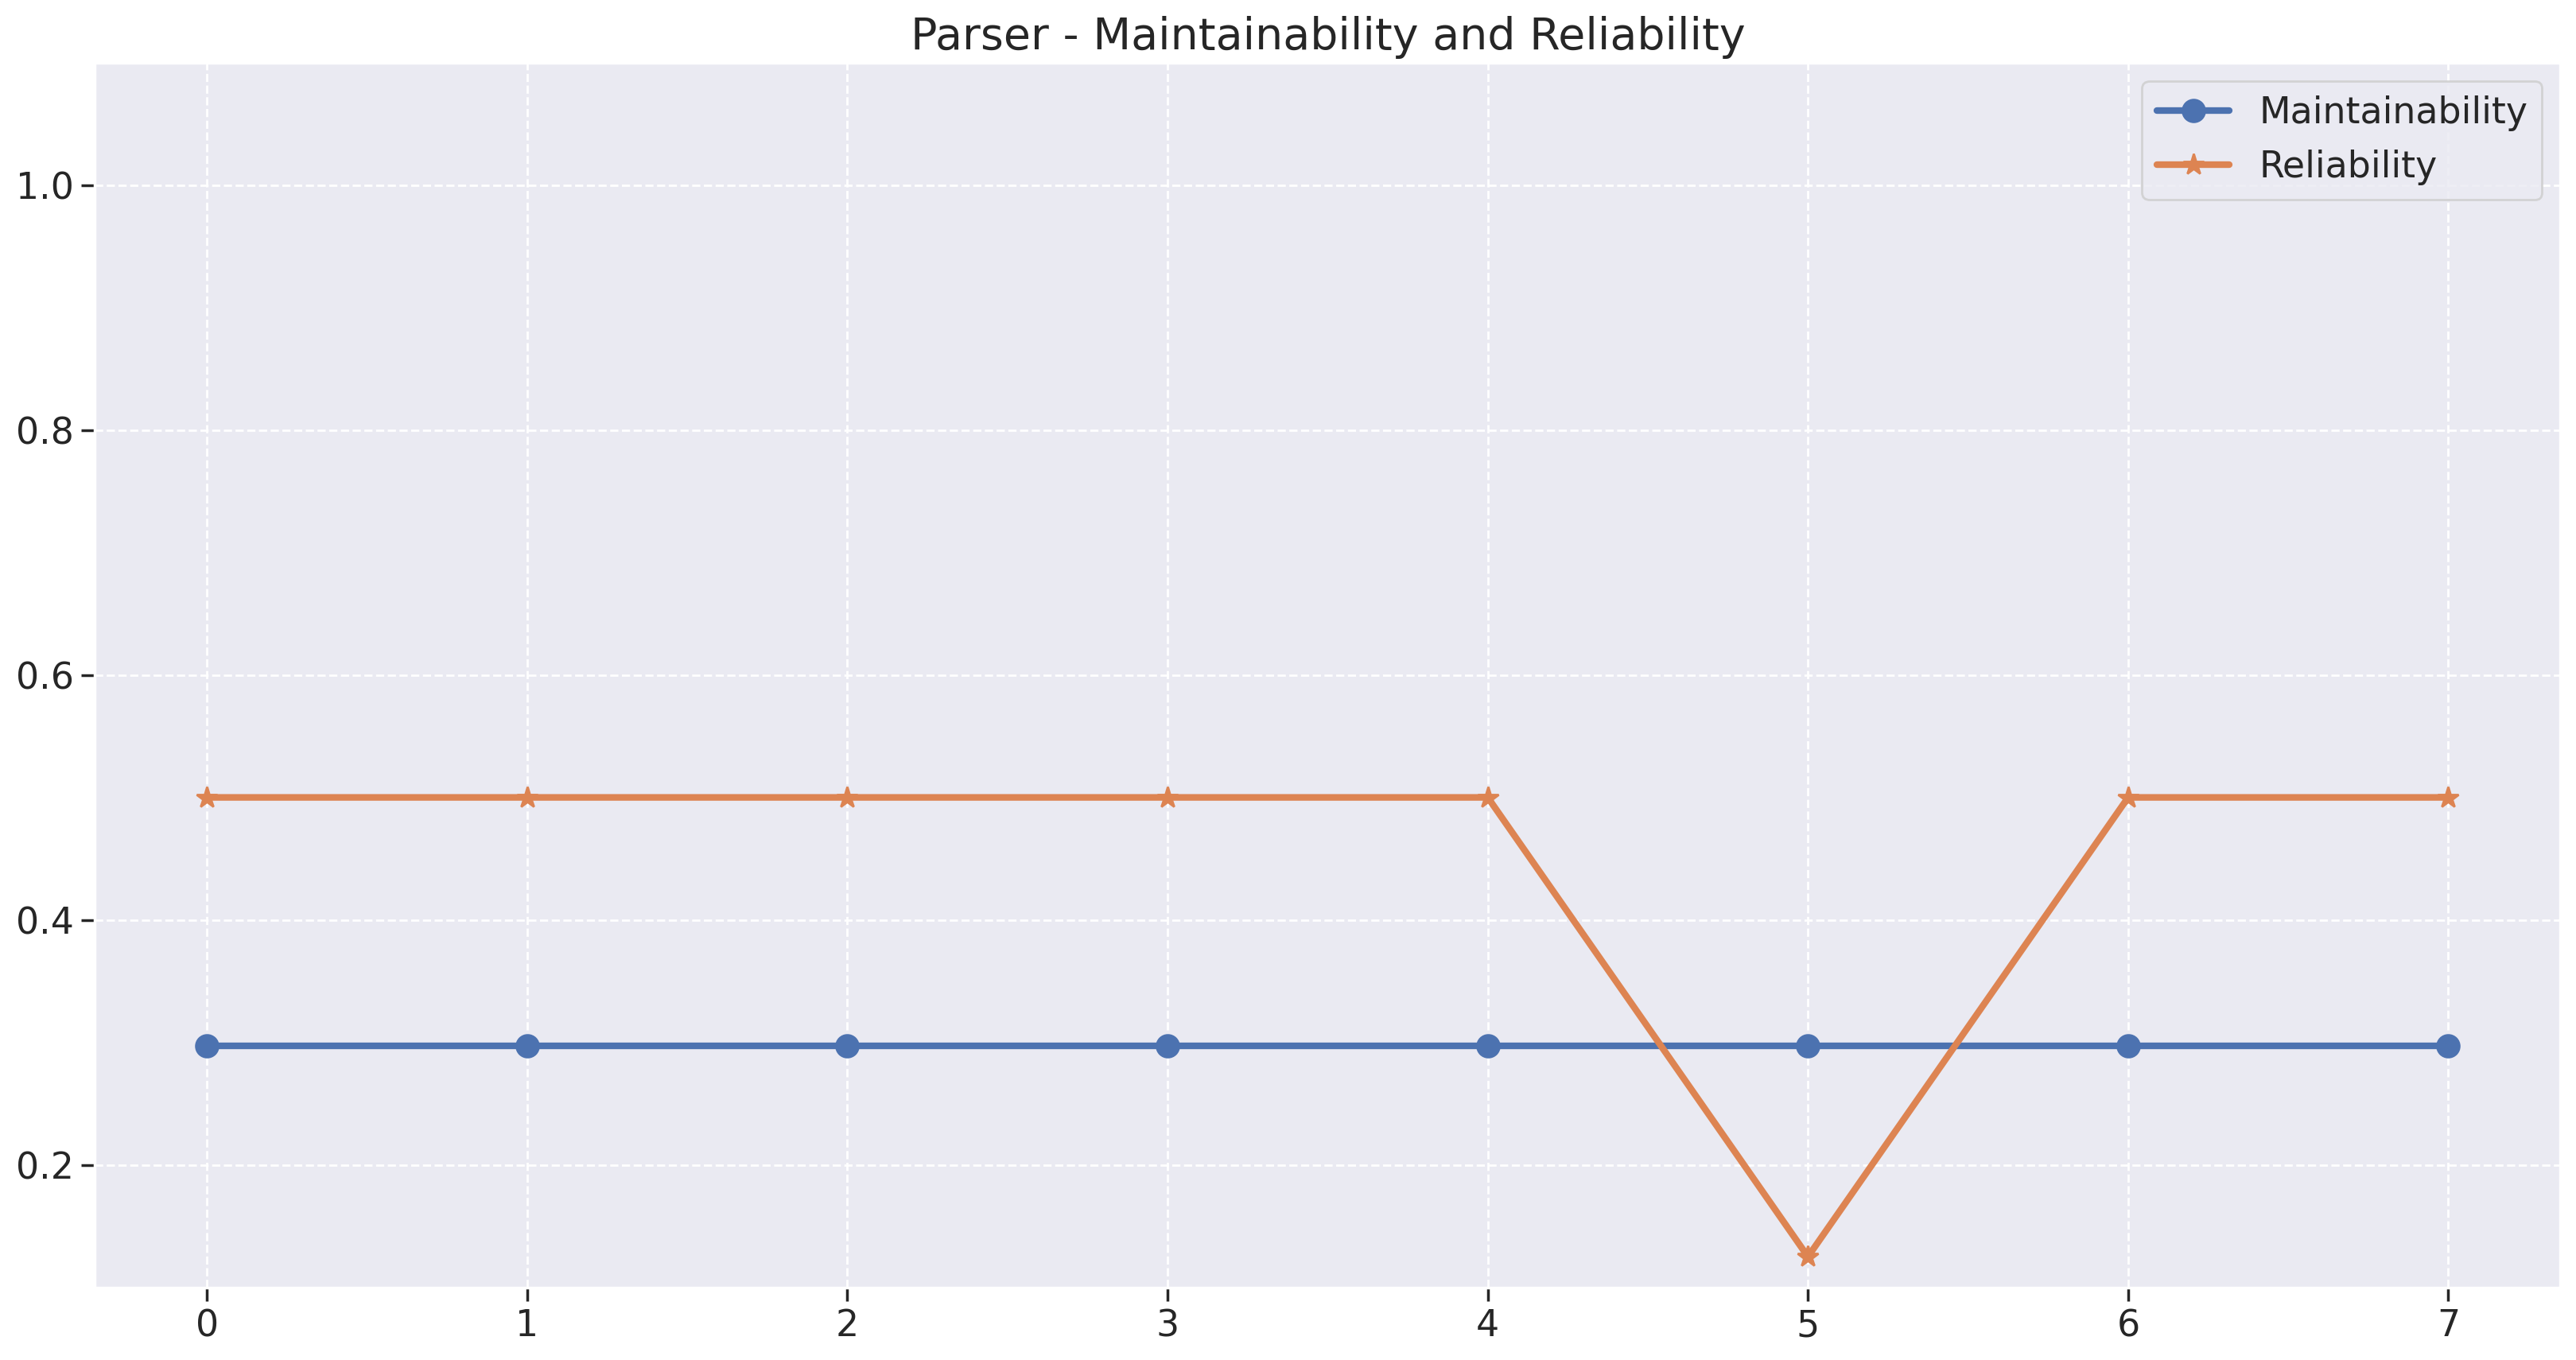

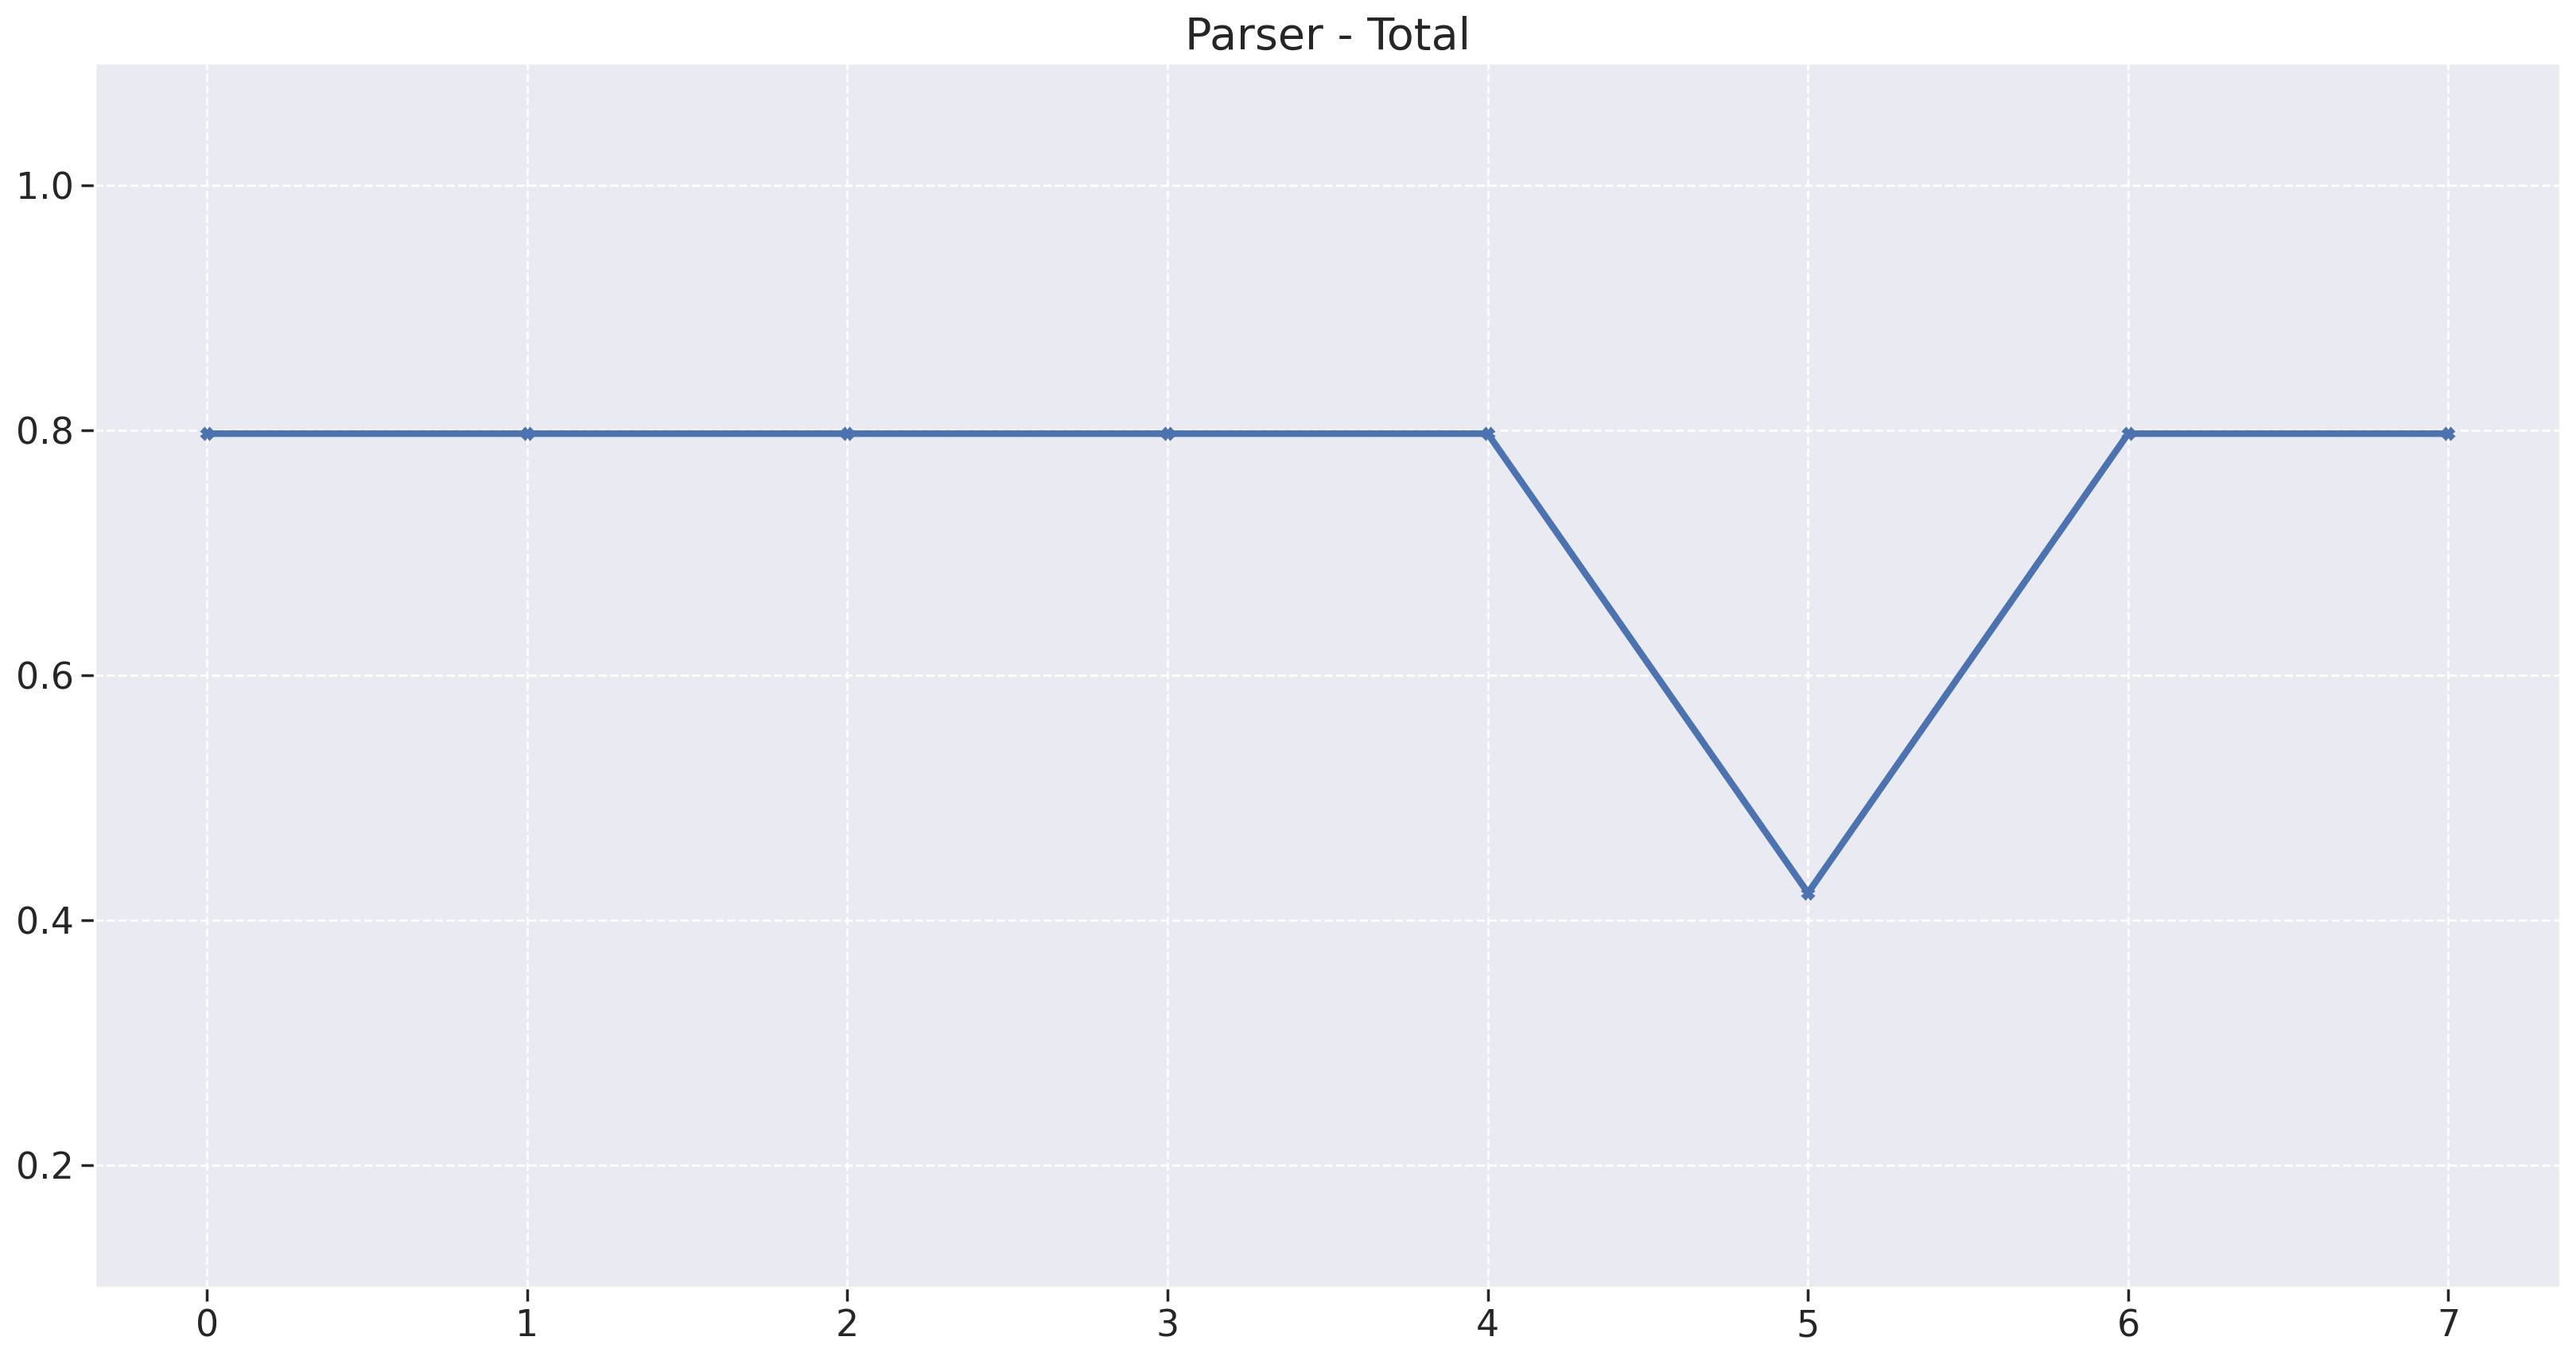

In [30]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

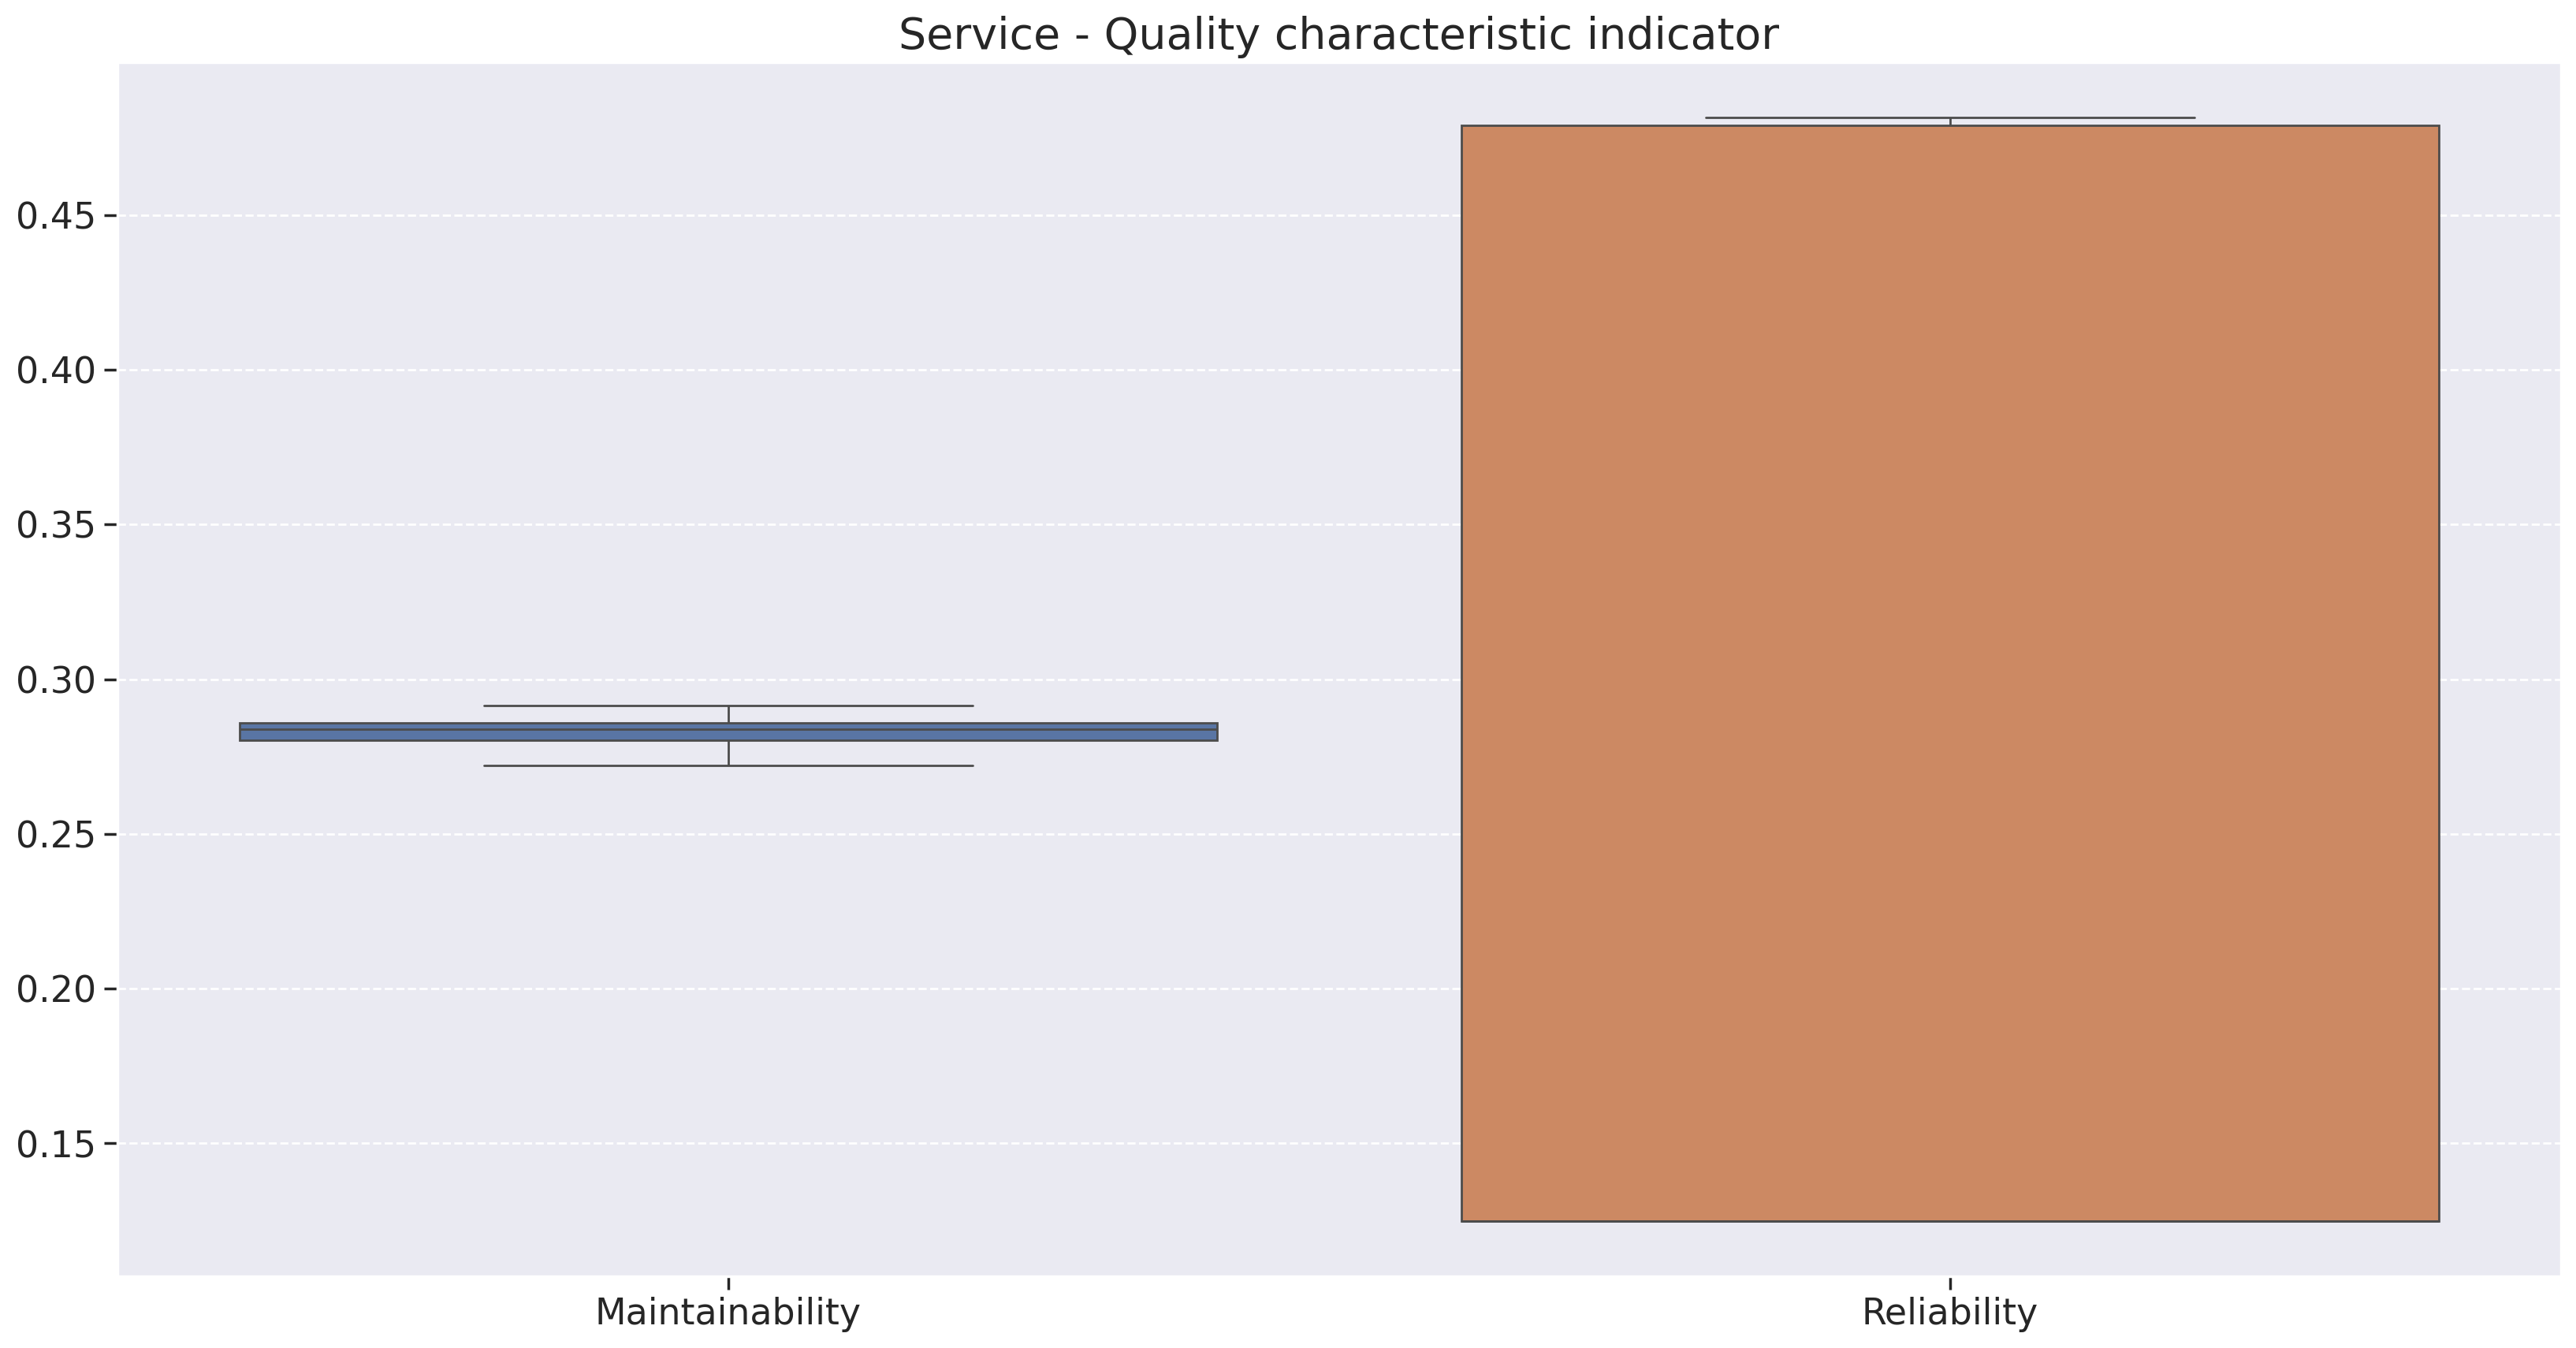

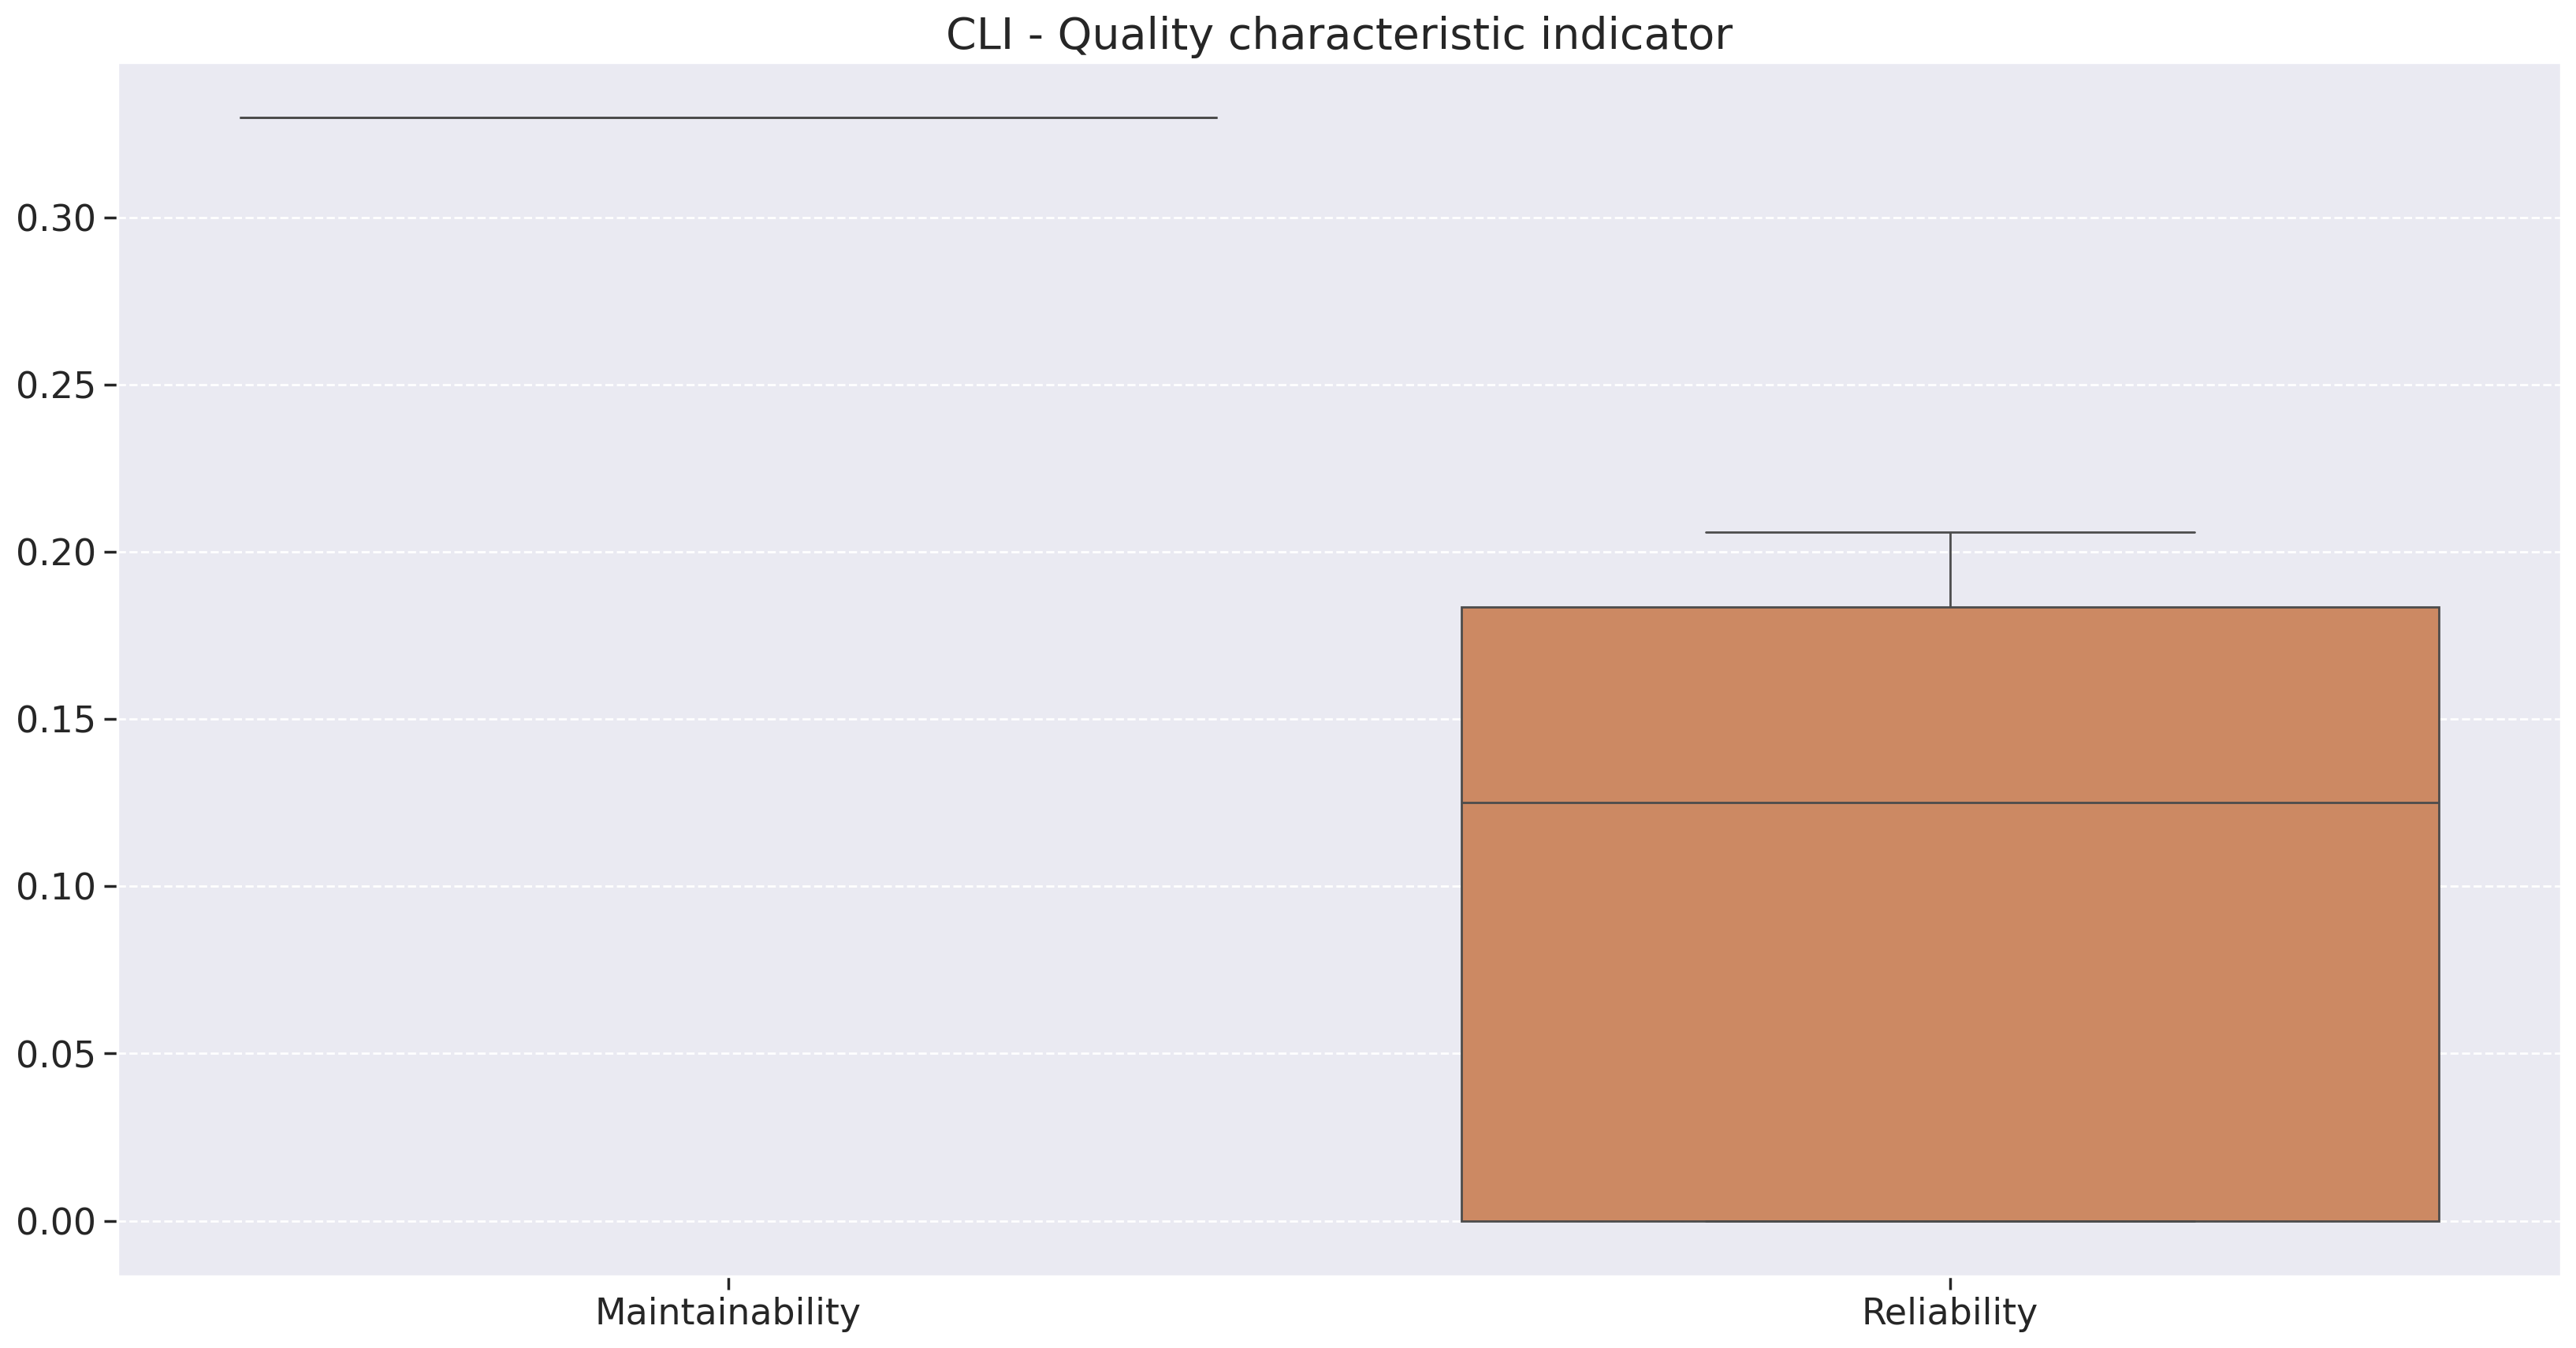

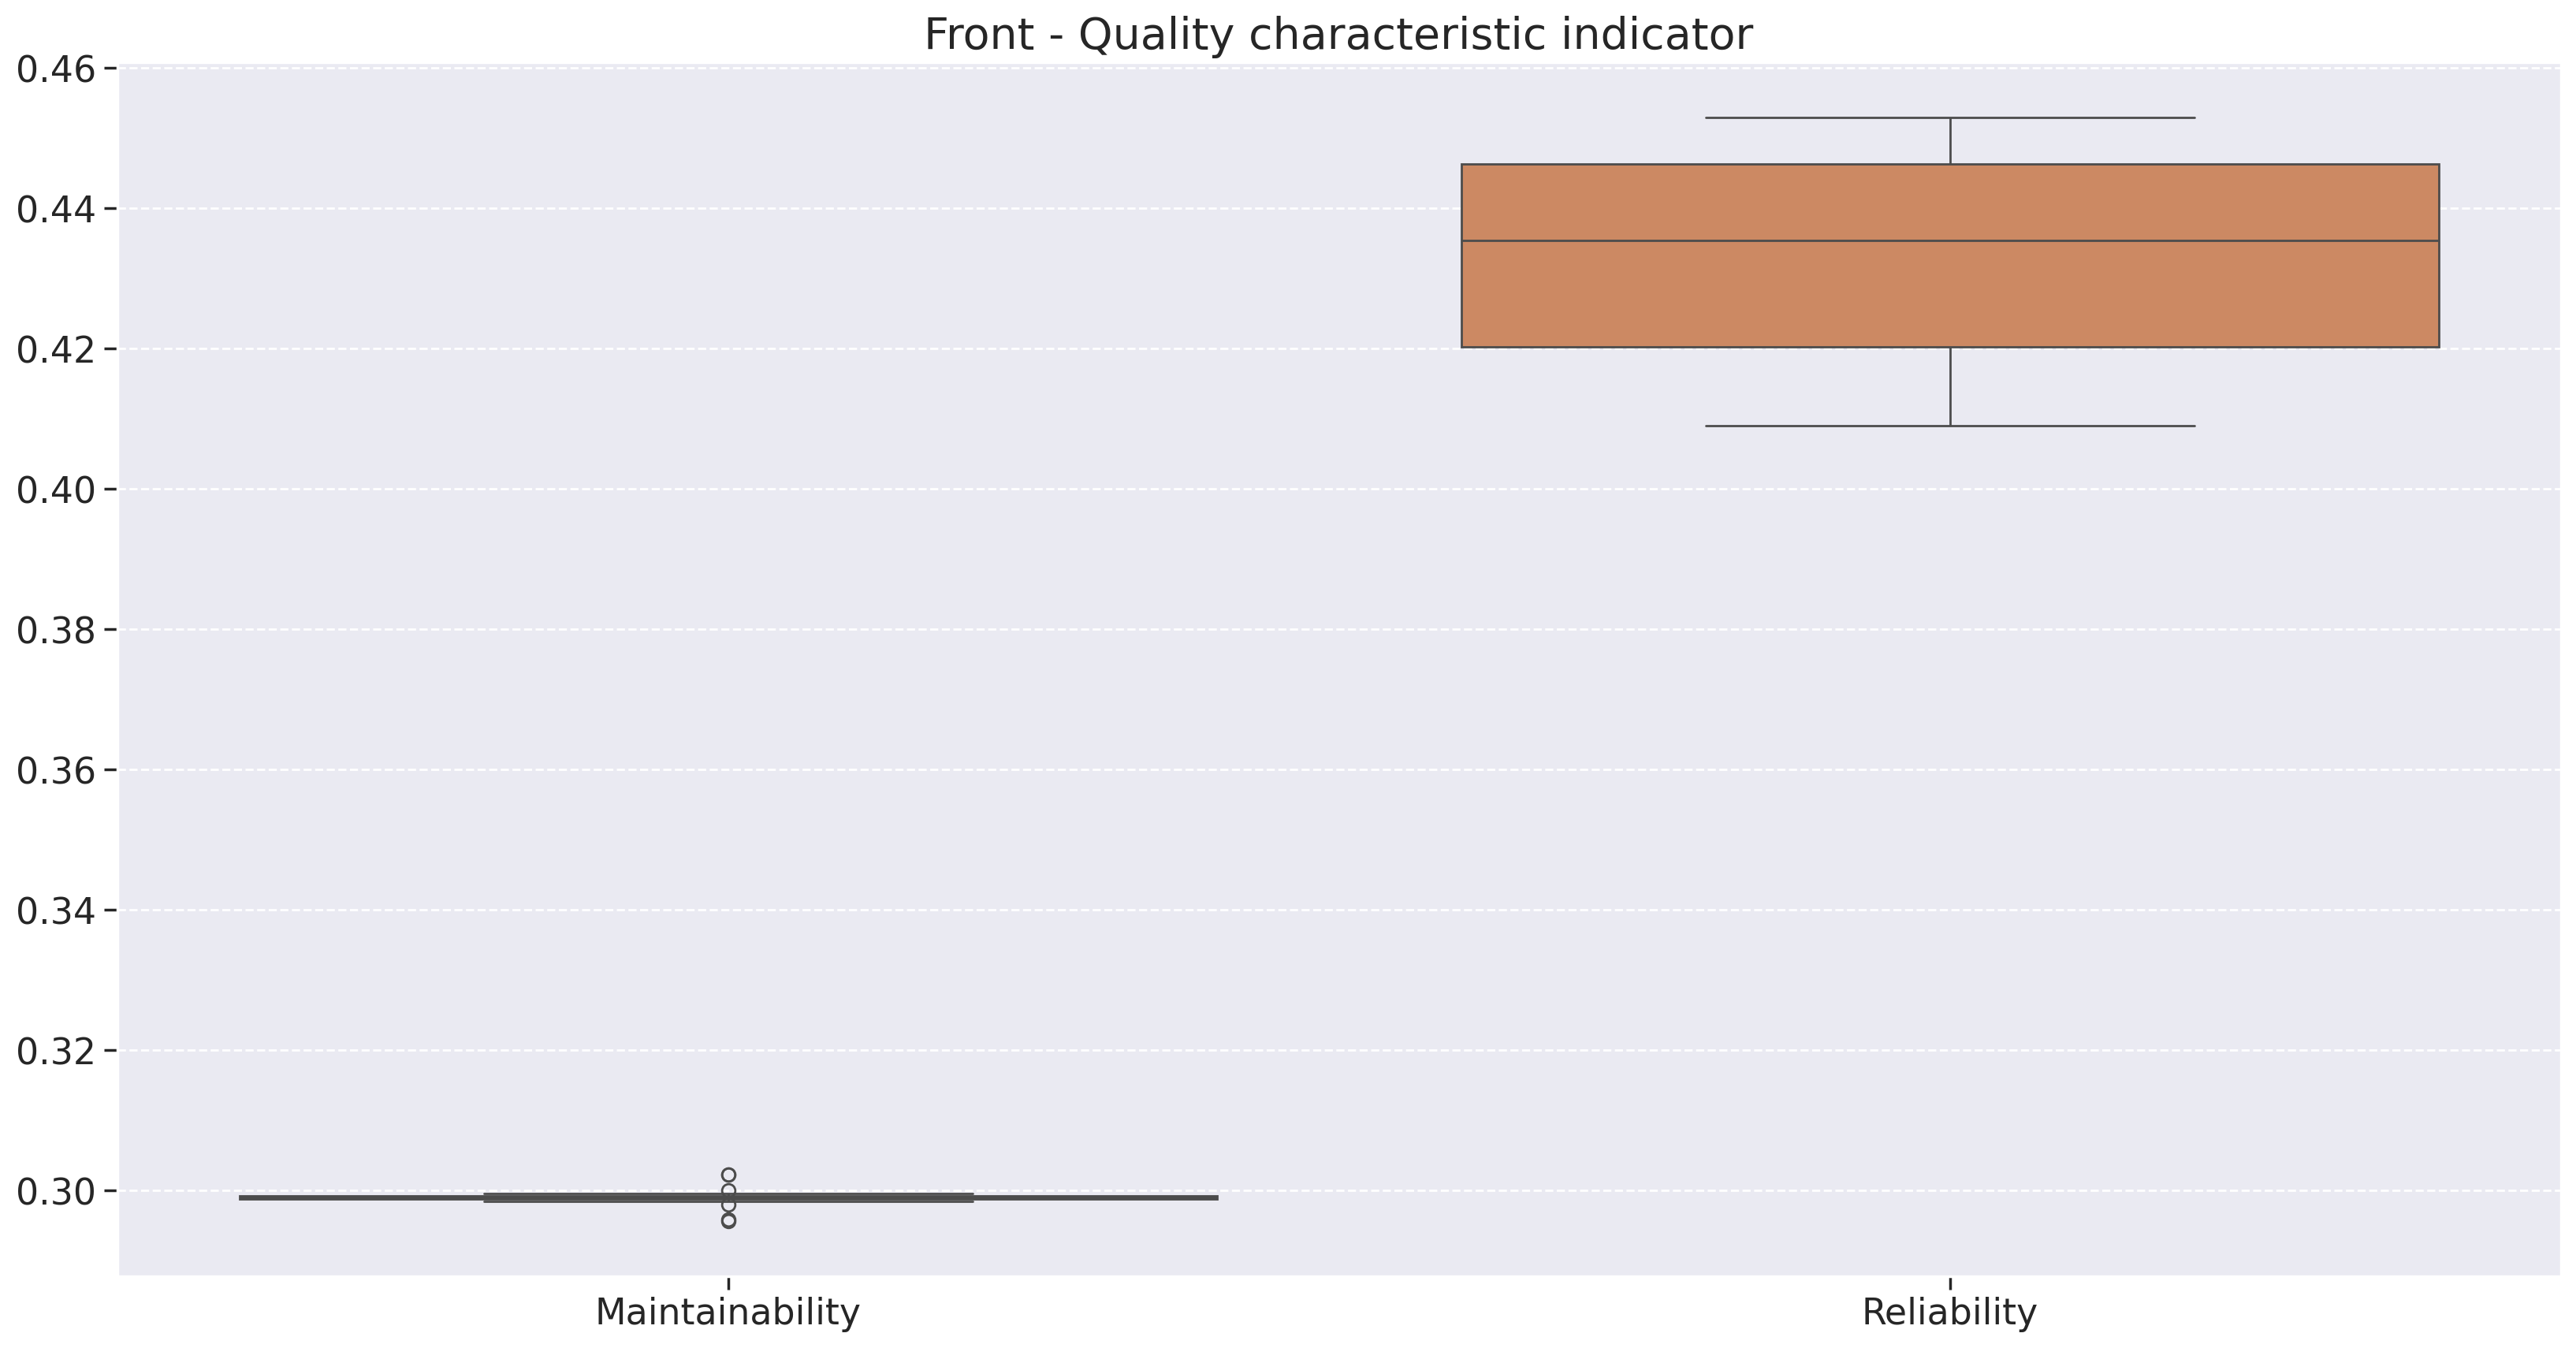

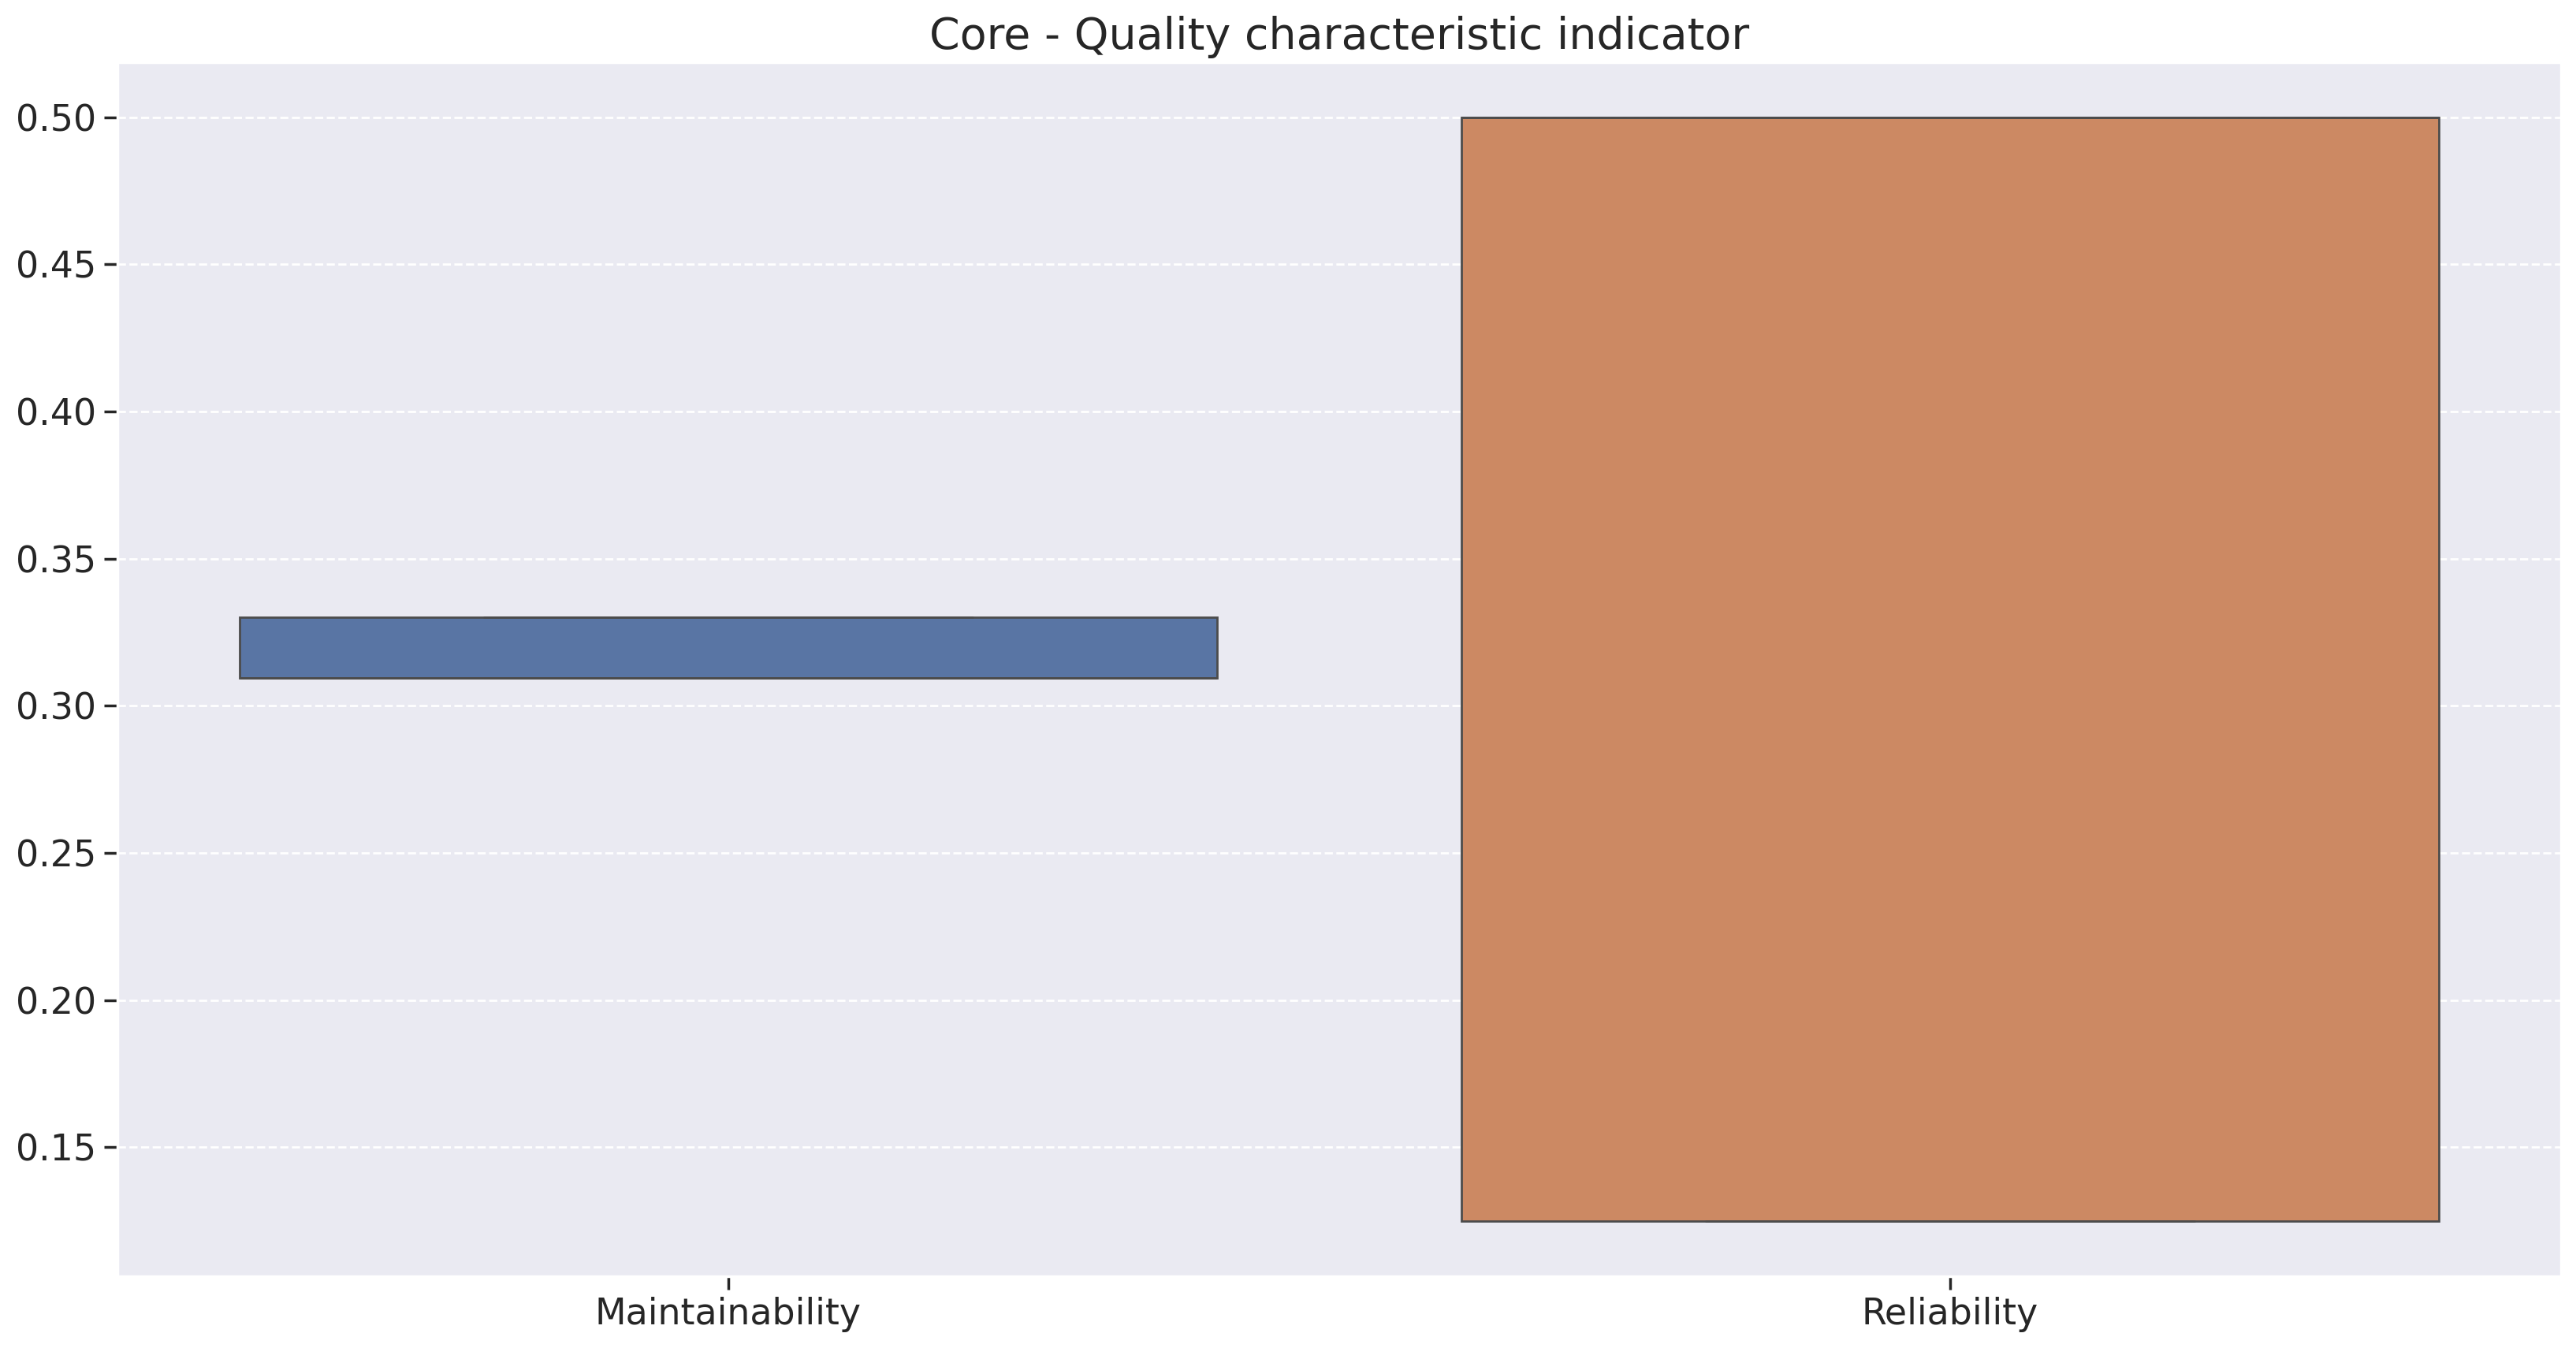

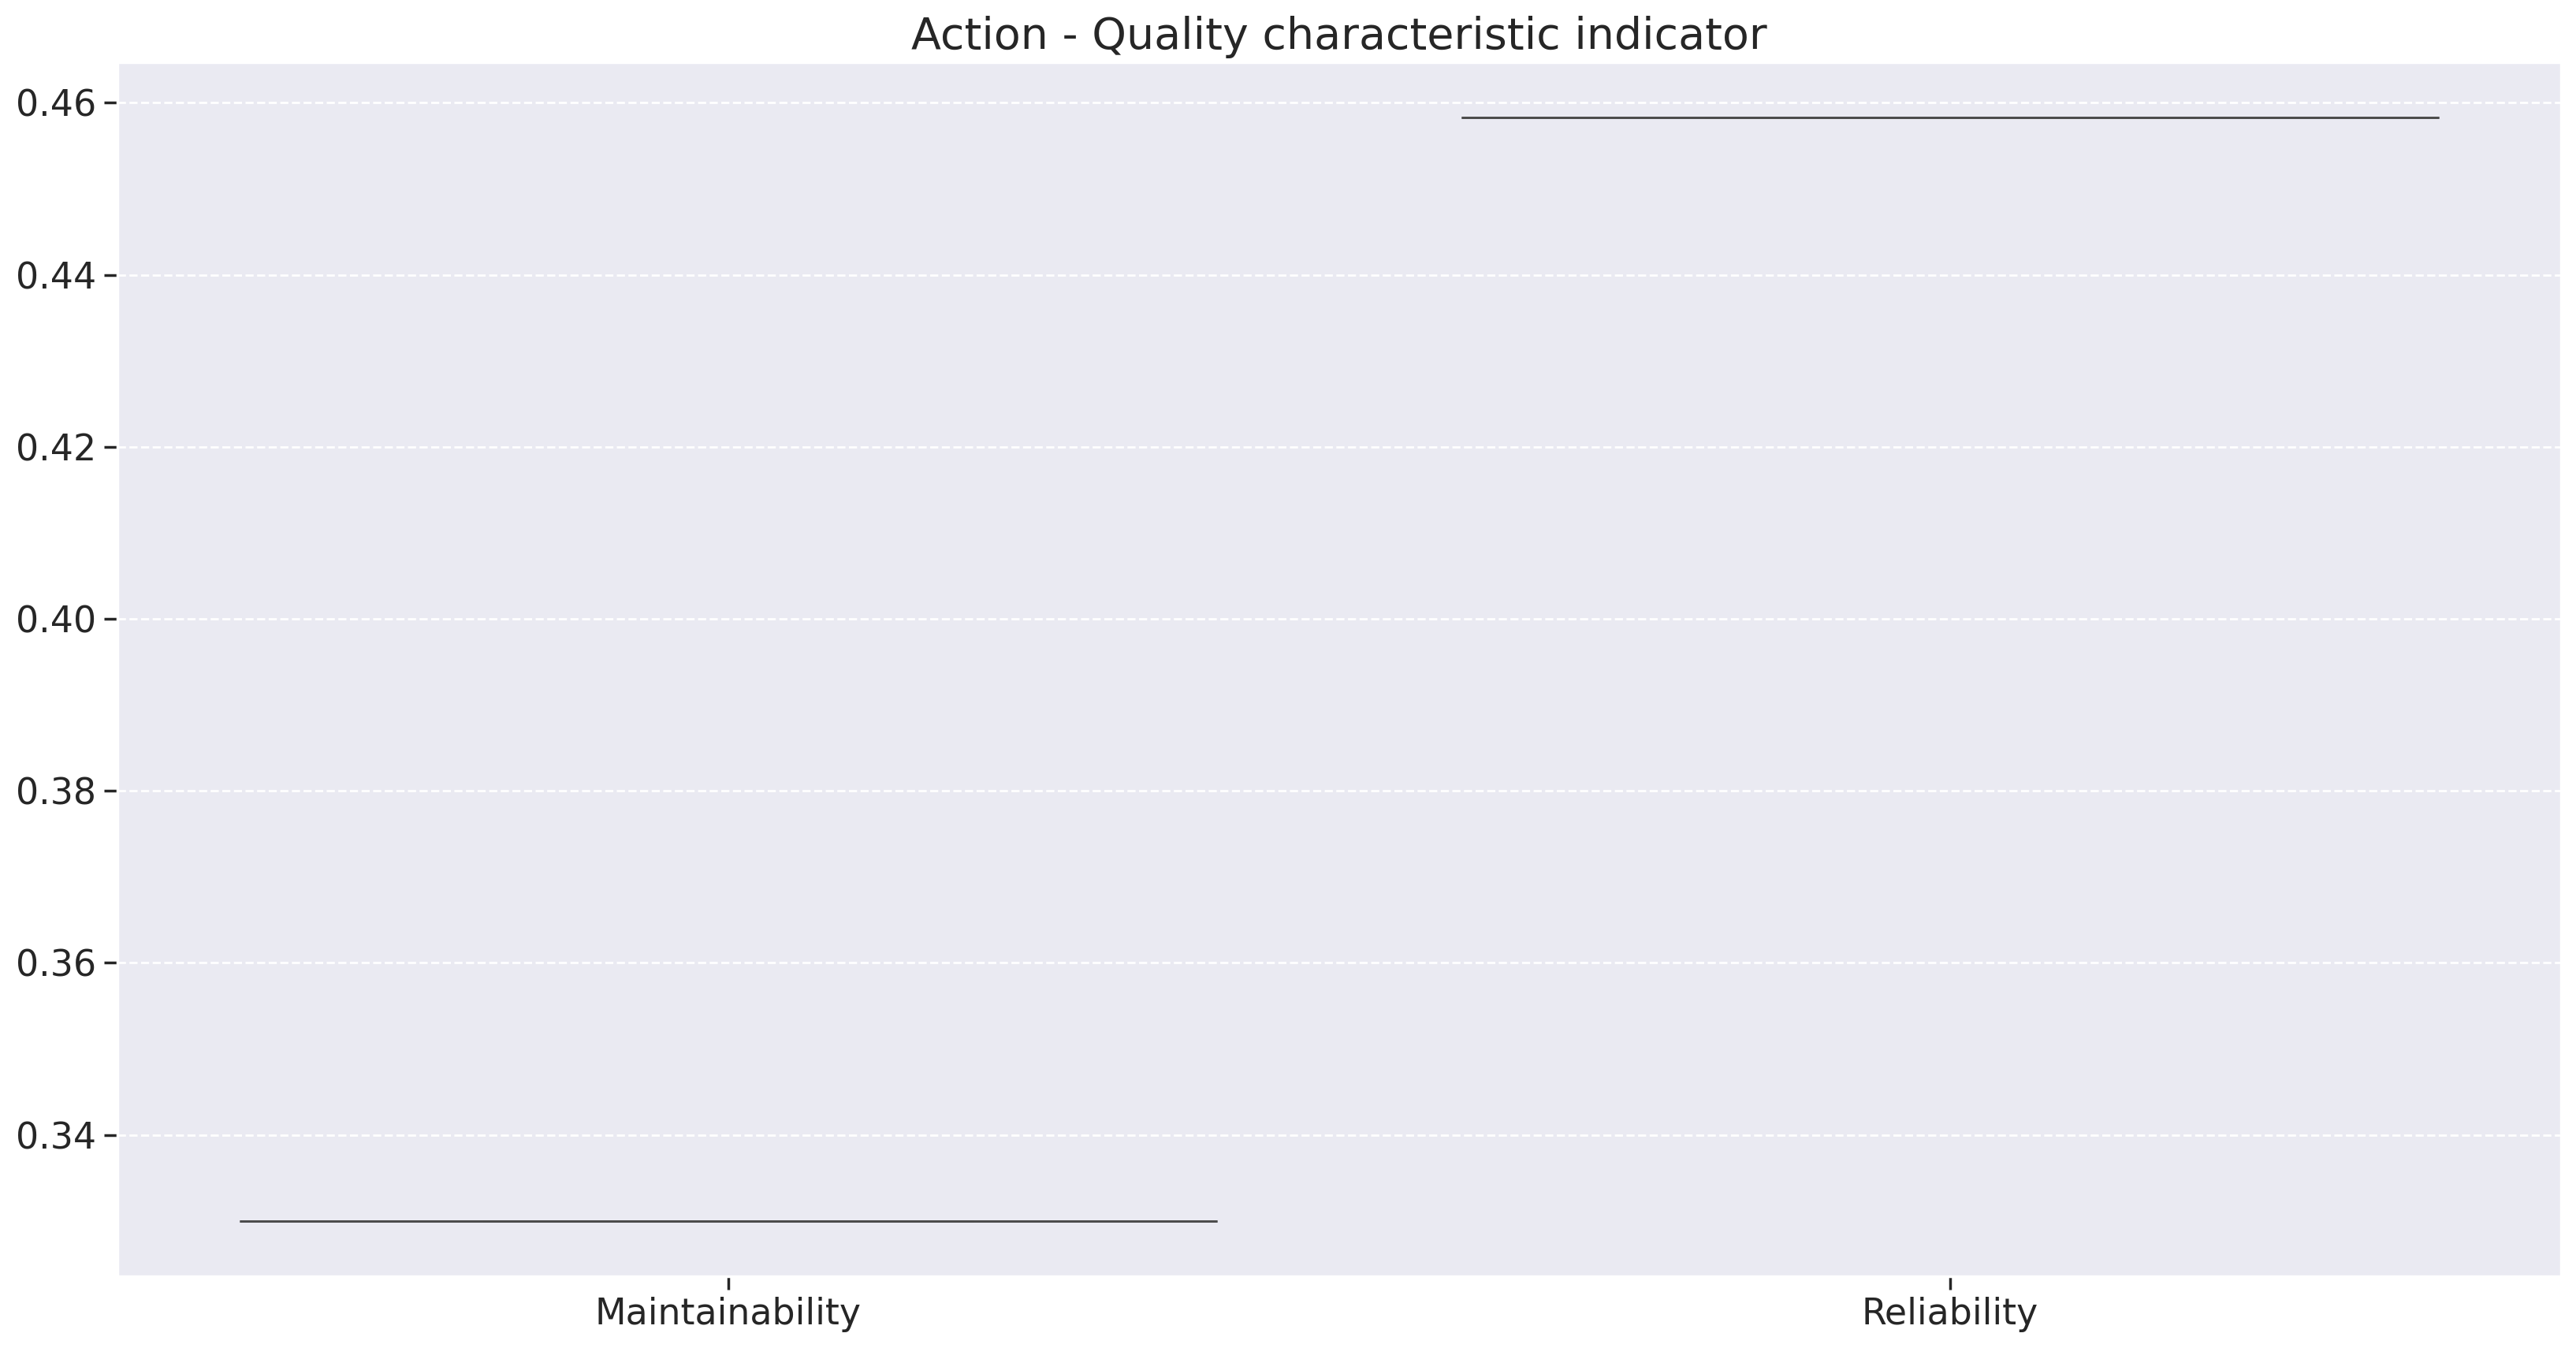

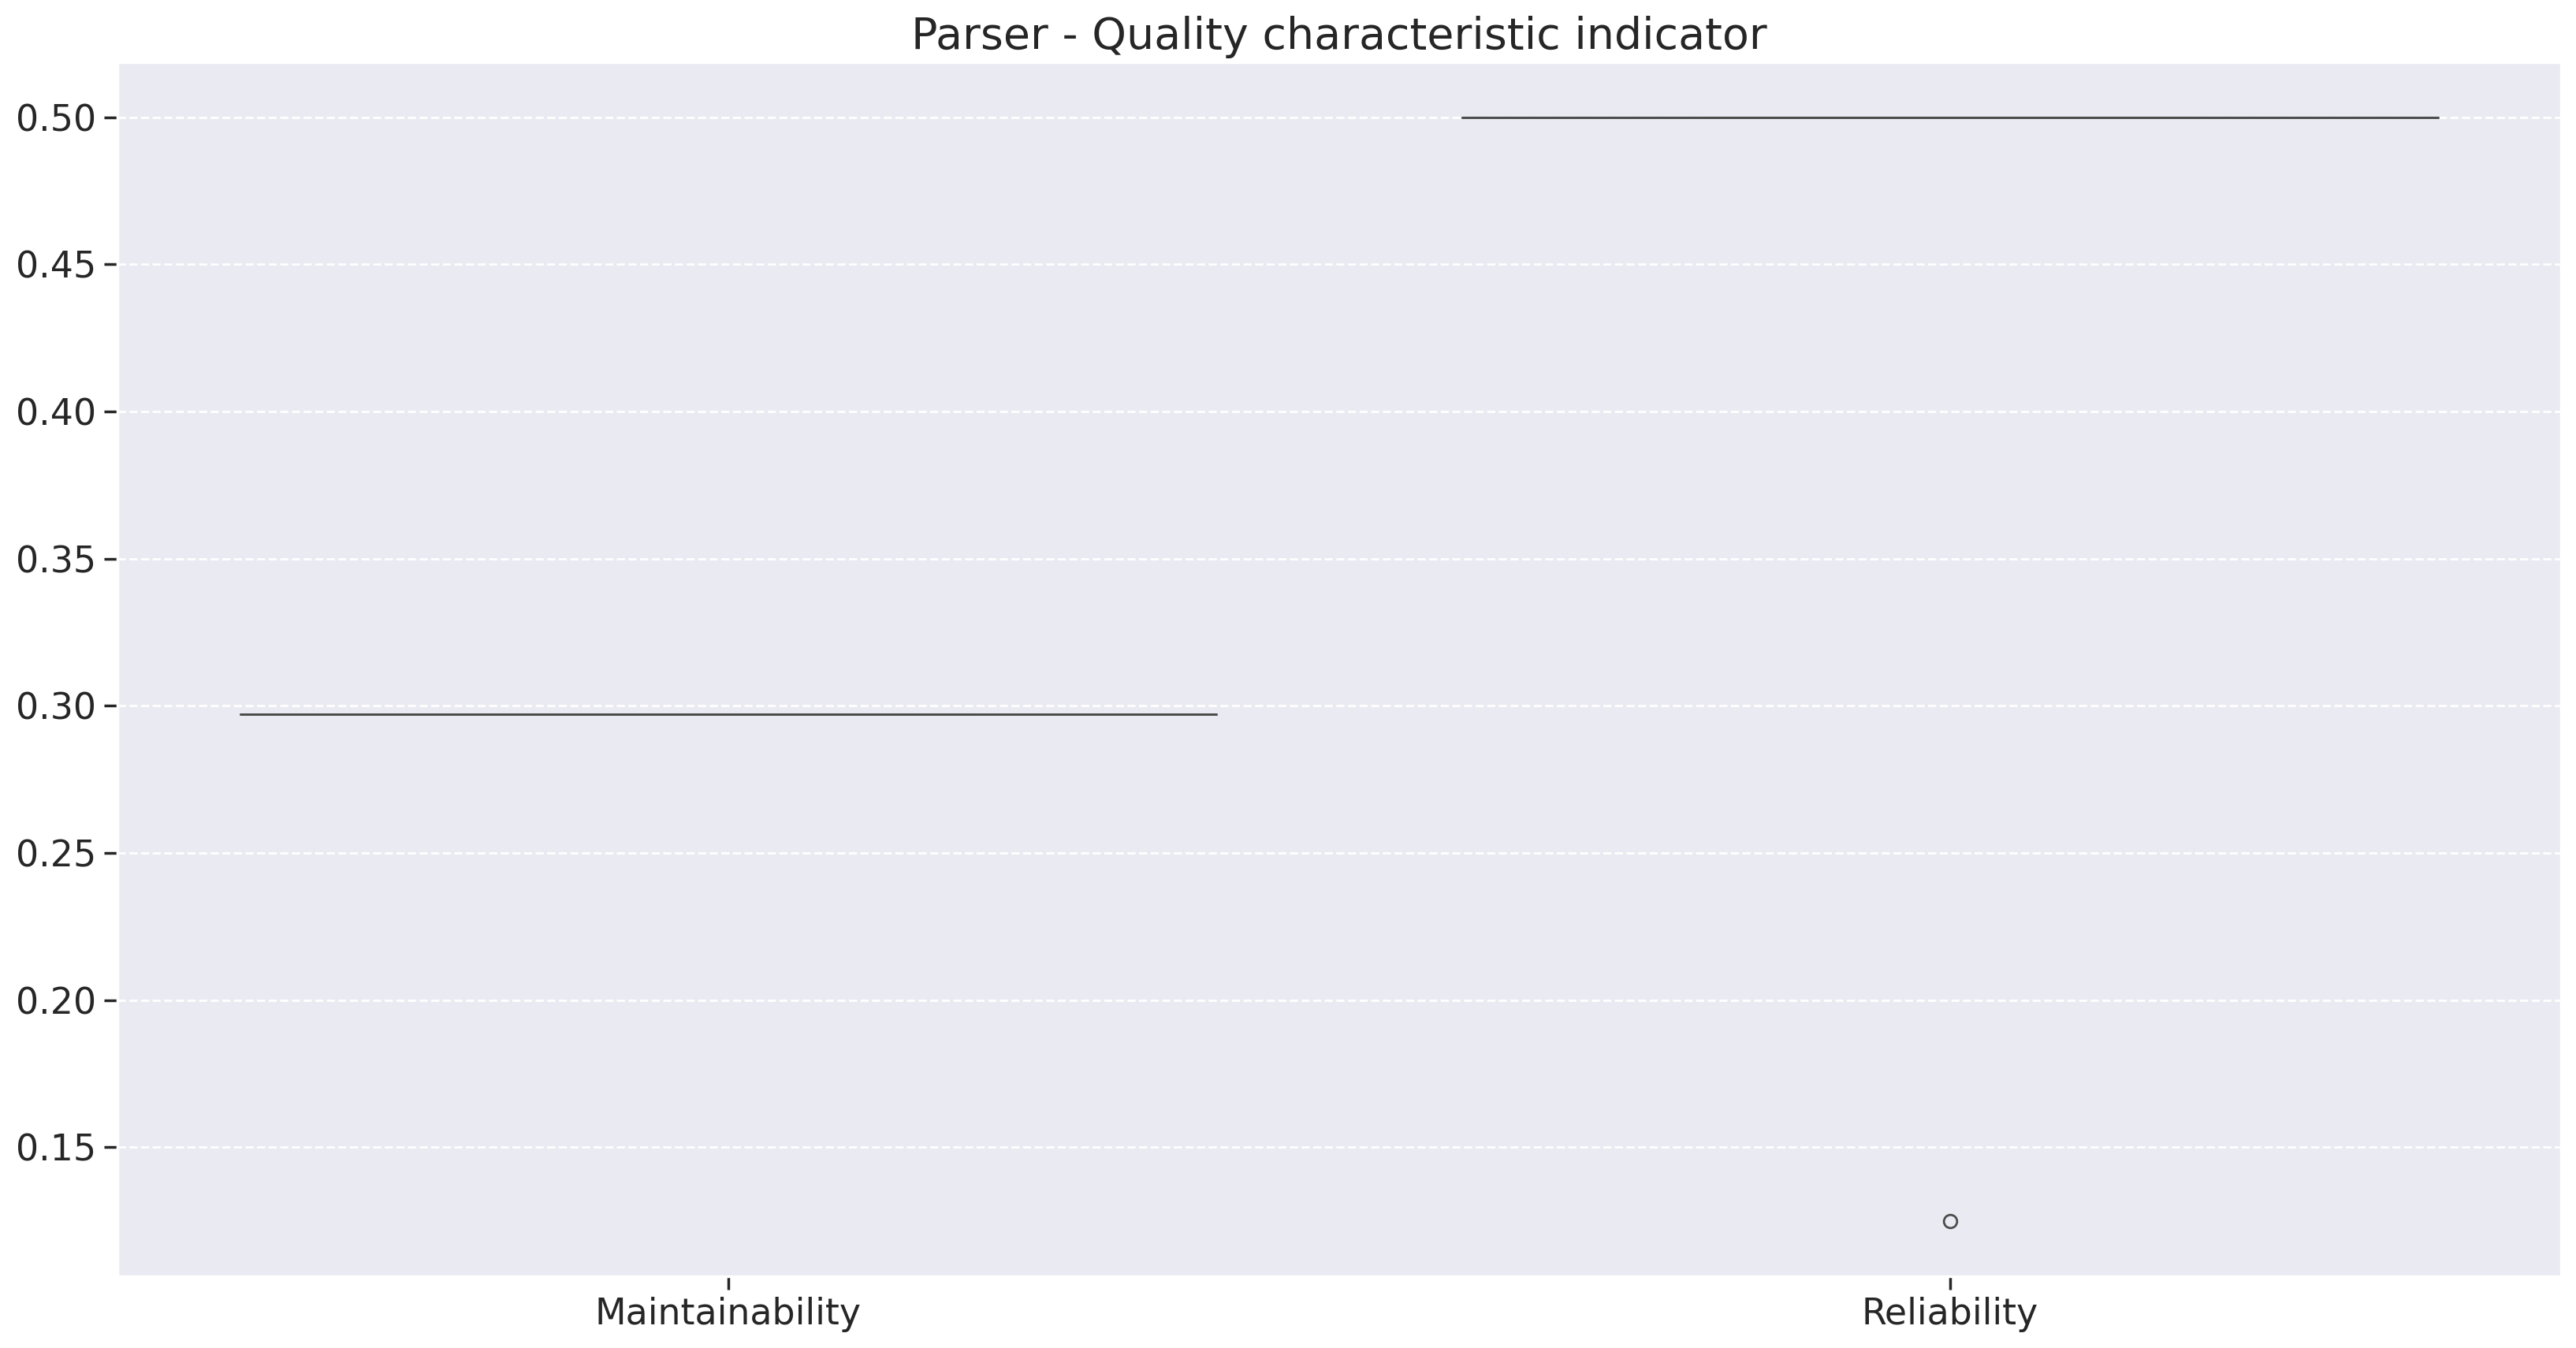

In [31]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

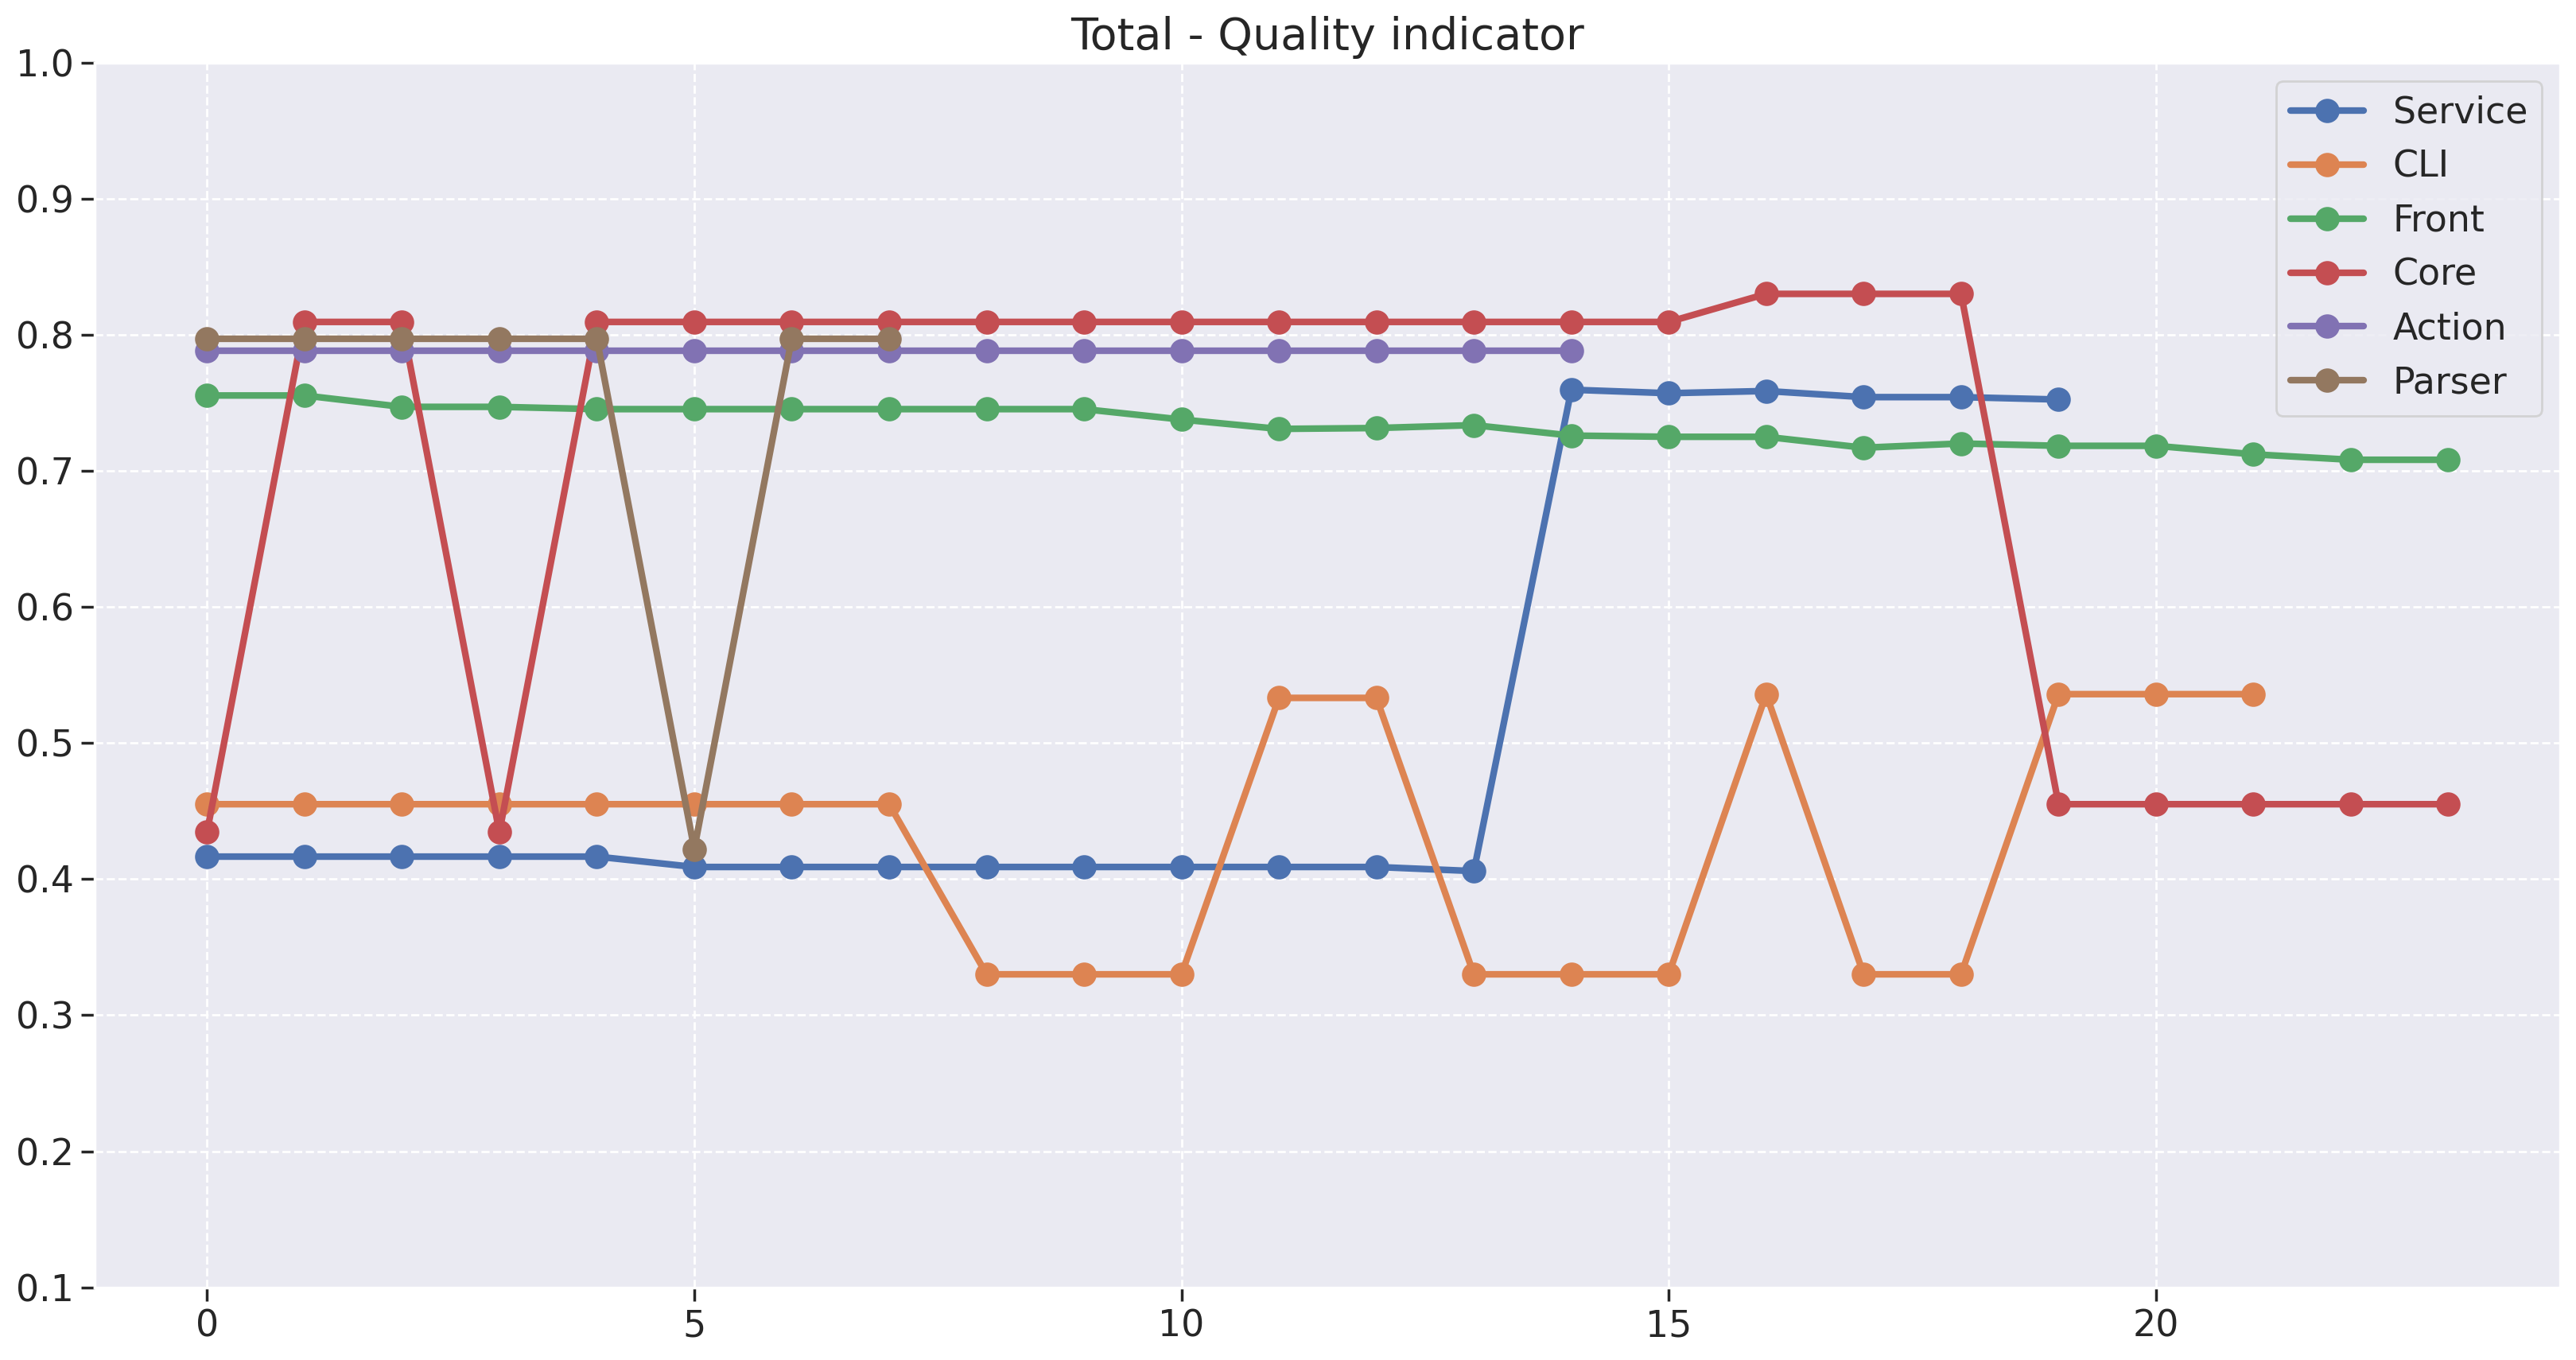

In [32]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [33]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2023-2-MeasureSoftGram--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2023-2-MeasureSoftGram--{}.csv'.format(current_datetime), index = False)

m1        m2        m3   m4   m5        m6   
0    0.522222  0.244444  1.000000  0.0  1.0  0.000000  \
1    0.522222  0.244444  1.000000  0.0  1.0  0.000000   
2    0.522222  0.244444  1.000000  0.0  1.0  0.000000   
3    0.522222  0.244444  1.000000  0.0  1.0  0.000000   
4    0.522222  0.244444  1.000000  0.0  1.0  0.000000   
5    0.505376  0.215054  1.000000  0.0  1.0  0.000000   
6    0.505376  0.215054  1.000000  0.0  1.0  0.000000   
7    0.505376  0.215054  1.000000  0.0  1.0  0.000000   
8    0.505376  0.215054  1.000000  0.0  1.0  0.000000   
9    0.505376  0.215054  1.000000  0.0  1.0  0.000000   
10   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
11   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
12   0.505376  0.215054  1.000000  0.0  1.0  0.000000   
13   0.500000  0.202128  1.000000  0.0  1.0  0.000000   
14   0.500000  0.202128  1.000000  1.0  1.0  0.914894   
15   0.480392  0.196078  1.000000  1.0  1.0  0.921569   
16   0.480392  0.205882  1.000000  1.0  1.0  0.921569   
17   0.449541  0.201835  1.000000  1.0  1.0  0.926606   
18   0.449541  0.201835  1.000000  1.0  1.0  0.926606   
19   0.456140  0.192982  1.000000  1.0  1.0  0.921053   
20   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
21   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
22   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
23   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
24   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
25   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
26   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
27   0.875000  0.125000  1.000000  0.0  1.0  0.000000   
28   0.875000  0.125000  1.000000  0.0  0.0  0.000000   
29   0.875000  0.125000  1.000000  0.0  0.0  0.000000   
30   0.875000  0.125000  1.000000  0.0  0.0  0.000000   
31   0.875000  0.125000  1.000000  0.0  0.0  0.812500   
32   0.875000  0.125000  1.000000  0.0  0.0  0.812500   
33   0.875000  0.125000  1.000000  0.0  0.0  0.000000   
34   0.875000  0.125000  1.000000  0.0  0.0  0.000000   
35   0.875000  0.125000  1.000000  0.0  0.0  0.000000   
36   0.882353  0.117647  1.000000  0.0  0.0  0.823529   
37   0.882353  0.117647  1.000000  0.0  0.0  0.000000   
38   0.882353  0.117647  1.000000  0.0  0.0  0.000000   
39   0.882353  0.117647  1.000000  0.0  0.0  0.823529   
40   0.882353  0.117647  1.000000  0.0  0.0  0.823529   
41   0.882353  0.117647  1.000000  0.0  0.0  0.823529   
42   0.825503  0.020134  0.986577  1.0  1.0  0.812081   
43   0.825503  0.020134  0.986577  1.0  1.0  0.812081   
44   0.825503  0.020134  0.966443  1.0  1.0  0.791946   
45   0.825503  0.020134  0.966443  1.0  1.0  0.791946   
46   0.825503  0.020134  0.966443  1.0  1.0  0.785235   
47   0.825503  0.020134  0.966443  1.0  1.0  0.785235   
48   0.825503  0.020134  0.966443  1.0  1.0  0.785235   
49   0.825503  0.020134  0.966443  1.0  1.0  0.785235   
50   0.825503  0.020134  0.966443  1.0  1.0  0.785235   
51   0.825503  0.020134  0.966443  1.0  1.0  0.785235   
52   0.828947  0.019737  0.960526  1.0  1.0  0.756579   
53   0.831169  0.019481  0.941558  1.0  1.0  0.740260   
54   0.832258  0.019355  0.941935  1.0  1.0  0.741935   
55   0.832258  0.019355  0.954839  1.0  1.0  0.741935   
56   0.835443  0.031646  0.943038  1.0  1.0  0.708861   
57   0.836478  0.031447  0.943396  1.0  1.0  0.704403   
58   0.836478  0.031447  0.943396  1.0  1.0  0.704403   
59   0.838509  0.031056  0.944099  1.0  1.0  0.670807   
60   0.838509  0.031056  0.944099  1.0  1.0  0.683230   
61   0.840491  0.030675  0.944785  1.0  1.0  0.674847   
62   0.840491  0.030675  0.944785  1.0  1.0  0.674847   
63   0.836364  0.036364  0.945455  1.0  1.0  0.648485   
64   0.836364  0.036364  0.939394  1.0  1.0  0.636364   
65   0.836364  0.036364  0.939394  1.0  1.0  0.636364   
66   0.625000  0.250000  1.000000  0.0  1.0  0.000000   
67   0.625000  0.250000  1.000000  1.0  1.0  1.000000   
68   0.625000  0.250000  1.000000  1.0  1.0  1.000000   
69   0.625000  0.2500

# Análise de qualidade

A análise de qualidade é observada a partir fo gráfico  de indicador fe qualidade total que mostra que o nível da qualidade baixou para alguns repositórios enquanto que em outros se manteve a estabilidade com picos de modificação.  Resultando numa variação muito mínima conforme os critérios exigidos pelas pipeline. As modificações foram em torno da CLI e front. 

## Front
Houve uma redução muito grande na cobertura de testes que obteve o valor de 58,4%, não seguindo os padrões de 80%. Tendo uma queda percentual de mais de 15% do valor do semestre passado. Houve força tarefa para amenizar essa referência, entretanto a manutenibilidade caiu drasticamente enquanto a confiabilidade teve percentual de salto.


## Action 
Diferente dos mais, a action teve um aumentou circunstancial com relação a percentual da cobertura chegando a quase 100%, num total de 93%. Tendo uma estabilidade no valor de testes.


## Service
Esse foi o repositório que teve o valor mais negativo em relação aos demais, tendo um valor abaixo do esperado, porém a cobertura teve um salto com percentual maior de 82.2%. Sendo indicador com maior salto, agregando na manutenibilidade. 

## Core
No desenvolvimento  do projeto houve uma refatoração do core que abalou os indicadores de qualidade, tornando a confiabilidade e manutenibilidade muito instável. Entretanto,  com essa mudança a cobertura teve flutuações em seus valores, o que levou a confiabilidade ter picos e estabilidade momentânea. No geral houve uma instabilidade com a complexidade ciclocamtica, resultando num percentual de 0% de cobertura. 

## CLI
Houve aumento de cobertura por conta das novas medidas implementadas, resultando numa cobertura mais confiável, tendo uma variação na qualidade, e alto valor de confiabilidade. Mas com valor de cobertura menor do que o esperado com 77.7%. 

## Parser 
A manutenibilidade se manteve no mesmo percentual que o semestre passado. Com a cobertura a cima de 80%.

### 2) No microsserviço que apresentar o pior indicador de confiabilidade, explique como seu time tratou esse problema.

A queda do valor da confiabilidade foi por motivo da implementação da nova medida Throughput tornando mais baixa do que o valor padrão.

### 3) Explique o comportamento da qualidade do produto, observada ao longo do tempo do desenvolvimento, do projeto relacionado ao seu time.

Durante o desenvolvimento do projeto em nosso time, observamos um comportamento variado na qualidade do produto ao longo do tempo em diferentes áreas. O parser, as actions e o CLI mantiveram um nível consistente de qualidade ao longo do processo.

No entanto, notamos uma leve diminuição na qualidade tanto na camada de Service quanto no Frontend. Especificamente, houve uma queda perceptível, embora não significativa, nessas áreas. Em contrapartida, o Core experimentou um aumento na sua qualidade ao longo do desenvolvimento.

Uma observação importante foi a possível diminuição na qualidade dos aplicativos, resultado da relação do time com as tecnologias envolvidas. Alguns membros da equipe não tinham familiaridade com essas tecnologias antes de iniciar o projeto. Embora tenham aprendido bastante durante o processo, não conseguimos implementar essas tecnologias com o nível técnico necessário para um aumento consistente na qualidade.

Por outro lado, identificamos e corrigimos más práticas em certos pontos do projeto, o que contribuiu para um aumento na qualidade em áreas específicas devido às refatorações realizadas.

Além disso, alguns aplicativos permaneceram intocados, mantendo sua qualidade estável ao longo do tempo. Essa estabilidade foi mantida devido à ausência de mudanças ou intervenções durante o período de desenvolvimento.

Essas variações na qualidade ao longo do tempo foram influenciadas pela experiência prévia da equipe com as tecnologias, esforços de aprendizado durante o projeto, identificação de pontos problemáticos e implementação de melhorias em áreas específicas.